# Вводная часть

Цель исследования – выявить ключевые тенденции, сегменты жертвователей и предложить рекомендации по улучшению маркетинговых стратегий фонда фонду “Синдром любви”. Для анализа предоставлена файлы выгрузки из Битрикс по полугодиям. Судя по всему, это выгрузки в одну общую таблицу данных из нескольких таблиц - CRM системы, таблицы транзакций и
т.д. В файлах исходных данных более 200 колонок, поэтому требуется провести разведочный анализ для выявления колонок, по которым можно строить основной анализ. Приорет данным по успешным транзакциям, а не данынм из CRM системы.

**Ключевые вопросы исследования:**
- Общие и средние основные показатели и метрики.
- Динамика показателей. Есть ли факторы роста, патерны в привязке с календарю?
- Портрет пользователей.
- Сегментация пользователей. Определить параметры, по которым можно провести сегметацию.
- Приток новых жертводателей. Сколько новых доноров приходит ежемесячно и откуда?
- RFM-анализ
- Когортный анализ

**Ход исследования:**

- Загрузка данных
- Разведочный анализ исходных данных
- Формирование датасета для основного анализа
- Определение основных метрик и их динамика
- Сегметация пользователей и транзакций, динамика показателей в сегментах
- Первые пожертвования. Определение, откуда приходят пользователи.
- Проведение RFM-анализа
- Проведение когортного анализа
- Итоговый выводы и рекомендации


## Начальные установки

In [1]:
import numpy as np
import requests
from bs4 import BeautifulSoup
import pandas as pd
import pytz
import datetime
import os
from io import StringIO
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import colormaps
import seaborn as sns

In [2]:
pd.options.display.precision=2
pd.set_option('display.max_colwidth', 1000)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
tz = pytz.timezone('Europe/Samara')
start = datetime.datetime.now(tz)

In [5]:
if not os.path.exists('/content/drive/My Drive/Colab Notebooks/'):
  from google.colab import drive
  drive.mount('/content/drive')
%cd /content/drive/My Drive/Colab Notebooks/love_sindrome/

/content/drive/My Drive/Colab Notebooks/love_sindrome


## Процедуры и функции

### chek_table

In [6]:
#Функция проверки датасета
#выводит на экран колво уникальных, процент nan
#возвращает список пустых колонок, которые можно удалить
#-----------------
def chek_table(raw_table):
  emp_col = []
  len_d = len(raw_table)
  print(f'Количество уникальных - Доля nan - Название колонки')
  print(f'Всего строк: {len(raw_table)}, всего колонок {len(raw_table.columns)}')
  for col in range(len(raw_table.columns)):
      emp = ''
      nunq = raw_table.iloc[:, col].nunique()
      nan_c = raw_table.iloc[:, col].isna().sum()
      if nunq < 2:
          uniq = raw_table.iloc[:, col].unique()

          if uniq[0] == '' or uniq[0] != uniq[0]:
              emp = 'Полностью пустая!'
          emp_col.append(col)
      print(f'уник - {nunq} \t na - {nan_c / len_d:.1%} \t {raw_table.columns[col]}  {emp}')

  #data.drop(columns=kontact.columns[emp_col], inplace=True)
  print(f'Всего строк: {len(raw_table)}, всего колонок {len(raw_table.columns)}')
  return #emp_col

### check_bool_col

In [7]:
#Функция проверки датасета
#выводит на экран колво уникальных в логических колонках
#с двумя значениями ДА/НЕТ
#-----------------
def check_bool_col(raw_table):
  for col in raw_table.columns:
    if raw_table[col].nunique() ==2 :
        vals = list(raw_table[col].value_counts())
        per1 = vals[1] / (vals[1] + vals[0])
        if per1 > 0.05 :  print(f'{vals} \t {per1:.1%} \t {col}')

### segmet_table

In [8]:
#функция построения таблицы рангов значений в заданной колонке
#col - параметр по которому стротся график
#-----------
def segmet_table(tr_table, col='code'):
  dd = tr_table.groupby(col).agg({'id' : 'count', 'user_id' : 'nunique', 'donate' : 'sum'})
  dd.columns = ('tr_count', 'users_count', 'donate_sum')
  dd['don_on_tr'] = dd['donate_sum'] / dd['tr_count']
  dd['don_on_user'] = dd['donate_sum'] / dd['users_count']
  dd['tc_rank'] = dd['tr_count'].rank(method = 'first', ascending=False)
  dd['uc_rank'] = dd['users_count'].rank(method = 'first', ascending=False)
  dd['ds_rank'] = dd['donate_sum'].rank(method = 'first', ascending=False)
  dd['rank_sum'] = dd['tc_rank'] + dd['uc_rank'] + dd['ds_rank']
  return dd

### get_user_table

In [9]:
#функция построения таблицы пользоваателей по таблице транзакций
def get_user_table(tr_table):
  user_table = tr_table.groupby('user_id', as_index=False).agg({'date' : ['min', 'max'], 'donate' : 'sum', 'id' : 'count'})
  user_table.columns = ('user_id', 'first_date', 'last_date', 'donate_sum', 'tr_count')
  user_table['first_month'] = user_table['first_date'].dt.month
  user_table['first_year'] = user_table['first_date'].dt.year
  user_table['first_ym'] = (user_table['first_year'] - user_table['first_year'].min()) * 12 + user_table['first_month']

  user_table['day_on'] = user_table['last_date'] - user_table['first_date']
  user_table['day_on'] = user_table['day_on'].dt.days
  user_table['month_on'] = 1 + user_table['day_on'] // 30
  user_table['oper_frec'] = user_table['tr_count'] / user_table['month_on']

  day_on_zero = user_table.query('day_on == 0')['user_id'].unique()
  regul_users = tranz.query('comment.str.contains("Ежемесячное пожертвование")')['user_id'].unique()
  user_table['type'] = user_table['user_id'].apply(lambda x: 'Подписчик' if x in regul_users else ('Разовый' if x in day_on_zero else 'Простой'))


  maxdate = tranz.query('date.notna()')['date'].max()
  user_table['day_last'] = user_table['last_date'].apply(lambda x: pd.to_datetime(maxdate) - x)
  user_table['day_last'] = user_table['day_last'].dt.days
  return user_table

### graf_dynamik_by_par

In [10]:
#Функция построения графика динамики ТОП значений в заданной колонке
#col - параметр по которому стротся график
#t - количество линий для вывода
#type - типа графика: pik - пики по дням, cumsum - накоплением
#----------------
def graf_dynamik_by_par(tr_table, col='site', t=5, type='pik'):
  par = col
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'
  fig = plt.figure(figsize=(12, 8))
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['date', col], as_index=False)['id'].count()
  dd = dd.pivot_table(index='date', columns=col, values='id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  if type == 'cumsum' : dd = dd.cumsum()

  plt.plot(dd, label=dd.columns)
  plt.legend()
  plt.title(f'Динамика транзакции по параметру {par}')
  plt.xlabel('Дата')
  plt.ylabel('Количество транзакций')
  plt.show()
  return

### graf_dynamik_by_par_subplot

In [11]:
#Функция построения сразу двух графиков динамики ТОП значений в заданной колонке - пики по дням и накоплением
#col - параметр по которому стротся график
#t - количество линий для вывода
#----------------
def graf_dynamik_by_par_subplot(tr_table, col='site', t=5):
  par = col
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['date', col], as_index=False)['id'].count()
  dd = dd.pivot_table(index='date', columns=col, values='id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  fig, ax = plt.subplots(1, 2, figsize=(16, 6))
  ax[0].plot(dd, label=dd.columns)
  ax[0].set_xlabel('Дата')
  ax[0].set_ylabel('Количество транзакций')
  #ax[0].set_xticks([dd.index[::2]])
  ax[0].set_xticks(np.array(dd.index[::180]))

  dd = dd.cumsum()
  ax[1].plot(dd, label=dd.columns)
  ax[1].set_xlabel('Дата')
  ax[1].set_ylabel('Количество транзакций')
  ax[1].set_xticks(np.array(dd.index[::180]))

  plt.legend(loc='best', bbox_to_anchor=(0.1, -0.1))
  plt.suptitle(f'Динамика транзакции по параметру {par}')

  plt.show()
  return

### graf_dynamik_first_donate_by_col

In [12]:
#Функция построения графика динамики первых пожертвований от ТОП значений заданной колонке
#col - параметр по которому стротся график
#t - количество линий для вывода
#----------------
def graf_dynamik_first_donate_by_col(tr_table, col = 'code',  t = 5):
  if col == 'site': par = 'Сайт источинк'
  if col == 'code': par = 'Код'
  if col == 'comment': par = 'Комментарий'
  if col == 'action': par = 'Метка ссылки'

  fig = plt.figure(figsize=(12, 8))
  top = tr_table[col].value_counts().head(t).index
  qst = col + '.isin(@top)'
  dd = tr_table.query(qst).groupby(['first_date', col], as_index=False)['user_id'].count()
  dd = dd.pivot_table(index='first_date', columns=col, values='user_id').fillna(0)

  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)

  plt.plot(dd, label=dd.columns)
  plt.legend()
  plt.title(f'Динамика первых пожертвований по параметру {par}')
  plt.xlabel('Дата')
  plt.ylabel('Количество первых пожертвований')
  plt.show()
  return

### get_rfm_table

In [13]:
def get_rfm_table(tr_table, seg_u, rfm_ranks):
  users_rfm = get_user_table(tr_table.query('user_id.isin(@seg_u)'))
  users_rfm['R'] = users_rfm['day_last'].apply(lambda x: '1' if x < rfm_ranks[0] else ('2' if x < rfm_ranks[1] else '3'))
  users_rfm['F'] = users_rfm['oper_frec'].apply(lambda x: '1' if x > rfm_ranks[2] else ('2' if x > rfm_ranks[3] else '3'))
  #users_rfm['F'] = users_rfm.apply(lambda row: '3' if row['day_on'] == 0 else ('2' if row['oper_frec'] < 0.8 else '1'), axis=1)
  users_rfm['M'] = users_rfm['donate_sum'].apply(lambda x: '1' if x > rfm_ranks[4] else ('2' if x > rfm_ranks[5] else '3'))
  users_rfm['RFM'] = users_rfm['R'] + users_rfm['F'] + users_rfm['M']

  rfm_table = users_rfm.groupby(['R', 'F', 'M'], as_index = False).agg({'RFM' : 'first', 'tr_count' : ['count', 'sum'], 'donate_sum' : 'sum', 'last_date' : 'max'})
  rfm_table.columns = ['R', 'F', 'M', 'RFM', 'rfm_users', 'rfm_tr', 'rfm_sum', 'rfm_last_date']
  rfm_table['avg_sum'] = round(rfm_table['rfm_sum'] / rfm_table['rfm_tr'], 2)

  rfm_table['R'] = rfm_table['R'].replace({'1':'1/Недавние', '2' : '2/Спящие', '3': '3/Уходящие'})
  rfm_table['F'] = rfm_table['F'].replace({'1':'1/Частые', '2' : '2/Редкие', '3': '3/Разовые'})
  rfm_table['M'] = rfm_table['M'].replace({'1':'1/Большой чек', '2' : '2/Средний чек', '3': '3/Малый чек'})
  rfm_table['RF'] = rfm_table['R'] + rfm_table['F']
  return rfm_table

### show_rfm_table_sns

In [14]:
#Функция показа матрицы RFM в виде heatmap от sns
#col - показатель по которому стоится таблица
#------------------
def show_rfm_table_sns(rfm_table, col = 'rfm_sum'):
    fig = plt.figure(figsize = (12, 6))
    rfm_pivot = rfm_table.pivot(index = ['R', 'F'], columns = 'M', values = col).fillna(0)
    rfm_pivot.rename(index={'1':'Недавние(1)', '2' : 'Спящие(2)', '3': 'Уходящие(3)'}, level=0, inplace=True)
    rfm_pivot.rename(index={'1':'Частые(1)', '2' : 'Редкие(2)', '3': 'Разовые(3)'}, level=1, inplace=True)
    rfm_pivot.rename(columns={'1':'Большой чек(1)', '2' : 'Средний чек(2)', '3': 'Малый чек(3)'}, inplace=True)
    par = ''
    if col == 'rfm_sum': par = 'Сумма транзакций'
    if col == 'rfm_users': par = 'Количество пользователей'
    if col == 'rfm_tr': par = 'Количество транзакций'

    sns.heatmap(rfm_pivot, cmap='RdYlGn', annot=True, cbar=False, fmt=',.0f')
    plt.title(f'Тепловая карта RFM анализа по параметру "{par}"')
    plt.show()
    return

### get_chogort_table

In [15]:
def get_chogort_table(tr_table, seg_u):
  user_table = get_user_table(tr_table.query('user_id.isin(@seg_u)'))
  chogort_table = pd.DataFrame([])
  for m in sorted(user_table ['first_ym'].unique()):
    ch_u = user_table .query('first_ym == @m')['user_id'].unique()
    dd = tr_table.query('user_id.isin(@ch_u) and donate < @rfm_donate_lim').groupby('tr_ym', as_index=False)\
        .agg({'user_id': 'nunique', 'id' : 'count', 'donate' : 'sum', 'tr_y':'first', 'tr_m': 'first'})
    dd['ch_m'] = f"{dd['tr_y'][0]}_{dd['tr_m'][0]:0>2}"
    dd['m_live'] = dd['tr_ym'] - m + 1
    dd['ltv'] = dd['donate'].cumsum()
    dd['ltv_m'] = round(dd['ltv'] / dd['m_live'])
    dd['rr'] = round(100 * dd['user_id'] / len(ch_u), 2)
    dd['cr'] =round(dd['user_id'] / dd['user_id'].shift(1), 2)
    chogort_table = pd.concat([chogort_table, dd])

  chogort_table.columns = ('tr_mon', 'user_count', 'tr_count', 'donate_sum',
                          'tr_y',  'tr_m',  'ch', 'm_live',
                          'ltv', 'ltv_m', 'rr', 'cr')
  return chogort_table

### show_chogort_graf

In [16]:
#Функция показа таблицы в виде heatmap и графика динамики когорт
#col - показатель по которому стоится таблица
#pr - количество разрядов при округлении
#ml - горизонт когорного анализа
#------------------
def show_chogort_graf(chogort_table, col='user_count', pr=0, ml=12):
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания'
    if col == 'cr': par = 'Коэф. оттока'

    fig = plt.figure(figsize = (20, 10))

    dd = chogort_table.pivot(index='m_live', columns='ch', values=col)
    dd = dd.iloc[0:ml, -ml:]
    plt.plot(dd, label = dd.columns)

    plt.title(f'График динамики параметра "{par}" по когортнам')
    plt.ylabel('')
    plt.xlabel('Мeсяцы жизни когорты')
    plt.legend()
    plt.show()
    return

### show_chogort_table_sns

In [17]:
#Функция показа таблицы динамики по когортам в виде heatmap sns
#col - показатель по которому стоится таблица
#pr - количество разрядов при округлении
#ml - горизонт когорного анализа
#------------------
def show_chogort_table_sns(chogort_table, col='user_count', pr=0, ml=12):

    dd = chogort_table.pivot(index = 'ch', columns = 'm_live', values = col)
    dd = dd.iloc[ -ml:, 0:ml]
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания (%)'
    if col == 'cr': par = 'Коэф. оттока'

    fig = plt.figure(figsize = (20, 10))
    hm = sns.heatmap(dd, cmap='RdYlGn', annot = True, fmt=f',.{pr}f')
    plt.title(f'Тепловая карта когортного анализа по параметру "{par}"')
    plt.yticks(rotation = 0)
    plt.ylabel('Когорта')
    plt.xlabel('Мeсяцы жизни когорты')
    plt.show()

    return

### show_chogort_subplot

In [18]:
#Функция показа таблицы в виде heatmap и графика динамики когорт
#col - показатель по которому стоится таблица
#pr - количество разрядов при округлении
#ml - горизонт когорного анализа
#------------------
def show_chogort_subplot(chogort_table, col='user_count', pr=0, ml=12):
    par = ''
    if col == 'donate_sum': par = 'Сумма транзакций'
    if col == 'user_count': par = 'Количество пользователей'
    if col == 'tr_count': par = 'Количество транзакций'
    if col == 'ltv': par = 'LTV'
    if col == 'ltv_m': par = 'LTV в месяц'
    if col == 'rr': par = 'Коэф. удержания (%)'
    if col == 'cr': par = 'Коэф. оттока'

    f, ax = plt.subplots(1, 2, figsize=(16,5))

    dd = chogort_table.pivot(index='ch', columns='m_live', values=col)
    dd = dd.iloc[ -ml:, 0:ml]
    sns.heatmap(dd, xticklabels=dd.columns, cmap='RdYlGn', annot = True, fmt=f'.{pr}f', cbar=False, ax = ax[0])
    ax[1].plot(dd.T, label = dd.index)

    ax[0].set_xlabel('Когорта')
    ax[0].set_ylabel('Месяц жизни')
    ax[0].tick_params(axis='y', labelrotation = 00)
    ax[1].set_xlabel('Месяц жизни')
    ax[1].set_ylabel(f'{par}')
    ax[1].legend(title='Когорты')
    plt.suptitle(f'Динамика параметра "{par}" в когортах по месяцам жизни')
    plt.show()
    return

### seg_dynamik_graf

In [19]:
def seg_dynamik_graf(tr_table, seg_u):
  seg_dynamik = tr_table.query('user_id.isin(@seg_u)').groupby('tr_month').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})

  seg_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
  seg_dynamik['d_cumsum'] = seg_dynamik['donate_sum'].cumsum()
  seg_dynamik['date'] = pd.to_datetime(seg_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

  seg_dynamik['u_newcount'] = tr_table.query('user_id.isin(@seg_u)')[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count()
  seg_dynamik['u_newcount'] = seg_dynamik['u_newcount'].fillna(0)
  seg_dynamik['u_cumcount'] = tr_table.query('user_id.isin(@seg_u)')[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count().cumsum()
  seg_dynamik['u_cumcount'] = seg_dynamik['u_cumcount'].ffill()

  f, ax = plt.subplots(1, 2, figsize=(20,6))
  ax[0].plot(month_dynamik['date'], month_dynamik['user_count'], color='tab:green', label='Все пользователи')
  ax[0].plot(seg_dynamik['date'], seg_dynamik['user_count'], color='tab:pink', label=f'Все из сегмента {seg}')
  ax[0].plot(seg_dynamik['date'], seg_dynamik['u_newcount'], color='tab:blue', label=f'Новые в сегменте {seg}')
  ax[0].set_ylabel('Количество донаторов')
  ax[0].set_title(f'Все пользователи и из сегмента {seg} по месяцам')
  ax[0].legend()

  ax[1].plot(month_dynamik['date'], month_dynamik['u_cumcount'], color='tab:orange', linewidth = 3, label='Все пользователи нарастанием')
  ax[1].plot(seg_dynamik['date'], seg_dynamik['u_cumcount'], color='tab:red', linewidth = 3, label=f'Все из сегмента {seg} нарастанием')
  ax[1].set_title(f'Рост количества всех пользователей и в сегменте {seg}')
  ax[1].set_ylabel('Количество донаторов')
  ax[1].legend()

  plt.suptitle(f'Динамика количества донаторов в сегменте {seg} по месяцам')
  plt.show()
  return

# Разведочный анализ

Из-за большого количества колонок в файлах исходных данных проведем предварительную разведку исходных данных, чтобы отобрать какие именно колонки пойдут в дальнейший анализ.

In [20]:
#загрузка данных из html построчо
def load_data_bystring(datafile):
    print(f"Начинаю читать файл {datafile}")
    with open(datafile, encoding="utf-8", errors='ignore') as df:
        soup = BeautifulSoup(df, 'lxml') #'html.parser', from_encoding='UTF-8')

    table1 = soup.find('table')
    headers = []
    print(f"Всего заголовков {len(table1.find_all('th'))}")

    for i in table1.find_all('th'):
        title = i.text
        headers.append(title)

    data = pd.DataFrame(columns = headers)
    l = len(table1.find_all('tr'))
    print(f"Всего строк {l}")
    i = 0
    for j in table1.find_all('tr')[1:]:
        row_data = j.find_all('td')
        row = [i.text for i in row_data]
        length = len(data)
        data.loc[length] = row
        if i % 100 == 0: print('\r' + f'Обработано {i} строк ({100 * i/l:.1f}%)', end='')
        i +=1
    return data

In [21]:
#загрузка данных из html всей таблицы сразу
#работает быстрее!!!
def load_alltable(datafile):
  with open(datafile, 'r', encoding='utf-8', errors='ignore') as file:
    soup = BeautifulSoup(file, 'html.parser')

  tables = soup.find_all('table')
  if tables:
      table_html = str(tables[0])
      table_io = StringIO(table_html)
      data = pd.read_html(table_io)[0]
      return data

Загрузка по одному файлу

In [22]:
#path = 'd:/newwork/-=love_sindrom=-/'
path = 'data/'

#загрузка данных из исходников
#datafile = '01.07.2024-31.12.2024.xls'
#rawdata = load_data_bystring(path + datafile)
#rawdata = load_alltable(path + datafile) # эта процедура быстрее
#rawdata = pd.read_html(path + datafile, skiprows=0, header=0)[0]  # а это ЕЩЕ быстрее =)


#загрузка данных из сохраненных ранее csv
#datafile = '01.01.2024-30.06.2024.csv'
#datafile = '01.07.2024-31.12.2024.csv'
#rawdata = pd.read_csv(path + datafile)


#сохранение в csv, чтобы каждый раз не парсить исходные файлы
#rawdata.to_csv(path + os.path.splitext(datafile)[0] + '.csv', sep=',', index=False, encoding='utf-8')

Загрукза всех файлов из папки

In [23]:
all = 0
rawdata = pd.DataFrame([])
for ff in os.listdir(path):
  filename, fileexp = os.path.splitext(ff)
#  if fileexp == '.xls':
#    dd = pd.read_html(path + ff, skiprows=0, header=0)[0]
  if fileexp == '.csv':
    dd = pd.read_csv(path + ff)
    dd['file'] = ff
    l = len(dd)
    all = all + l
    rawdata = pd.concat([rawdata, dd])
    print(f'Загрузка {l} строк данных из файла {ff}')

print(f'Всего загружено {all} строк')

Загрузка 8928 строк данных из файла 01.01.2024-30.06.2024.csv
Загрузка 7930 строк данных из файла 01.01.2023-30.06.2023.csv
Загрузка 8917 строк данных из файла 01.07.2023-31.12.2023.csv
Загрузка 8580 строк данных из файла 01.07.2024-31.12.2024.csv
Всего загружено 34355 строк


In [24]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:08:30.752016+04:00
 От начала рассчета прошло 0:00:02.097285


In [25]:
rawdata.head()

ID  Название (Количество уникальных)  \
0  382389                              1.00   
1  382391                              1.00   
2  382399                              1.00   
3  382423                              1.00   
4  382427                              1.00   

   Стадия сделки (Количество уникальных)  \
0                                   1.00   
1                                   1.00   
2                                   1.00   
3                                   1.00   
4                                   1.00   

   Ответственный (Количество уникальных) Дата начала (Минимальное)  \
0                                   1.00                05.06.2024   
1                                   1.00                05.06.2024   
2                                   1.00                05.06.2024   
3                                   1.00                05.06.2024   
4                                   1.00                05.06.2024   

                                      Комментарий Направление сделки  \
0  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
1                         Поддержать соревнование      Пожертвования   
2  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
3                         Поддержать соревнование      Пожертвования   
4      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   

  Стадия сделки В стадии: В работе В стадии: Удачно  ... SITE_NAME  \
0   Prospecting                Нет              Нет  ...       NaN   
1        Posted                Нет               Да  ...       NaN   
2        Posted                Нет               Да  ...       NaN   
3        Posted                Нет               Да  ...       NaN   
4        Posted                Нет               Да  ...       NaN   

  Тип пожертвования Источник пожертвования Мероприятие Дата рождения ребенка  \
0               NaN                    NaN         NaN                   NaN   
1               NaN                    NaN         NaN                   NaN   
2               NaN                    NaN         NaN                   NaN   
3               NaN                    NaN         NaN                   NaN   
4               NaN                    NaN         NaN                   NaN   

  Информация о родстве Служебное: Copy ID Служебное: Таргеты: Цикл ожидания  \
0                  NaN          382389.00                               Нет   
1                  NaN          382391.00                               Нет   
2                  NaN          382399.00                               Нет   
3                  NaN          382423.00                               Нет   
4                  NaN          382427.00                               Нет   

                        file  \
0  01.01.2024-30.06.2024.csv   
1  01.01.2024-30.06.2024.csv   
2  01.01.2024-30.06.2024.csv   
3  01.01.2024-30.06.2024.csv   
4  01.01.2024-30.06.2024.csv   

   Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)  
0                                                                                  NaN  
1                                                                                  NaN  
2                                                                                  NaN  
3                                                                                  NaN  
4                                                                                  NaN  

[5 rows x 229 columns]

## Разведка данных ProfileReport

In [26]:
#Разведка данных ProfileReport

#from ydata_profiling import ProfileReport
#profile = ProfileReport(rawdata, title="Profiling Report")
#profile.to_notebook_iframe()

Много колонок - много букв, но в целом понятно, к чему надо присмотреться =)

## Разделение таблиц

Похоже, исходные данные - итог соединения нескольких таблиц по full join. Попробуем разделить таблицы

### Таблица Контактов

Выделяем колонки из CRM системы. Они начинаются с "Контакт:"

In [27]:
koncol = []
for col in rawdata.columns:
    if col.split(':')[0] == 'Контакт':
        koncol.append(col)

#оставляем user_id для связности таблиц
rawdata['user_id'] = rawdata['Контакт: ID']
kontact = rawdata[koncol].copy()
kontact = kontact.drop_duplicates()
kontact = kontact.reset_index(drop=True)

#удаляем из исходного датасета колонки CRM
rawdata.drop(columns=koncol, inplace=True)
rawdata = rawdata.reset_index(drop=True)

In [28]:
kontact.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11180 entries, 0 to 11179
Columns: 119 entries, Контакт: ID to Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)
dtypes: float64(19), int64(4), object(96)
memory usage: 10.2+ MB


### Таблица Компании

Аналогично с колонками начинающимися с "Компания:"

In [29]:
compcol = []
for col in rawdata.columns:
    if col.split(':')[0] == 'Компания':
        compcol.append(col)

rawdata['comp_id'] = rawdata['Компания: ID']
company = rawdata[compcol].copy()
company = company.drop_duplicates()
company = company.reset_index(drop=True)

rawdata.drop(columns=compcol, inplace=True)
rawdata = rawdata.reset_index(drop=True)

In [30]:
company.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 15 columns):
 #   Column                                                                            Non-Null Count  Dtype  
---  ------                                                                            --------------  -----  
 0   Компания: ID                                                                      87 non-null     float64
 1   Компания: Тип                                                                     82 non-null     object 
 2   Компания: Сфера деятельности                                                      37 non-null     object 
 3   Компания: Комментарий                                                             79 non-null     object 
 4   Компания: Дата создания                                                           87 non-null     object 
 5   Компания: Отрасль                                                                 49 non-null     object 
 6   Комп

### Таблица транзакций

После отделения предыдущих таблиц, осталась таблица транзакций. Ну не совсем, все равно есть "примеси" других таблиц, но в целом уже проще разобратья в колонках =)

In [31]:
rawdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34355 entries, 0 to 34354
Data columns (total 97 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   ID                                     34355 non-null  int64  
 1   Название (Количество уникальных)       25775 non-null  float64
 2   Стадия сделки (Количество уникальных)  25775 non-null  float64
 3   Ответственный (Количество уникальных)  25775 non-null  float64
 4   Дата начала (Минимальное)              34355 non-null  object 
 5   Комментарий                            28694 non-null  object 
 6   Направление сделки                     34355 non-null  object 
 7   Стадия сделки                          34355 non-null  object 
 8   В стадии: В работе                     34355 non-null  object 
 9   В стадии: Удачно                       34355 non-null  object 
 10  В стадии: Не удачно                    34355 non-null  object 
 11  Сд

## Разведка данных вручную

Для выполнения задач дальнейшего исследования нужны колонки с индификатором платежа (id), датой платежа, суммой платежа, параметрами платежа (назначение, примечания, источник, успешно/нет и дт.), индификатором пользователя (id), параметрами пользователям (пол, возраст, вес, география и дт). Попробует выявить колонки, которые содержат необходимые данные.

Оценивем колонки по названию, в котором должен быть заложен какой-то смысл, количеству уникальных значений и доле пропусков.

In [32]:
chek_table(rawdata)

Количество уникальных - Доля nan - Название колонки
Всего строк: 34355, всего колонок 97
уник - 28756 	 na - 0.0% 	 ID  
уник - 1 	 na - 25.0% 	 Название (Количество уникальных)  
уник - 1 	 na - 25.0% 	 Стадия сделки (Количество уникальных)  
уник - 1 	 na - 25.0% 	 Ответственный (Количество уникальных)  
уник - 922 	 na - 0.0% 	 Дата начала (Минимальное)  
уник - 711 	 na - 16.5% 	 Комментарий  
уник - 4 	 na - 0.0% 	 Направление сделки  
уник - 10 	 na - 0.0% 	 Стадия сделки  
уник - 2 	 na - 0.0% 	 В стадии: В работе  
уник - 2 	 na - 0.0% 	 В стадии: Удачно  
уник - 2 	 na - 0.0% 	 В стадии: Не удачно  
уник - 2 	 na - 0.0% 	 Сделка закрыта  
уник - 7 	 na - 12.0% 	 Тип сделки  
уник - 626 	 na - 0.0% 	 Сумма в валюте сделки  
уник - 1 	 na - 25.0% 	 Валюта сделки  
уник - 626 	 na - 0.0% 	 Ожидаемая сумма  
уник - 608 	 na - 0.0% 	 Полученная сумма  
уник - 129 	 na - 0.0% 	 Утраченная сумма  
уник - 0 	 na - 100.0% 	 Тип события  Полностью пустая!
уник - 0 	 na - 100.0% 	 Дата с

In [33]:
chek_table(kontact)

Количество уникальных - Доля nan - Название колонки
Всего строк: 11180, всего колонок 119
уник - 9443 	 na - 0.0% 	 Контакт: ID  
уник - 11 	 na - 3.5% 	 Контакт: Источник  
уник - 716 	 na - 0.0% 	 Контакт: Дата создания  
уник - 595 	 na - 24.9% 	 Контакт: Город_  
уник - 22 	 na - 71.7% 	 Контакт: Страна_  
уник - 373 	 na - 93.8% 	 Контакт: Индекс_  
уник - 115 	 na - 85.6% 	 Контакт: Регион_  
уник - 0 	 na - 100.0% 	 Контакт: Информация о родстве  Полностью пустая!
уник - 6 	 na - 99.8% 	 Контакт: Сфера специалитета  
уник - 5 	 na - 99.8% 	 Контакт: Род деятельности  
уник - 3 	 na - 99.9% 	 Контакт: У Вас есть дети  
уник - 8 	 na - 99.9% 	 Контакт: В какой сфере Вы работаете  
уник - 9 	 na - 99.9% 	 Контакт: Опыт работы в качестве волонтера на мероприятиях (количество мероприятий или названия)  
уник - 8 	 na - 99.9% 	 Контакт: Увлечения  
уник - 7 	 na - 99.9% 	 Контакт: Какой вид помощи вы могли бы оказать?  
уник - 3 	 na - 99.9% 	 Контакт: Какой вид помощи вы могли бы ока

In [34]:
chek_table(company)

Количество уникальных - Доля nan - Название колонки
Всего строк: 88, всего колонок 15
уник - 85 	 na - 1.1% 	 Компания: ID  
уник - 5 	 na - 6.8% 	 Компания: Тип  
уник - 9 	 na - 58.0% 	 Компания: Сфера деятельности  
уник - 38 	 na - 10.2% 	 Компания: Комментарий  
уник - 32 	 na - 1.1% 	 Компания: Дата создания  
уник - 43 	 na - 44.3% 	 Компания: Отрасль  
уник - 15 	 na - 67.0% 	 Компания: Дата начала сотрудничества  
уник - 4 	 na - 6.8% 	 Компания: Статус партнёра  
уник - 30 	 na - 0.0% 	 Компания: Аналитика: Сумма за прошлый финансовый год  
уник - 20 	 na - 0.0% 	 Компания: Аналитика: Сумма за текущий календарный год  
уник - 8 	 na - 48.9% 	 Компания: Аналитика: Количество пожертвований за период  
уник - 7 	 na - 48.9% 	 Компания: Аналитика: Количество закрытых пожертвований за текущий финансовый год  
уник - 34 	 na - 51.1% 	 Компания: Аналитика: Дата последнего пожертвования  
уник - 34 	 na - 51.1% 	 Компания: Аналитика: Дата первого пожертвования  
уник - 49 	 na - 0.0%

Из этого можно отметить колонки, которые подходят по смыслу для решения задач исследования, и содержат в себе достаточно данных.

Для дальнейших операций переводим даты в datetime, а суммы в типа float

In [35]:
rawdata['Дата начала (Минимальное)'] = pd.to_datetime(rawdata['Дата начала (Минимальное)'], format='%d.%m.%Y')
rawdata['Дата создания'] = pd.to_datetime(rawdata['Дата создания'], format='%d.%m.%Y')
rawdata['Дата изменения'] = pd.to_datetime(rawdata['Дата изменения'], format='%d.%m.%Y')
rawdata['Датавремя платежа'] = pd.to_datetime(rawdata['Датавремя платежа'], format='%d.%m.%Y')

In [36]:
rawdata['Сумма в валюте сделки'] = rawdata['Сумма в валюте сделки'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Ожидаемая сумма'] = rawdata['Ожидаемая сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Полученная сумма'] = rawdata['Полученная сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')
rawdata['Утраченная сумма'] = rawdata['Утраченная сумма'].str.replace(' ', '').str.replace('\xa0','').astype('float')

### Суммы донатов

Смотрим статику распределения значений сумм донатов

In [37]:
rawdata.query('`В стадии: Удачно` == "Да"')[['Сумма в валюте сделки', 'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']].describe()

Сумма в валюте сделки  Полученная сумма  Ожидаемая сумма  \
count               25230.00          25230.00         25230.00   
mean                 3863.92           3863.92          3863.92   
std                 42594.30          42594.30         42594.30   
min                     0.00              0.00             0.00   
25%                   300.00            300.00           300.00   
50%                   500.00            500.00           500.00   
75%                  1500.00           1500.00          1500.00   
max               2700000.00        2700000.00       2700000.00   

       Фактическая сумма пожертвования  
count                         25230.00  
mean                           5822.48  
std                          112050.75  
min                              -2.90  
25%                             291.30  
50%                             500.00  
75%                            1456.50  
max                        10000000.00

Странные отрицательные значения

In [38]:
rawdata.query('`Фактическая сумма пожертвования` < 0')[['user_id', 'Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Сумма в валюте сделки', 'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

user_id Дата начала (Минимальное) Стадия сделки В стадии: Удачно  \
10224 469385.00                2023-03-23        Posted               Да   
10330 469615.00                2023-03-29        Posted               Да   
12019 469385.00                2023-03-23        Posted               Да   
12125 469615.00                2023-03-29        Posted               Да   

       Сумма в валюте сделки  Полученная сумма  Ожидаемая сумма  \
10224                   1.00              1.00             1.00   
10330                   1.00              1.00             1.00   
12019                   1.00              1.00             1.00   
12125                   1.00              1.00             1.00   

       Фактическая сумма пожертвования  
10224                            -2.90  
10330                            -2.90  
12019                            -2.90  
12125                            -2.90

4 колонки связаны с суммамя транзакций. Надо выбрать, какая их них пойдет в основное исследовние.

In [39]:
rawdata.query('`Сумма в валюте сделки` != `Ожидаемая сумма`')

Empty DataFrame
Columns: [ID, Название (Количество уникальных), Стадия сделки (Количество уникальных), Ответственный (Количество уникальных), Дата начала (Минимальное), Комментарий, Направление сделки, Стадия сделки, В стадии: В работе, В стадии: Удачно, В стадии: Не удачно, Сделка закрыта, Тип сделки, Сумма в валюте сделки, Валюта сделки, Ожидаемая сумма, Полученная сумма, Утраченная сумма, Тип события, Дата события, Описание события, Ответственный: ID, Ответственный, Ответственный: Имя, Дата создания, Создал: ID, Создал, Создал: Имя, Дата изменения, Создана CRM-формой, Повторная сделка, UTM Source, UTM Medium, UTM Campaign, UTM Content, UTM Term, Лид: ID, Лид: Название, Лид: Дополнительно о стадии, Лид: Сумма, Лид: Комментарий, Лид: Имя, Лид: Дата рождения, Лид: Должность, Лид: Источник, Лид: Дата создания, Ответственный: ID.1, Ответственный.1, Ответственный: Имя.1, Ответственный: ID.2, Ответственный.2, Ответственный: Имя.2, Создал: ID.1, Создал.1, Содержит товары, Товар: ID, Товар: Наименование, Товар: Цена, Товар: Количество, Товар: Сумма, Привязка, ID в Платежном шлюзе, Причина отказа подробно, Направление альтернативное, ID в Платежном шлюзе.1, Платежный шлюз, ID подписки рекурент, Название таргета, Формат участия, Датавремя платежа, Action (строка), Action (ссылка), Код (список), Код (строка), ВИД платежа, metrika_client_id, Тип плательщика, Рекуррент первый, Рекуррент отменен, Аналитика: Месяц, Аналитика: Год, Фактическая сумма пожертвования, Статус подписки, Служебные: Страна-эмитент, Служебные: город, Сайт - источник, SITE_NAME, Тип пожертвования, Источник пожертвования, Мероприятие, Дата рождения ребенка, Информация о родстве, Служебное: Copy ID, Служебное: Таргеты: Цикл ожидания, file, user_id, comp_id]
Index: []

[0 rows x 97 columns]

Сумма в валюте сделки и Ожидаемая сумма - одно и тоже

In [40]:
rawdata.query('`Ожидаемая сумма` != `Полученная сумма`')\
    [['Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

Дата начала (Минимальное)          Стадия сделки В стадии: Удачно  \
0                    2024-06-05            Prospecting              Нет   
10                   2024-06-05  Prospecting (брошено)              Нет   
13                   2024-06-05  Prospecting (брошено)              Нет   
17                   2024-06-06            Prospecting              Нет   
21                   2024-06-06            Prospecting              Нет   
...                         ...                    ...              ...   
34334                2024-12-16            Prospecting              Нет   
34338                2024-12-16            Prospecting              Нет   
34348                2024-12-16            Prospecting              Нет   
34349                2024-12-16            Prospecting              Нет   
34350                2024-12-16            Prospecting              Нет   

       Полученная сумма  Ожидаемая сумма  Фактическая сумма пожертвования  
0                  0.00           500.00                             0.00  
10                 0.00           500.00                           500.00  
13                 0.00           500.00                           500.00  
17                 0.00           300.00                             0.00  
21                 0.00           500.00                             0.00  
...                 ...              ...                              ...  
34334              0.00          1000.00                             0.00  
34338              0.00           300.00                             0.00  
34348              0.00           500.00                             0.00  
34349              0.00          1000.00                             0.00  
34350              0.00          1000.00                             0.00  

[5764 rows x 6 columns]

Полученная сумма - только для успешных транзакций. В неуспешных/зависших/отмеменных - 0

In [41]:
rawdata.query('`Ожидаемая сумма` != `Фактическая сумма пожертвования`')\
    [['Дата начала (Минимальное)', 'Стадия сделки', 'В стадии: Удачно',
      'Ожидаемая сумма', 'Фактическая сумма пожертвования']]

Дата начала (Минимальное) Стадия сделки В стадии: Удачно  \
0                    2024-06-05   Prospecting              Нет   
1                    2024-06-05        Posted               Да   
2                    2024-06-05        Posted               Да   
3                    2024-06-05        Posted               Да   
4                    2024-06-05        Posted               Да   
...                         ...           ...              ...   
34350                2024-12-16   Prospecting              Нет   
34351                2024-12-16        Posted               Да   
34352                2024-12-16        Posted               Да   
34353                2024-12-16        Posted               Да   
34354                2024-12-16        Posted               Да   

       Ожидаемая сумма  Фактическая сумма пожертвования  
0               500.00                             0.00  
1               500.00                           485.50  
2              1000.00                           971.00  
3               130.00                           126.10  
4              2500.00                          2427.50  
...                ...                              ...  
34350          1000.00                             0.00  
34351           300.00                           291.30  
34352           300.00                           291.30  
34353          1000.00                           971.00  
34354          1000.00                           971.00  

[27756 rows x 5 columns]

Фактическая сумма пожертвования - все такие есть какаято коммисия по платежам

In [42]:
dd = rawdata.query('`Полученная сумма` > 0 and `В стадии: Удачно` == "Да"')[['Фактическая сумма пожертвования', 'Ожидаемая сумма']]
dd['per'] = 1 - round(dd['Фактическая сумма пожертвования'] / dd['Ожидаемая сумма'], 2)
dd['per'].mean()

np.float64(0.0292242902337812)

In [43]:
dd['per'].value_counts().to_frame().T

per    0.03   0.00   0.04   0.08   1.00   0.07   0.78   0.05   0.39   0.06   \
count  20807   1912   1306    192     25     16      5      5      5      4   

per    ...  0.12   0.43   -0.07  0.40   -0.43  -0.33  0.13   0.30   -0.03  \
count  ...      1      1      1      1      1      1      1      1      1   

per    -0.53  
count      1  

[1 rows x 43 columns]

Коммиссия в основном около 3%, есть и 0. Есть ситуации, когда фактически полученная сумма больше ожидаемой... хз почему

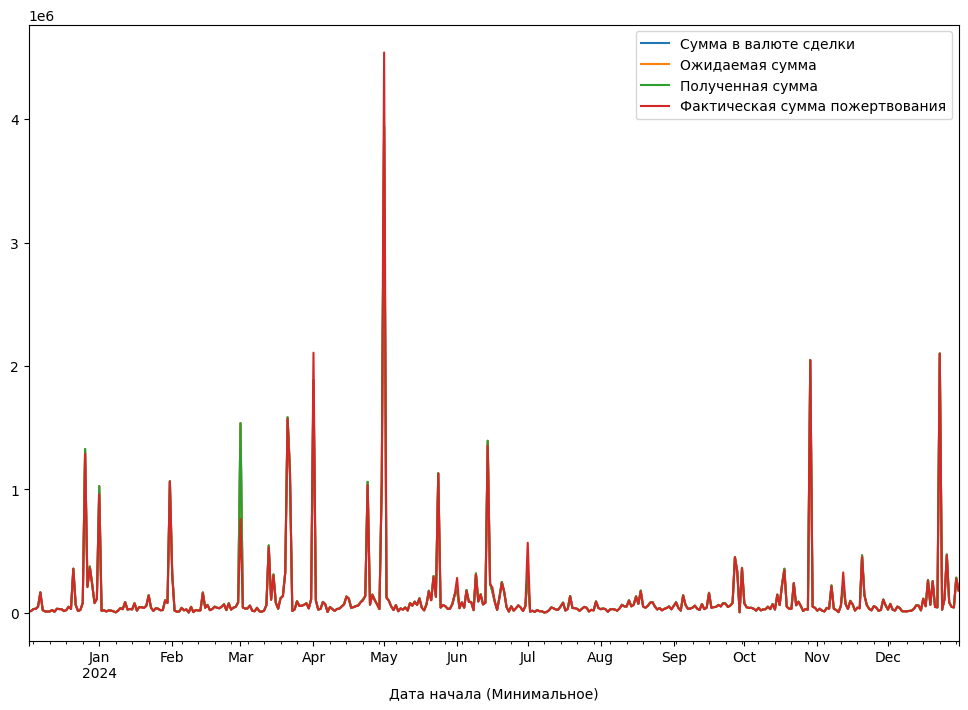

In [44]:
fig = plt.figure(figsize=(12, 8))
dd = rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0 and `Дата начала (Минимальное)` > "2023.12.01"')
for col in ['Сумма в валюте сделки', 'Ожидаемая сумма', 'Полученная сумма', 'Фактическая сумма пожертвования']:
  dd.groupby('Дата начала (Минимальное)')[col].sum().plot(label=col)
plt.legend()
plt.show()

Несколько колонок с суммами: 'Сумма в валюте сделки', 'Полученная сумма', 'Ожидаемая сумма', 'Фактическая сумма пожертвования'. Первые три, как правило, равны. 'Фактическая сумма поступлений' это с минусом комиссии банка или еще чего - по 3% в большинствве транзакций.

Так как мы анализируем поведение пользователей, то удобнее и логичнее работать с "Сумма в валюте сделки"

### Даты

4 колонки связаны с датами транзакций. Надо выбрать, какая их них пойдет в основное исследовние.

In [45]:
rawdata[['Дата начала (Минимальное)', 'Дата создания', 'Дата изменения', 'Датавремя платежа']].describe()

Дата начала (Минимальное)                  Дата создания  \
count                          34355                          34355   
mean   2023-10-31 19:18:29.812254464  2023-11-30 00:43:10.365303552   
min              2017-10-31 00:00:00            2022-08-01 00:00:00   
25%              2023-05-05 00:00:00            2023-05-06 00:00:00   
50%              2023-12-08 00:00:00            2023-12-18 00:00:00   
75%              2024-06-14 00:00:00            2024-06-15 00:00:00   
max              2024-12-31 00:00:00            2025-01-17 00:00:00   

                      Дата изменения              Датавремя платежа  
count                          34355                          30006  
mean   2024-01-09 09:01:55.371852544  2024-01-04 14:29:00.611877632  
min              2022-08-01 00:00:00            2019-09-30 00:00:00  
25%              2023-07-17 00:00:00            2023-07-11 00:00:00  
50%              2024-02-21 00:00:00            2024-01-08 00:00:00  
75%              2024-07-10 00:00:00            2024-06-25 00:00:00  
max              2025-03-13 00:00:00            2024-12-31 00:00:00

In [46]:
rawdata.query('`Датавремя платежа` != `Дата начала (Минимальное)`')\
 [['Стадия сделки', 'В стадии: Удачно',
   'Сумма в валюте сделки', 'Ожидаемая сумма', 'Полученная сумма',
   'Дата начала (Минимальное)', 'Дата создания', 'Дата изменения', 'Датавремя платежа']].head(10)

Стадия сделки В стадии: Удачно  Сумма в валюте сделки  Ожидаемая сумма  \
385    Closed Won               Да                   0.00             0.00   
386    Closed Won               Да                   0.00             0.00   
387    Closed Won               Да                   0.00             0.00   
388    Closed Won               Да                   0.00             0.00   
389    Closed Won               Да                   0.00             0.00   
390    Closed Won               Да                   0.00             0.00   
391    Closed Won               Да                   0.00             0.00   
392    Closed Won               Да                   0.00             0.00   
393    Closed Won               Да                   0.00             0.00   
394    Closed Won               Да                   0.00             0.00   

     Полученная сумма Дата начала (Минимальное) Дата создания Дата изменения  \
385              0.00                2024-04-26    2024-04-26     2024-04-26   
386              0.00                2024-05-05    2024-05-05     2024-05-05   
387              0.00                2024-05-05    2024-05-05     2024-05-05   
388              0.00                2024-05-03    2024-05-03     2024-05-03   
389              0.00                2024-05-03    2024-05-03     2024-05-03   
390              0.00                2024-05-03    2024-05-03     2024-05-03   
391              0.00                2024-05-01    2024-05-01     2024-05-01   
392              0.00                2024-04-29    2024-04-29     2024-04-29   
393              0.00                2024-04-29    2024-04-29     2024-04-29   
394              0.00                2024-04-29    2024-04-29     2024-04-29   

    Датавремя платежа  
385               NaT  
386               NaT  
387               NaT  
388               NaT  
389               NaT  
390               NaT  
391               NaT  
392               NaT  
393               NaT  
394               NaT

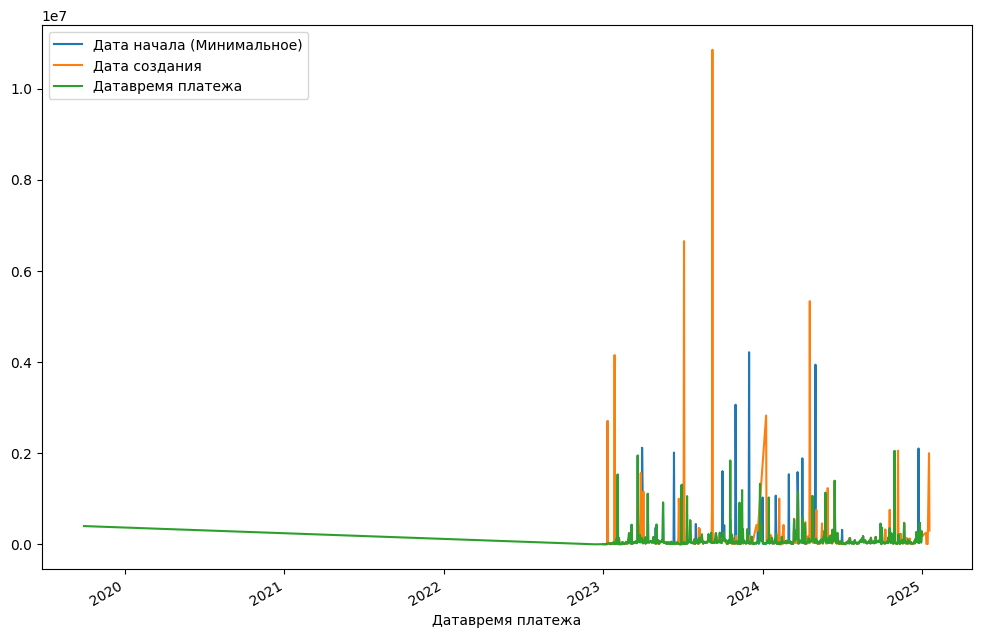

In [47]:
fig = plt.figure(figsize=(12, 8))
dd = rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0 and `Дата начала (Минимальное)` > "2023.01.01"')
for col in ['Дата начала (Минимальное)', 'Дата создания', 'Датавремя платежа']:
  dd.groupby(col)['Сумма в валюте сделки'].sum().plot(label=col)
plt.legend()
plt.show()

Много колонок с датами: Дата начала (Минимальное), Дата создания, Дата изменения, Датавремя платежа - они все отражают разные стадии, условно: дата занесения в CRM, дата выставления счета, дата оплаты, дата фактическое поступление на счет фонда. между ними может быть несколько дней, причем в обе стороны =)

Дата начала (Минимальное) - минимальная из этих дат. Для дальнейшего анализа берем ее

### Категориальные колонки параметров платежа

Смотрим по перспективным колонкам, какие есть значения и сколько их. Берем только успешные транзакции с ненулевой суммой. В приоритете колонки с несколькими значениями, и есть более-менее баланс между количеством каждого значения.

In [48]:
for col in ['Action (строка)', 'Action (ссылка)', 'Сайт - источник',  'SITE_NAME',
            'Название таргета', 'Платежный шлюз', 'Код (список)', 'Код (строка)',
            'Комментарий']:
  print(f'------------- {col} -----------------------')
  display(rawdata.query('`В стадии: Удачно` == "Да" and `Ожидаемая сумма` > 0')[col].value_counts().head(10).to_frame().T)
  print()

------------- Action (строка) -----------------------


Action (строка)  orange2023   th  \
count                  1369  657   

Action (строка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-14-10-2023  \
count                                                                 618   

Action (строка)  jam2024  maple2023  school24  action  elki2025  \
count                515        504       453     433       422   

Action (строка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-25-05-2024  \
count                                                                 395   

Action (строка)  elki2024  
count                 389


------------- Action (ссылка) -----------------------


Action (ссылка)  orange2023   th  \
count                  1368  657   

Action (ссылка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-14-10-2023  \
count                                                                 618   

Action (ссылка)  jam2024  maple2023  school24  action  elki2025  \
count                515        504       453     433       423   

Action (ссылка)  vesenni-blagotvoritelnyy-zabeg-sport-vo-blago-25-05-2024  \
count                                                                 395   

Action (ссылка)  elki2024  
count                 389


------------- Сайт - источник -----------------------


Сайт - источник    sdl   svb  turnonheart    0  thermos  dsu
count            17355  4255          657  433       34   17


------------- SITE_NAME -----------------------


SITE_NAME   sdl  svb  shop  turnonheart  thermos
count      3752  446    95           72        1


------------- Название таргета -----------------------


Название таргета  Широкие потребности ДСА/СЛ  \
count                                     20   

Название таргета  СЛ Пожертвование на программы и уставную  \
count                                                   12   

Название таргета  ДСА Пожертвование на программы и уставную  Забег  \
count                                                     7      4   

Название таргета  Соцмаркетинг  Футбол  Сайклинг  Онлайн-акция ёлки  \
count                        4       3         3                  3   

Название таргета  Онлайн-акция клёны  Онлайн-акция апельсины  
count                              2                       1


------------- Платежный шлюз -----------------------


Платежный шлюз  cloud  Сбербанк СЛ  Сбербанк ДСА  POS_TERM  Cash  \
count           22703         1002           444         4     3   

Платежный шлюз  Райффайзен СЛ  
count                       1


------------- Код (список) -----------------------


Код (список)  f212  f214  f405  f207  f215  f211  f204  f112  f517  f114
count         8290  2708  2500  2339  2251  1773  1705   824   433   398


------------- Код (строка) -----------------------


Код (строка)  f212  f405  f207  f215  f211  f204  f214  f112  f517  f114
count         8238  2528  2210  2103  1773  1707  1540   820   433   401


------------- Комментарий -----------------------


Комментарий  Ежемесячное пожертвование в БФ "Синдром любви"  \
count                                                  8779   

Комментарий  Разовое пожертвование в БФ "Синдром любви"  \
count                                              4292   

Комментарий  Поддержать соревнование  \
count                           2320   

Комментарий  Благотворительный забег «СПОРТ ВО БЛАГО»  \
count                                              998   

Комментарий  Пожертвование в рамках акции «Апельсины», 590  \
count                                                  489   

Комментарий  Пожертвование в рамках акции «Апельсины», 280  \
count                                                  482   

Комментарий  Благотворительный забег «СПОРТ ВО БЛАГО»  \
count                                             424   

Комментарий  Разовое пожертвование в рамках акции «Новогодний подарок!», 280  \
count                                                                    269   

Комментарий  Благотворительный осенний забег «СПОРТ ВО БЛАГО»  \
count                                                      247   

Комментарий  Разовое пожертвование в рамках акции «Особенное варенье!», 300  
count                                                                   216

Отдельно посмотрим колонки с двумя уникальными значениям - видимо, логическими Да/Нет. Выбираем колонки, в которых доля меньшего значения хотя бы больше 5%.

In [49]:
check_bool_col(rawdata)

[30410, 3945] 	 11.5% 	 В стадии: В работе
[25230, 9125] 	 26.6% 	 В стадии: Удачно
[29175, 5180] 	 15.1% 	 В стадии: Не удачно
[30410, 3945] 	 11.5% 	 Сделка закрыта
[23607, 10748] 	 31.3% 	 Повторная сделка
[4, 1] 	 20.0% 	 UTM Term
[32081, 2274] 	 6.6% 	 ВИД платежа


Для дальнейшего анализа берем:

- Сайт - источник
- Код (список)
- Комментарий
- Action (строка)

### Категориальные колонки портрета пользователей

In [50]:
for col in ['Контакт: Источник', 'Контакт: Источник контакта', 'Контакт: Целевая группа',
            'Контакт: Сегмент', 'Контакт: Новый донор тип', 'Контакт: Пол']:
  print(f'------------- {col} -----------------------')
  display(kontact[col].value_counts().head(10).to_frame().T)
  print()

------------- Контакт: Источник -----------------------


Контакт: Источник  Cloudpayments  Загрузка из файла  Существующий клиент  \
count                       6661               3250                  815   

Контакт: Источник  Подписка на новости на сайте СЛ  Исходящий звонок  \
count                                           25                18   

Контакт: Источник  CRM-форма  Мероприятие  Исходящее электронное письмо  \
count                      9            4                             2   

Контакт: Источник  Реестры Сбербанк  Входящее письмо  
count                             1                1


------------- Контакт: Источник контакта -----------------------


Контакт: Источник контакта  Other  Meropr  OurFamily  от друзей  Manasov  \
count                         213     162         15          8        6   

Контакт: Источник контакта  Employee  профильные сайты  Web Site  SMI  \
count                              6                 5         5    3   

Контакт: Источник контакта  директор фонда  
count                                    2


------------- Контакт: Целевая группа -----------------------


Контакт: Целевая группа  donor  prospective
count                      434           61


------------- Контакт: Сегмент -----------------------


Контакт: Сегмент  Активный   Нет  Уснувший  Потерянный
count                 7032  2184      1822         140


------------- Контакт: Новый донор тип -----------------------


Контакт: Новый донор тип  WL СЛ   СВБ  DSU  WL elki корп  \
count                      5023  2795  454           162   

Контакт: Новый донор тип  WL СЛ новые родители  \
count                                      159   

Контакт: Новый донор тип  WL CЛ новые пользователи портала ДСА  WL СЛ ВИД  \
count                                                       72         64   

Контакт: Новый донор тип  WL CЛ новые родители  WL SL  \
count                                       60     57   

Контакт: Новый донор тип  First donation prospecting  
count                                             46


------------- Контакт: Пол -----------------------


Контакт: Пол     Ж     0     М
count         4889  3136  2165

Отдельно посмотрим колонки с двумя уникальными значениям - видимо, логическими Да/Нет. Выбираем колонки, в которых доля меньшего значения хотя бы больше 5%.

In [51]:
check_bool_col(kontact)

[7, 5] 	 41.7% 	 Контакт: Готовность стать интегративным волонтером
[7, 5] 	 41.7% 	 Контакт: Готовность стать волонтером-сопровождающим
[8, 4] 	 33.3% 	 Контакт: Я не против добавления в чат волонтеров
[434, 61] 	 12.3% 	 Контакт: Целевая группа
[9068, 2112] 	 18.9% 	 Контакт: ЭН
[10543, 637] 	 5.7% 	 Контакт: ЭН-корпоратив
[10323, 857] 	 7.7% 	 Контакт: Участник мероприятия
[10241, 939] 	 8.4% 	 Контакт: Родитель ДСА
[10337, 843] 	 7.5% 	 Контакт: Регулярные списания остановлены
[9921, 1259] 	 11.3% 	 Контакт: ВИД
[2324, 1190] 	 33.9% 	 Контакт: Сегментация Рекуррент
[9990, 1190] 	 10.6% 	 Контакт: Сегментация Рекуррент Флажок
[10133, 1047] 	 9.4% 	 Контакт: Служебное: Unisender.Контакт.F207
[10148, 1032] 	 9.2% 	 Контакт: Служебное: Welcome не Донор отправлен
[6464, 4716] 	 42.2% 	 Контакт: Служебное: Welcome донор отправлен


Для дальнейшего анализа берем

- Контакт: Источник контакта
- Контакт: пол
- Контакт: регион
- Контакт: город
- Контакт: Новый донор тип
- Контакт: ВИД
- Контакт: ЭН

## Пересечения таблиц компаний и контактов

Успешные транзакции без user_id, но с comp_id

In [52]:
print(len(rawdata.query('~comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')))
print(rawdata.query('~comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')['Сумма в валюте сделки'].sum())

159
11508704.0


Есть транзакции без указателя на пользователя, но с указанием на компанию. Таких донатов мало, но сумма приличная - надо это учитывать

Успешные транзакции без user_id и без comp_id

In [53]:
print(len(rawdata.query('comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')))
print(rawdata.query('comp_id.isna() and user_id.isna() and `В стадии: Удачно` == "Да"')['Сумма в валюте сделки'].sum())

12
9290.8


Есть транзакции без указателя на пользователя или компанию... К счастью их мало.

**Промежуточные итоги:**

Провели разведочный анализ данных. По его итогам берем для дальнейшего анализа колонки:

'ID', 'Дата начала (Минимальное)', 'Сумма в валюте сделки', 'Контакт: ID', 'Комментарий', 'Сайт - источник', 'Action (строка)', 'Код (список)', а также 'Контакт: Регион_', 'Контакт: город',  'Контакт: Пол', 'Контакт: Источник контакта', 'Контакт: Новый донор тип', 'Контакт: ВИД', 'Контакт: ЭН'.


Также выявлены транзакции без указателя на пользователя, но с указанием на компанию. Это надо учесть при формировании датасета для осноного анализа

In [54]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:08:34.681329+04:00
 От начала рассчета прошло 0:00:06.027101


#Датасеты для основного анализа

Основной анализ проведем на свежих данных только за 2023-2024 годы, так как паттерны поведения в современном мире быстро меняются, и практики привлечения и удержания жертводателей, бывшие успешными более 2-3 лет назад, сейчас могут уже не сработать.

Берем только транзакции, за заданный именем файла период, которые завершились успешнно с ненулевой суммой и указанным user_id.

In [55]:
all = 0
rawdt = pd.DataFrame([])
for ff in os.listdir(path):
  filename, fileexp = os.path.splitext(ff)
  if fileexp == '.csv':
    min_date = pd.to_datetime(filename.split('-')[0], format='%d.%m.%Y')
    max_date = pd.to_datetime(filename.split('-')[1], format='%d.%m.%Y')
    #print(filename, min_date, max_date)
    dd = pd.read_csv(path + ff)
    dd['file'] = ff
    l = len(dd)
    all = all + l
    #Заполняем пропуски в `Контакт: ID` значенеим `Компания: ID` + 1000000
    dd['Компания: ID'] = dd['Компания: ID'].fillna(0)
    dd['Контакт: ID'] = dd['Контакт: ID'].fillna(dd['Компания: ID'] + 1000000)
    dd['Дата начала (Минимальное)'] = pd.to_datetime(dd['Дата начала (Минимальное)'], format='%d.%m.%Y')
    dd['Сумма в валюте сделки'] = dd['Сумма в валюте сделки']\
        .str.replace(' ', '')\
        .str.replace('\xa0','').astype('float')
    dd = dd.query('`Дата начала (Минимальное)` >= @min_date\
            and `Дата начала (Минимальное)` <= @max_date\
            and `Сумма в валюте сделки` > 0\
            and `В стадии: Удачно` == "Да"\
            and `Контакт: ID` > 0')
    rawdt = pd.concat([rawdt, dd])
    print(f'Загрузка {l} строк данных из файла {ff}')

print(f'Всего загружено {all} строк')
rawdt = rawdt.sort_values(by='Дата начала (Минимальное)').reset_index(drop=True)

Загрузка 8928 строк данных из файла 01.01.2024-30.06.2024.csv
Загрузка 7930 строк данных из файла 01.01.2023-30.06.2023.csv
Загрузка 8917 строк данных из файла 01.07.2023-31.12.2023.csv
Загрузка 8580 строк данных из файла 01.07.2024-31.12.2024.csv
Всего загружено 34355 строк


In [56]:
rawdt.head(5)

ID  Название (Количество уникальных)  \
0  332345                              1.00   
1  332379                              1.00   
2  332377                              1.00   
3  332365                              1.00   
4  332363                              1.00   

   Стадия сделки (Количество уникальных)  \
0                                   1.00   
1                                   1.00   
2                                   1.00   
3                                   1.00   
4                                   1.00   

   Ответственный (Количество уникальных) Дата начала (Минимальное)  \
0                                   1.00                2023-01-01   
1                                   1.00                2023-01-01   
2                                   1.00                2023-01-01   
3                                   1.00                2023-01-01   
4                                   1.00                2023-01-01   

                                      Комментарий Направление сделки  \
0      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   
1      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   
2      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   
3  Ежемесячное пожертвование в БФ "Синдром любви"      Пожертвования   
4      Разовое пожертвование в БФ "Синдром любви"      Пожертвования   

  Стадия сделки В стадии: В работе В стадии: Удачно  ... SITE_NAME  \
0        Posted                Нет               Да  ...       NaN   
1        Posted                Нет               Да  ...       NaN   
2        Posted                Нет               Да  ...       NaN   
3        Posted                Нет               Да  ...       NaN   
4        Posted                Нет               Да  ...       NaN   

  Тип пожертвования Источник пожертвования  Мероприятие Дата рождения ребенка  \
0               NaN                    NaN          NaN                   NaN   
1               NaN                    NaN          NaN                   NaN   
2               NaN                    NaN          NaN                   NaN   
3               NaN                    NaN          NaN                   NaN   
4               NaN                    NaN          NaN                   NaN   

  Информация о родстве Служебное: Copy ID Служебное: Таргеты: Цикл ожидания  \
0                  NaN          332345.00                               Нет   
1                  NaN          332379.00                               Нет   
2                  NaN          332377.00                               Нет   
3                  NaN          332365.00                               Нет   
4                  NaN          332363.00                               Нет   

                        file  \
0  01.01.2023-30.06.2023.csv   
1  01.01.2023-30.06.2023.csv   
2  01.01.2023-30.06.2023.csv   
3  01.01.2023-30.06.2023.csv   
4  01.01.2023-30.06.2023.csv   

   Контакт: Аналитика:Количество пожертвований за этот ФИНАНСОВЫЙ год (1 июля-30 июня)  
0                                                                                 4.00  
1                                                                                 0.00  
2                                                                                 6.00  
3                                                                                 6.00  
4                                                                                 1.00  

[5 rows x 229 columns]

## Строим таблицу транзакций

Берем только нужные для дальнейшего анализа колонки

In [57]:
tranz = rawdt[['ID', 'Дата начала (Минимальное)', 'Контакт: ID', 'Компания: ID',
               'Сумма в валюте сделки',
               'Комментарий', 'Сайт - источник', 'Action (строка)', 'Код (список)',
               'Контакт: Регион_', 'Контакт: Город_', 'Контакт: Пол', 'Контакт: ЭН',
               'Контакт: Источник контакта', 'Контакт: Новый донор тип', 'Контакт: ВИД']].copy()
tranz = tranz.drop_duplicates()
tranz = tranz.reset_index(drop=True)
tranz.columns = ['id', 'date', 'user_id', 'comp_id', 'donate', 'comment', 'site',  'action', 'code',
                 'region', 'city', 'gender', 'en', 'source', 'donor_type', 'vid']

Преобразуем типы, добавляем "усеченные" даты

In [58]:
tranz['user_id'] = tranz['user_id'].astype('int')
tranz['comp_id'] = tranz['comp_id'].astype('int')
tranz['tr_m'] = tranz['date'].dt.month
tranz['tr_y'] = tranz['date'].dt.year
tranz['tr_ym'] = (tranz['tr_y'] - tranz['tr_y'].min()) * 12 + tranz['tr_m']
tranz['tr_month'] = tranz.apply(lambda row: f"{row['tr_y']}_{str(row['tr_m']):0>2}", axis=1)

Заполняем пропуски заглушкой 'Не указано'

In [59]:
tranz['site'] = tranz['site'].fillna('Не указано')
tranz['gender'] = tranz['gender'].fillna('Не указано')
tranz['code'] = tranz['code'].fillna('Не указано')
tranz['comment'] = tranz['comment'].fillna('Не указано')
tranz['action'] = tranz['action'].fillna('Не указано')

tranz['gender'] = tranz['gender'].fillna('Не указано')
tranz['city'] = tranz['city'].fillna('Не указано')
tranz['region'] = tranz['region'].fillna('Не указано')
tranz['donor_type'] = tranz['donor_type'].fillna('Не указано')
tranz['source'] = tranz['source'].fillna('Не указано')


Заполняем непонятные значения заглушкой 'Не указано'

In [60]:
tranz['site'] = tranz['site'].replace({'0' : 'Не указано'})
tranz['gender'] = tranz['gender'].replace({'0' : 'Не указано'})

Приводим дубли в категориальных колонках к единому виду

In [61]:
tranz['city'] = tranz['city'].replace(r'.*Моск.*', 'Москва', regex=True)
tranz['city'] = tranz['city'].str.replace(r'^г.', '', regex=True)\
    .str.replace(r'^д.', '', regex=True).str.replace(r'^пос.', '', regex=True)\
    .str.replace(r'^п.', '', regex=True).str.replace(r'^с.', '', regex=True)\
    .str.replace(r'^c.', '', regex=True).str.replace(r'^ст.', '', regex=True)\
    .str.strip()

tranz['region'] = tranz['region'].replace(r'.*Моск.*', 'Москва', regex=True)

In [62]:
tranz['comment'] = tranz['comment'].str.strip()\
  .replace({'Благотворительный забег «СПОРТ ВО БЛАГО»' : 'Благотворительный забег «СПОРТ ВО БЛАГО»'})

Словарь для кодов

In [63]:
codelib = {'210' : 'Сборы на сторонних площадках (Вклад в будущее, Мэйлру, Нужна помощь и пр.)',
'211' : 'Частные доноры Рассылки',
'212' : 'Частные доноры Регулярные пожертвования',
'214' : 'Разовые пожертвования картой через сайт, ящики в фонде',
'215' : 'пожертвования через СМС и спец ссылки',
'216' : 'Телемаркетинг',
'111' : 'ВИД Рассылки',
'112' : 'ВИД Регулярные списания',
'109' : 'ВИД (юрид. лица)',
'114' : 'ВИД массовые акции',
'208' : 'ВИД Мероприятия',
'209' : 'ВИД пожертвования',
'101' : 'Партнер велосотни',
'102' : 'Партнеры футбол',
'104' : 'Партнеры пробега и трейла',
'105' : 'Корпоративные пожертвования на программы',
'405' : 'Социальный маркетинг, пожертвования сотрудников (кроме АВБ)',
'201' : 'СВБ инд. учстники велосотня',
'204' : 'СВБ инд. учстники пробег и рейл',
'207' : 'АВБ',
'306' : 'Гранты, субсидии',
'517' : 'Магазин',
'519' : 'Консультационная деятельность',
'103' : 'Партнер(ы) лыжи',
'106' : 'Корпоративные гранты на программы',
'107' : 'Проекты корпоративных партнеров (спорт и не спорт) с потенциалом увеличения базы частных доноров',
'203' : 'СВБ инд. учстники лыжи',
'305' : 'Событийный фандрайзинг',
'401' : 'Внутренний корпоративный фандрайзинг по велосотне',
'402' : 'Внутренний корпоративный фандрайзинг по футболу',
'403' : 'Внутренний корпоративный фандрайзинг по лыжам',
'404' : 'Внутренний корпоративный фандрайзинг по пробегу и трейлу'}

tranz['code'] = tranz['code'].replace(codelib, regex=True).str.replace('f', '')

In [64]:
tranz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22152 entries, 0 to 22151
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   id          22152 non-null  int64         
 1   date        22152 non-null  datetime64[ns]
 2   user_id     22152 non-null  int64         
 3   comp_id     22152 non-null  int64         
 4   donate      22152 non-null  float64       
 5   comment     22152 non-null  object        
 6   site        22152 non-null  object        
 7   action      22152 non-null  object        
 8   code        22152 non-null  object        
 9   region      22152 non-null  object        
 10  city        22152 non-null  object        
 11  gender      22152 non-null  object        
 12  en          22152 non-null  object        
 13  source      22152 non-null  object        
 14  donor_type  22152 non-null  object        
 15  vid         22152 non-null  object        
 16  tr_m        22152 non-

In [65]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:08:41.780809+04:00
 От начала рассчета прошло 0:00:13.126106


Выделяем в отдельную таблицу корпоративных жертводателей, чтобы они не искажали патерны поведения частных пользоватлей

In [66]:
corp = tranz.query('comp_id != 0').copy()
corp = corp.reset_index(drop=True)
tranz = tranz.query('comp_id == 0').copy()
tranz = tranz.reset_index(drop=True)

## Строим таблицу пользователей на основе транзакций

In [67]:
user_table = get_user_table(tranz)
user_table.head(5)

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  
0        2023         8      46         2       1.50  Простой       448  
1        2023         4       0         1       1.00  Разовый       622  
2        2023        12       0         1       1.00  Разовый       389  
3        2023         6       0         1       1.00  Разовый       571  
4        2023         5       0         1       1.00  Разовый       593

In [68]:
seg_users = dict()
seg_users['Подписчик'] = user_table.query('type == "Подписчик"')['user_id'].unique()
seg_users['Простой'] = user_table.query('type == "Простой"')['user_id'].unique()
seg_users['Разовый'] = user_table.query('type == "Разовый"')['user_id'].unique()
seg_users

{'Подписчик': array([334737, 341075, 341879, 342153, 342193, 342517, 342679, 342701,
        343285, 343517, 343691, 343713, 343717, 343741, 343745, 343747,
        343749, 343755, 343759, 343829, 343869, 343989, 344123, 344223,
        345543, 346425, 346713, 347029, 347157, 347209, 347363, 347511,
        347549, 347689, 347797, 348057, 348315, 348363, 348471, 348967,
        349191, 349215, 349561, 349663, 350131, 350253, 350255, 350257,
        350261, 350263, 350269, 350271, 350273, 350275, 350277, 350283,
        350285, 350289, 350291, 350293, 350295, 350305, 350311, 350317,
        350319, 350323, 350325, 350327, 350333, 350335, 350337, 350339,
        350341, 350347, 350351, 350353, 350355, 350359, 350361, 350363,
        350367, 350373, 350377, 350381, 350383, 350385, 350389, 350391,
        350393, 350395, 350397, 350399, 350405, 350409, 352999, 353377,
        357861, 358527, 359199, 359559, 359973, 364063, 366625, 377701,
        387175, 393153, 394257, 396945, 397431, 398

**Промежуточные итоги:**

Сформировали таблицу транзакций на основе исходного датасета, взяв из него данные только из выбранных колонок. Преобразовали типы данных, заполнили пропуски "заглушками", исправлии закодмированные значения. На основе таблицы транзакций построили таблицу пользователей с необходимыми метриаками по каждому пользователю.

In [69]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:08:42.696383+04:00
 От начала рассчета прошло 0:00:14.041666


# Метрики и графики

In [70]:
period = (tranz['date'].max() - tranz['date'].min()).days
tr_all = tranz['id'].count()
donate_all = tranz['donate'].sum()
user_all = tranz['user_id'].nunique()

comp_all = corp['comp_id'].nunique()
comp_tr = corp['id'].count()
comp_users = corp['user_id'].nunique()
comp_sum = corp['donate'].sum()

donate_mean = tranz['donate'].mean()
donate_median = tranz['donate'].median()
oper_frec_mean = user_table.query('day_on > 0')['oper_frec'].mean()

#regul_users = tranz.query('comment.str.contains("Ежемесячное пожертвование")')['user_id'].unique()
regul_users = seg_users["Подписчик"]
regul_users_donate = tranz.query('user_id.isin(@regul_users)')['donate'].sum()

#not_regul_not_one_users = user_table.query('~user_id.isin(@regul_users) and day_on > 0')['user_id'].unique()
not_regul_not_one_users = seg_users["Простой"]
not_regul_users_donate = user_table.query('user_id.isin(@not_regul_not_one_users)')['donate_sum'].sum()

new_user_day = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count()['user_id'].mean()
day_on_mean = user_table.query('day_on > 0')['day_on'].mean()

#day_on_zero = user_table.query('day_on == 0')['user_id'].unique()
day_on_zero = seg_users["Разовый"]
day_on_zero_donate = user_table.query('day_on == 0')['donate_sum'].sum()

tr_count_mean = user_table['tr_count'].mean()
tr_count_median = user_table['tr_count'].median()
tr_count_mean_reg = user_table.query('day_on > 0')['tr_count'].mean()

code_tr = tranz.query('code != "Не указано"')['id'].count()
comment_tr = tranz.query('comment != "Не указано"')['id'].count()
action_tr = tranz.query('action != "Не указано"')['id'].count()

print(f"Период {tranz['date'].min()} - {tranz['date'].max()}")

print(50*'-')
print(f"Общая количество успешных транзакций {tr_all}")
print(f"Общая сумма донатов {donate_all:,.0f} руб.".replace(',', ' '))
print(f"Общее количество пользователей {user_all}")

print(50*'-')
print(f"Общее количество компаний {comp_all}")
print(f"Общее количество пользователей из компаний {comp_users}")
print(f"Общее количество донатов из компаний {comp_tr}")
print(f"Общее сумма донатов из компаний {comp_sum:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Количество ежемесяных донаторов (подписчики) {len(regul_users)} ({len(regul_users) / user_all:.2%})")
print(f"Количество разовых донаторов {len(day_on_zero)} ({len(day_on_zero) / user_all:.2%})")
print(f"Количество сделавших более 1 пожертвования пользователей без подписки {len(not_regul_not_one_users)} ({len(not_regul_not_one_users) / user_all:.2%})")

print(50*'-')
print(f"Общая сумма донатов от подписчиков {regul_users_donate:,.0f} руб.".replace(',', ' '))
print(f"Общая сумма донатов от разовых донаторов {not_regul_users_donate:,.0f} руб.".replace(',', ' '))
print(f"Общая сумма донатов от сделавших более 1 пожертвования без пидписки {day_on_zero_donate:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Среднее количечство донатов в день {tr_all / period:.0f}")
print(f"Среднее количество новых пользователей в день {new_user_day:.0f}")
print(f"Средняя сумма донатов в день {donate_all / period:,.0f} руб.".replace(',', ' '))

print(50*'-')
print(f"Средняя сумма донатов на пользователя {donate_all / user_all:.0f} руб.")
print(f'Среднее количество транзакций на пользователя {tr_count_mean:.0f}')
print(f'Медианное количество транзакций на пользователя {tr_count_median:.0f}')

print(50*'-')
print(f'Средняя сумма одного доната {donate_mean:.0f} руб.')
print(f'Медианная сумма одного доната {donate_median:.0f} руб.')

print(50*'-')
print(f'Среднее время жизни пользователя {day_on_mean:.0f} дней (исключая разовых)')
print(f'Среднее количество транзакций на пользователя {tr_count_mean_reg:.0f} (исключая разовых)')
print(f'Средняя частота донатов {oper_frec_mean:.2f} (транзакций в месяц, исключая разовых)')

print(50*'-')
print(f"Доля транзакций с кодом {code_tr / tr_all:.2%}")
print(f"Доля транзакций с комментом {comment_tr / tr_all:.2%}")
print(f"Доля транзакций с меткой в ссылке {action_tr / tr_all:.2%}")

Период 2023-01-01 00:00:00 - 2024-12-31 00:00:00
--------------------------------------------------
Общая количество успешных транзакций 21974
Общая сумма донатов 46 610 326 руб.
Общее количество пользователей 8610
--------------------------------------------------
Общее количество компаний 36
Общее количество пользователей из компаний 39
Общее количество донатов из компаний 178
Общее сумма донатов из компаний 23 566 818 руб.
--------------------------------------------------
Количество ежемесяных донаторов (подписчики) 567 (6.59%)
Количество разовых донаторов 6511 (75.62%)
Количество сделавших более 1 пожертвования пользователей без подписки 1532 (17.79%)
--------------------------------------------------
Общая сумма донатов от подписчиков 10 484 931 руб.
Общая сумма донатов от разовых донаторов 17 696 008 руб.
Общая сумма донатов от сделавших более 1 пожертвования без пидписки 18 458 856 руб.
--------------------------------------------------
Среднее количечство донатов в день 30
Сре

## Динамика донатов и пользователей по дням

In [71]:
day_dynamik = tranz.groupby('date').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
day_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
day_dynamik['d_cumsum'] = day_dynamik['donate_sum'].cumsum()
day_dynamik['date'] = pd.to_datetime(day_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

day_dynamik['u_newcount'] = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count()
day_dynamik['u_cumcount'] = tranz[['date','user_id']].drop_duplicates(['user_id']).groupby('date').count().cumsum()
day_dynamik['u_cumcount'] = day_dynamik['u_cumcount'].ffill()

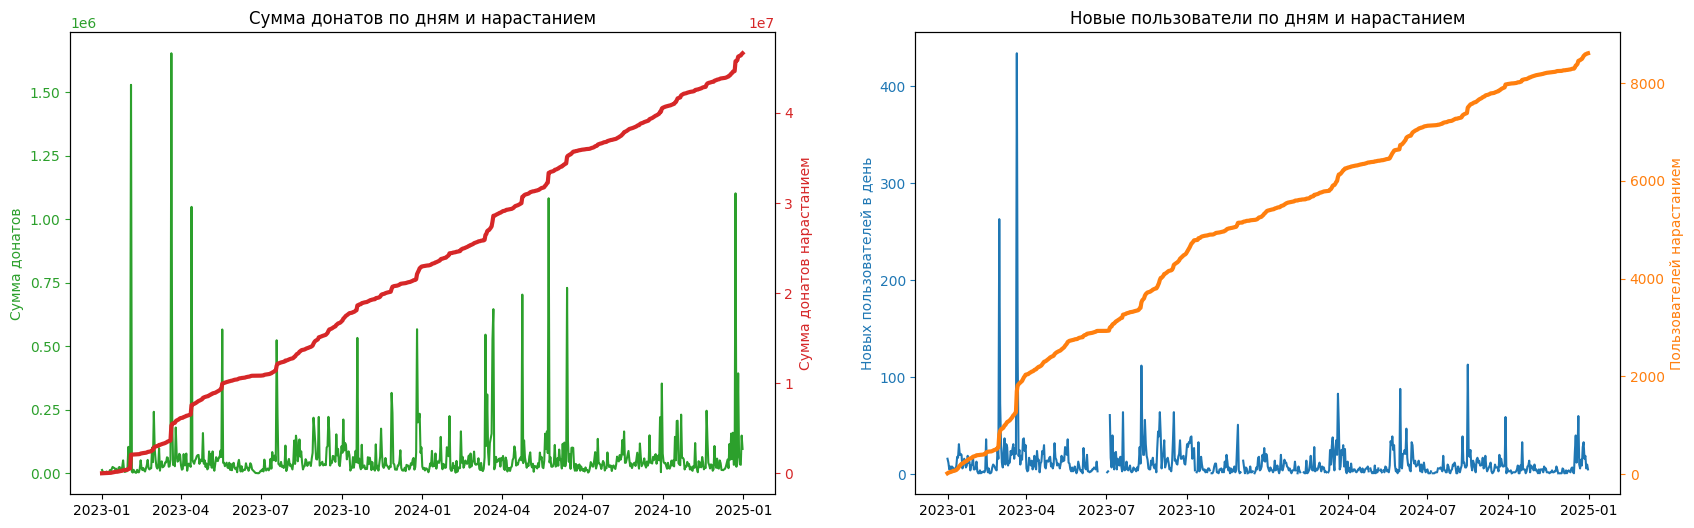

In [72]:
f, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(day_dynamik['date'], day_dynamik['donate_sum'],  color='tab:green')
ax[0].set_ylabel('Сумма донатов', color='tab:green')
ax[0].tick_params(axis='y', colors='tab:green')
ax02 = ax[0].twinx()
ax02.plot(day_dynamik['date'], day_dynamik['d_cumsum'], color='tab:red', linewidth = 3)
ax02.set_ylabel('Сумма донатов нарастанием', color='tab:red')
ax02.tick_params(axis='y', colors='tab:red')
ax[0].set_title('Сумма донатов по дням и нарастанием')


ax[1].plot(day_dynamik['date'], day_dynamik['u_newcount'], color='tab:blue')
ax[1].set_ylabel('Новых пользователей в день', color='tab:blue')
ax[1].tick_params(axis='y', colors='tab:blue')
ax12 = ax[1].twinx()
ax12.plot(day_dynamik['date'], day_dynamik['u_cumcount'], color='tab:orange', linewidth = 3)
ax12.set_ylabel('Пользователей нарастанием', color='tab:orange')
ax12.tick_params(axis='y', colors='tab:orange')
ax[1].set_title('Новые пользователи по дням и нарастанием')

plt.show()

Из дневных графиков видно, что поступление донатов имеет "импульсный" характер. При этом в накопительном графике не видно продолжительных "полочек". То есть какой-то объем донатов поступают регулярно, но в осноном средства поступают как бы импульсами - очевидно, после каких-либо акций и меропритий.

## Даты, в которые было сделано большое количество пожертвований

In [73]:
day_dynamik.query('tr_count > 100')

date  tr_count  donate_sum  donate_mean  user_count  \
date                                                                   
2023-03-01 2023-03-01       300   242136.00       807.12         294   
2023-03-21 2023-03-21       486  1654026.00      3403.35         476   
2023-03-22 2023-03-22       137   206831.00      1509.72         134   
2023-07-20 2023-07-20       154   227994.98      1480.49         153   
2023-08-10 2023-08-10       137   148130.00      1081.24         132   
2023-08-14 2023-08-14       113   133260.00      1179.29         113   
2023-10-14 2023-10-14       102    63870.00       626.18          95   
2023-11-28 2023-11-28       114   237259.00      2081.22         113   
2024-03-21 2024-03-21       152   527800.00      3472.37         150   
2024-05-31 2024-05-31       151   111650.00       739.40         114   
2024-08-16 2024-08-16       168   131058.00       780.11         154   
2024-09-28 2024-09-28       133   220950.00      1661.28         123   

              d_cumsum  u_newcount  u_cumcount  
date                                            
2023-03-01  2839431.99      263.00      811.00  
2023-03-21  5305454.99      434.00     1698.00  
2023-03-22  5512285.99      119.00     1817.00  
2023-07-20 12165090.15       64.00     3261.00  
2023-08-10 13115812.20      112.00     3513.00  
2023-08-14 13494982.21       56.00     3651.00  
2023-10-14 17893653.84       33.00     4825.00  
2023-11-28 20708470.84       51.00     5139.00  
2024-03-21 27936409.84       83.00     6079.00  
2024-05-31 33679513.84       88.00     6732.00  
2024-08-16 37618974.84      113.00     7500.00  
2024-09-28 40125831.84       59.00     7972.00

Даты, в которые было сделано большое количество пожертвований. Овечвидно, это даты после наиболее успешных акций и меропритий. Из таблицы видно, что "шлефа" поступлений донатов на еще один-два дня после акций - практически никогда нет.

## Динамика донатов и пользователей по месяцам

In [74]:
month_dynamik = tranz.groupby('tr_month').agg({'date' : 'min', 'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
month_dynamik.columns = ['date', 'tr_count', 'donate_sum', 'donate_mean', 'user_count']
month_dynamik['d_cumsum'] = month_dynamik['donate_sum'].cumsum()
month_dynamik['date'] = pd.to_datetime(month_dynamik['date'], format = '%Y-%m-%d', errors = 'coerce')

month_dynamik['u_newcount'] = tranz[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count()
month_dynamik['u_cumcount'] = tranz[['tr_month','user_id']].drop_duplicates(['user_id']).groupby('tr_month').count().cumsum()
month_dynamik['u_cumcount'] = month_dynamik['u_cumcount'].ffill()


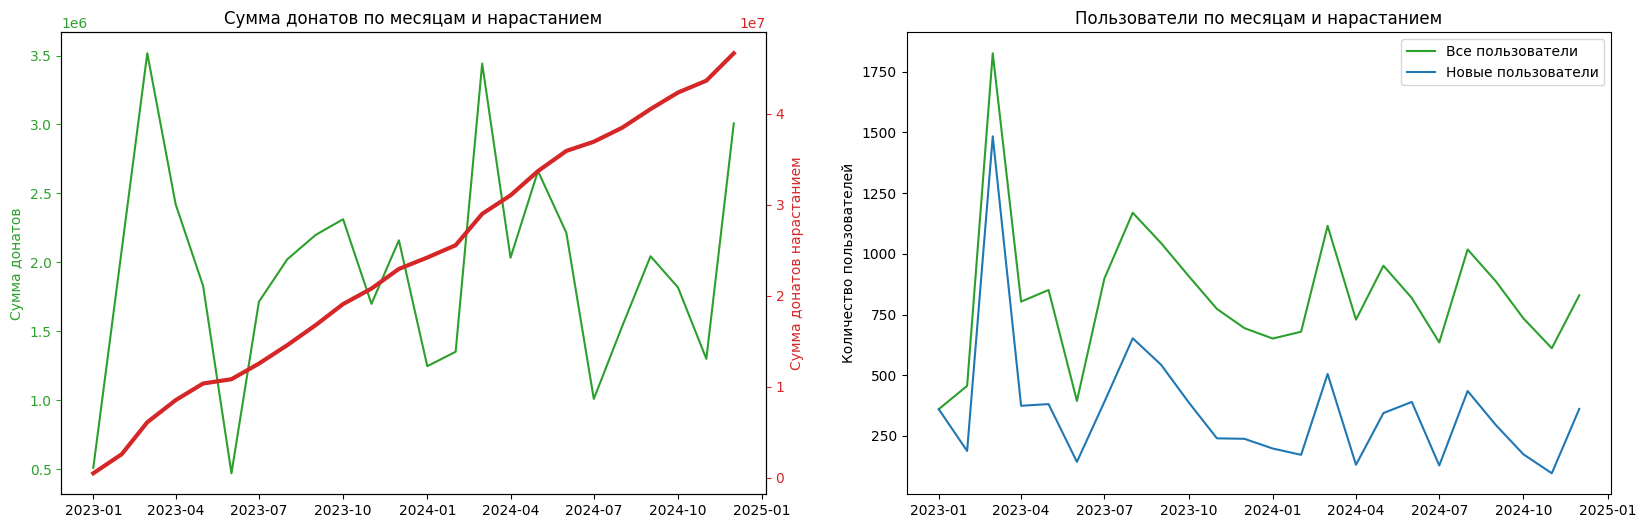

In [75]:
f, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].plot(month_dynamik['date'], month_dynamik['donate_sum'],  color='tab:green')
ax[0].set_ylabel('Сумма донатов', color='tab:green')
ax[0].tick_params(axis='y', colors='tab:green')
ax02 = ax[0].twinx()
ax02.plot(month_dynamik['date'], month_dynamik['d_cumsum'], color='tab:red', linewidth = 3)
ax02.set_ylabel('Сумма донатов нарастанием', color='tab:red')
ax02.tick_params(axis='y', colors='tab:red')
ax[0].set_title('Сумма донатов по месяцам и нарастанием')

ax[1].plot(month_dynamik['date'], month_dynamik['user_count'], color='tab:green', label='Все пользователи')
ax[1].plot(month_dynamik['date'], month_dynamik['u_newcount'], color='tab:blue', label='Новые пользователи')
ax[1].set_ylabel('Количество пользователей')
#ax[1].tick_params(axis='y', colors='tab:blue')
#ax12 = ax[1].twinx()
#ax12.plot(month_dynamik['date'], month_dynamik['u_cumcount'], color='tab:orange', linewidth = 3, label='Клиентская база')
#ax12.set_ylabel('Пользователей нарастанием', color='tab:orange')
#ax12.tick_params(axis='y', colors='tab:orange')
ax[1].set_title('Пользователи по месяцам и нарастанием')
ax[1].legend()
plt.show()

Динамика посутплений по месяцам показывает колебания постулпений донатов, которое хорошо соотносится с календарем успешный акций. Это в 2023 это март, июль, август, октябрь и ноябрь, а в 2024 - март, май, август, сентябрь. Нет акции - поступления донатов падаю.

Приток новых жертводателей вполне вписывается в эти тренды, и практически повторяет график динамики всех донаторов.

# Самые-самые донаты

## Наболее часто встречающиеся суммы донатов и количество донатов на человека

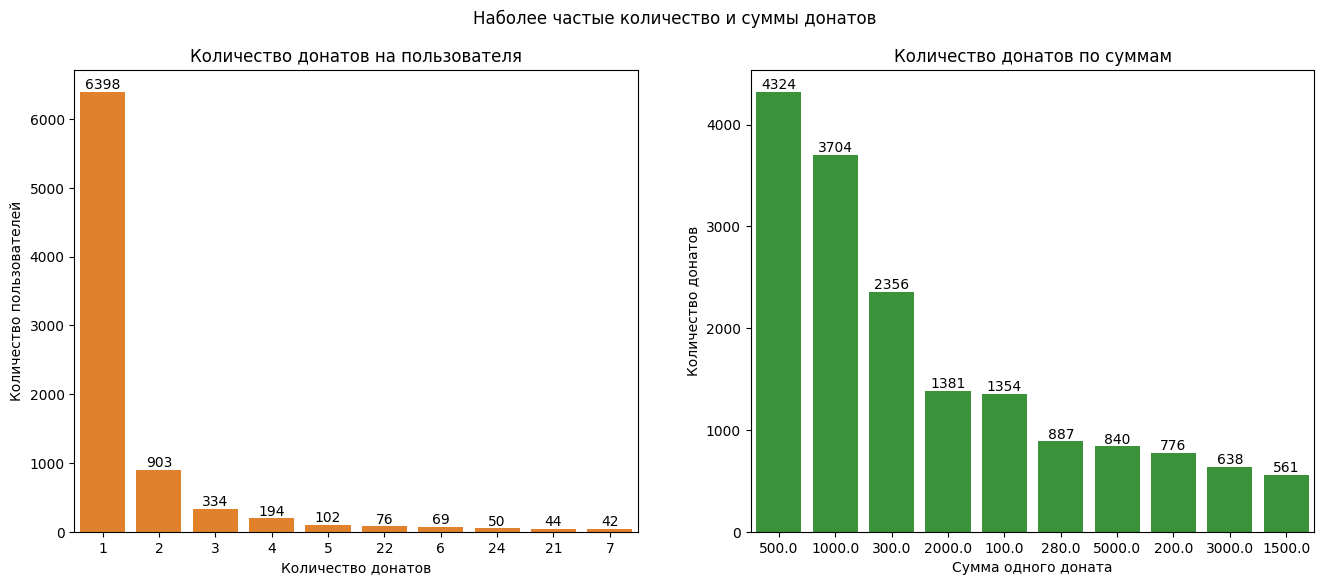

In [76]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.query('comp_id == 0').groupby('user_id')['id'].count().value_counts().head(10)
dd.index = dd.index.map(str)
sns.barplot(y=dd, x=dd.index, color='tab:orange', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')

ax[0].tick_params(axis='x', labelrotation = 0)
ax[0].set_xlabel('Количество донатов')
ax[0].set_ylabel('Количество пользователей')
ax[0].set_title('Количество донатов на пользователя')

dd = tranz.query('comp_id == 0')['donate'].value_counts().head(10)
dd.index = dd.index.map(str)
sns.barplot(y=dd, x=dd.index, color='tab:green', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')

ax[1].set_xlabel('Сумма одного доната')
ax[1].set_ylabel('Количество донатов')
ax[1].set_title('Количество донатов по суммам')

plt.suptitle('Наболее частые количество и суммы донатов')
plt.show()

## Самые большие разовые донаты

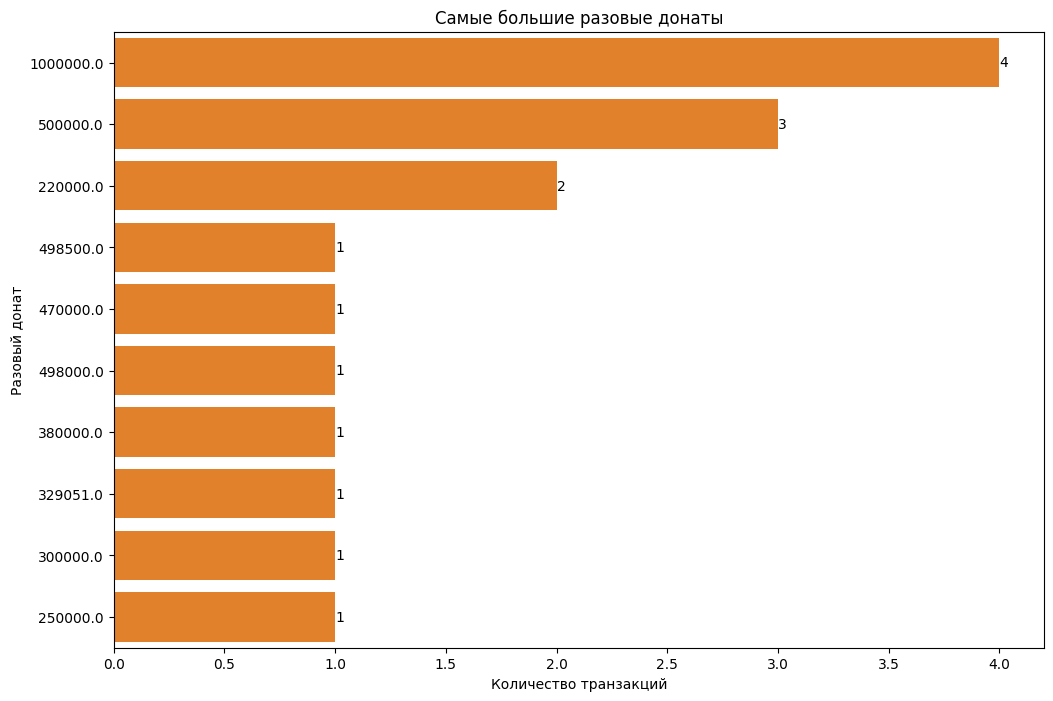

In [77]:
plt.figure(figsize=(12,8))
dd = tranz.query('comp_id == 0 and donate > 200000')['donate'].value_counts().head(10).reset_index()
dd['donate'] = dd['donate'].astype('str')
ax = sns.barplot(x=dd['count'], y=dd['donate'], color='tab:orange')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')

plt.title('Самые большие разовые донаты')
plt.ylabel('Разовый донат')
plt.xlabel('Количество транзакций')
plt.show()

## Самые щедрые пользователи

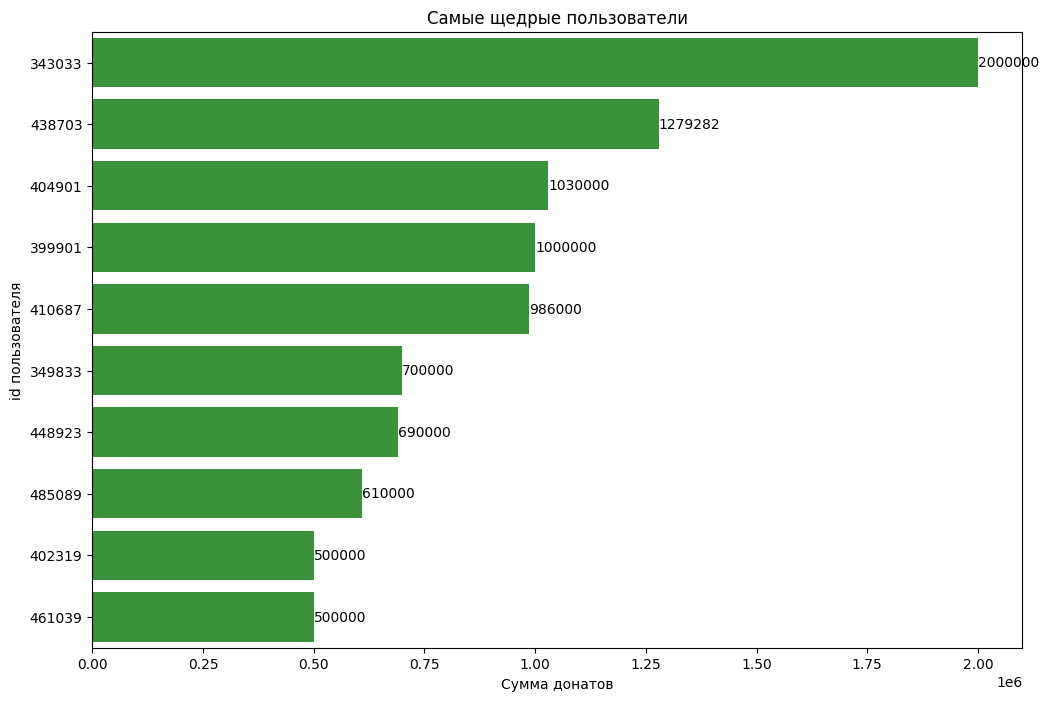

In [78]:
plt.figure(figsize=(12,8))
dd = tranz.query('comp_id == 0').groupby('user_id')['donate'].sum().sort_values().tail(10)[::-1].reset_index()
dd['user_id'] = dd['user_id'].astype('str')
ax = sns.barplot(x=dd['donate'], y=dd['user_id'], color='tab:green')
ax.bar_label(ax.containers[0], fmt='%d', fontsize=10, label_type='edge', color='black')

plt.title('Самые щедрые пользователи')
plt.ylabel('id пользователя')
plt.xlabel('Сумма донатов')
plt.show()

# Портрет пользователей

## Гендерное распределение

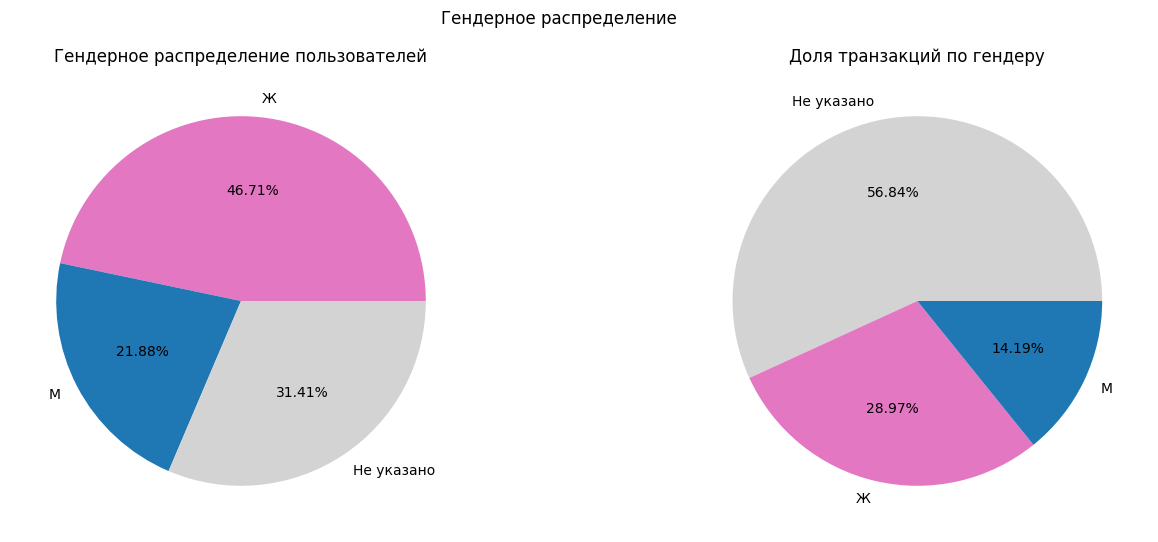

In [79]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('gender')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:pink', 'tab:blue', 'lightgray'],  autopct=lambda p : '{:.2f}%'.format(p))
dd = tranz['gender'].value_counts()
ax[0].set_title('Гендерное распределение пользователей')
ax[1].pie(x = dd.values, labels = dd.index, colors=['lightgray', 'tab:pink', 'tab:blue'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по гендеру')
plt.suptitle('Гендерное распределение')
plt.show()

Больше половины донатов приходит от людей, которые не пожелали давать подробную информацию о себе.

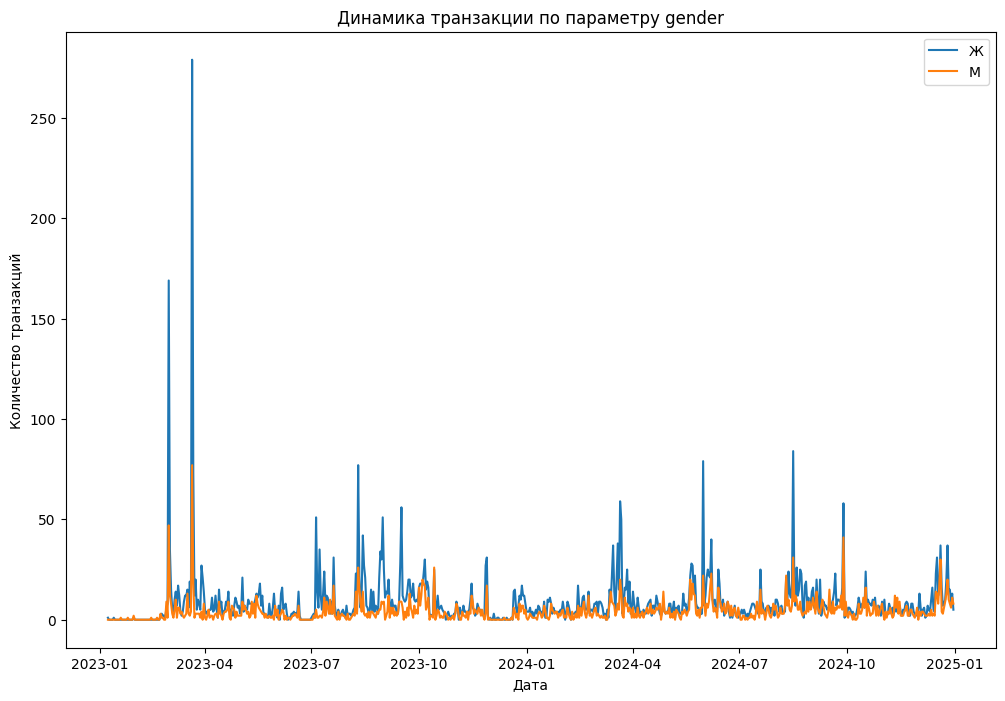

In [80]:
graf_dynamik_by_par(tranz.query('gender != "Не указано"'), 'gender', 5)

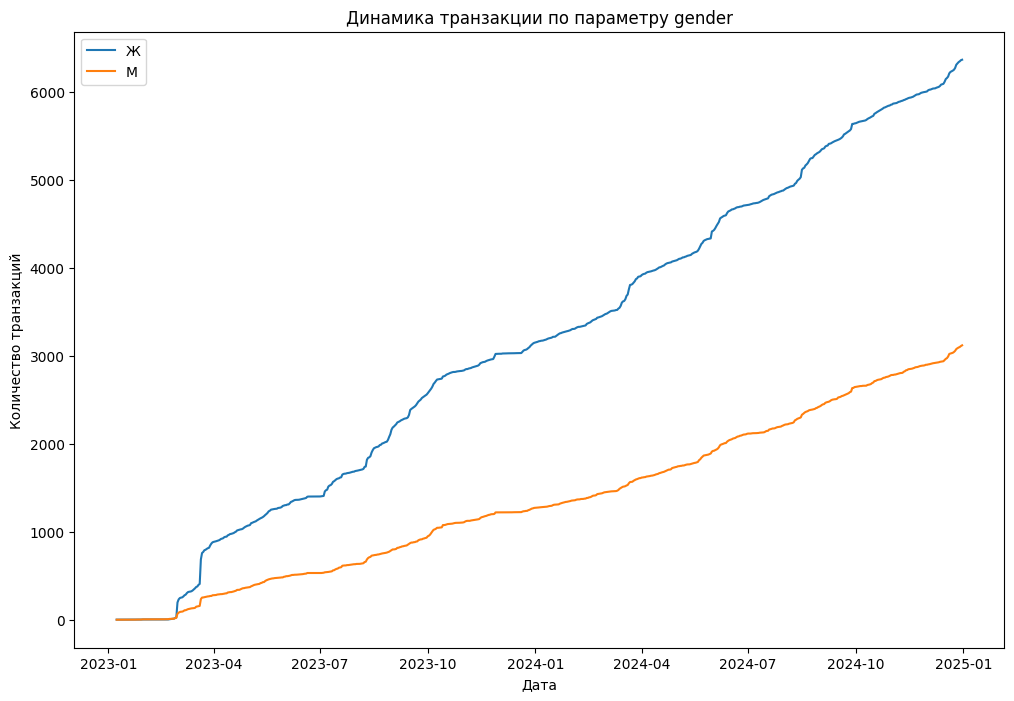

In [81]:
graf_dynamik_by_par(tranz.query('gender != "Не указано"'), 'gender', 5, 'cumsum')

Различение между донаторами мужчинами и женщинами только в количестве. Даты пиков пожервований совпадают.

## География донаторов

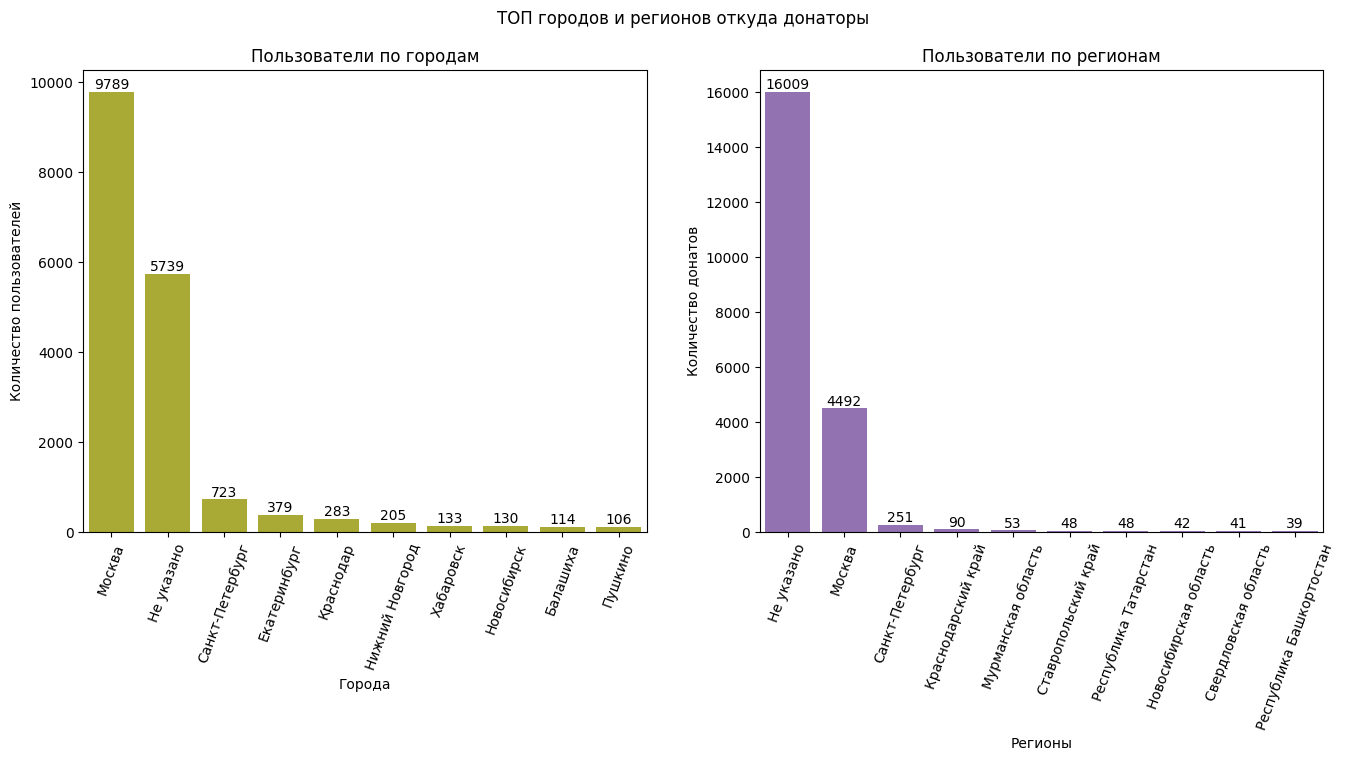

In [82]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz['city'].value_counts()[0:10]

sns.barplot(y=dd, x=dd.index, color='tab:olive', ax=ax[0])
ax[0].bar_label(ax[0].containers[0], fontsize=10, label_type='edge', color='black')
ax[0].tick_params(axis='x', labelrotation = 70)

ax[0].set_title('Пользователи по городам')
ax[0].set_xlabel('Города')
ax[0].set_ylabel('Количество пользователей')

dd = tranz['region'].value_counts()[0:10]
sns.barplot(y=dd, x=dd.index, color='tab:purple', ax=ax[1])
ax[1].bar_label(ax[1].containers[0], fontsize=10, label_type='edge', color='black')
ax[1].set_title('Пользователи по регионам')
ax[1].set_xlabel('Регионы')
ax[1].set_ylabel('Количество донатов')
ax[1].tick_params(axis='x', labelrotation = 70)

plt.suptitle('ТОП городов и регионов откуда донаторы')
plt.show()

Основная масса пользователей из Москвы.

## Доля ВИД пользователей

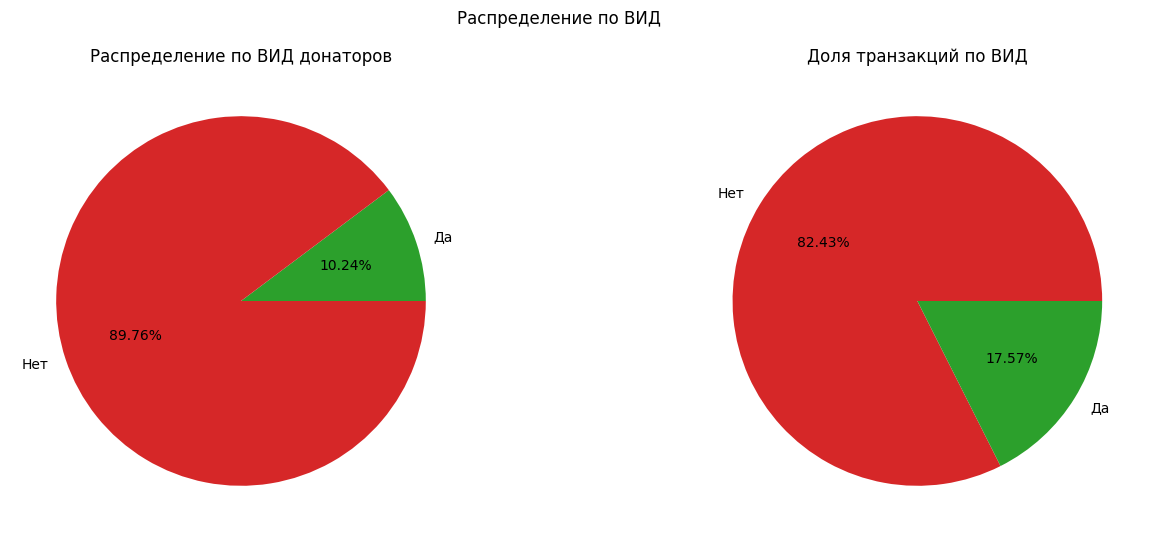

In [83]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('vid')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:green', 'tab:red'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Распределение по ВИД донаторов')

dd = tranz['vid'].value_counts()
ax[1].pie(x = dd.values, labels = dd.index, colors=['tab:red', 'tab:green'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по ВИД')

plt.suptitle('Распределение по ВИД')
plt.show()

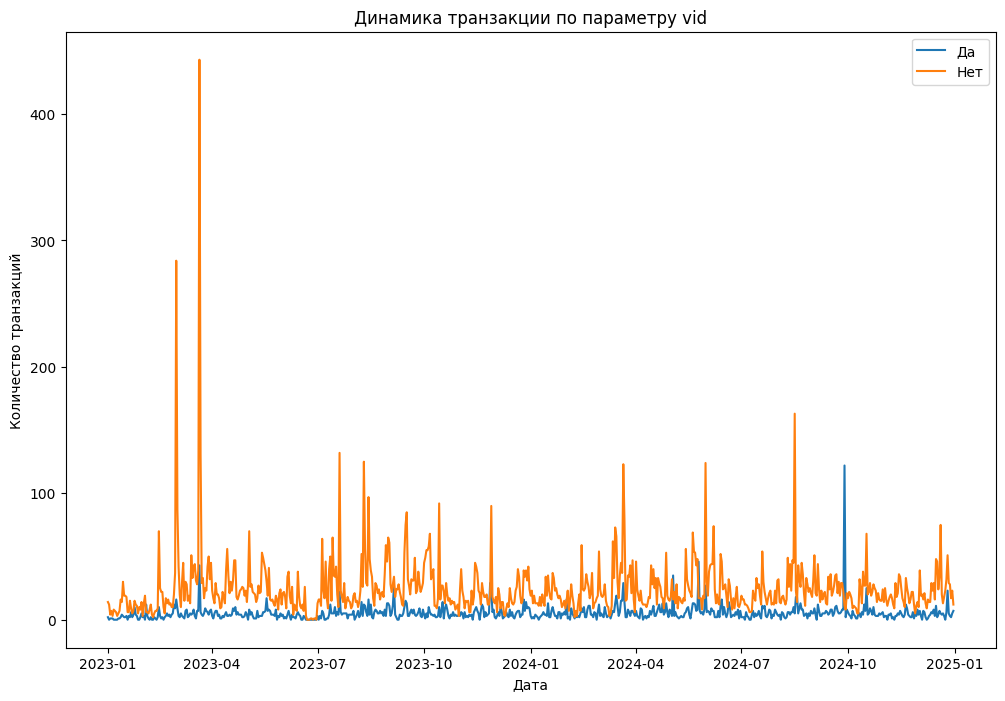

In [84]:
graf_dynamik_by_par(tranz, 'vid', 5)

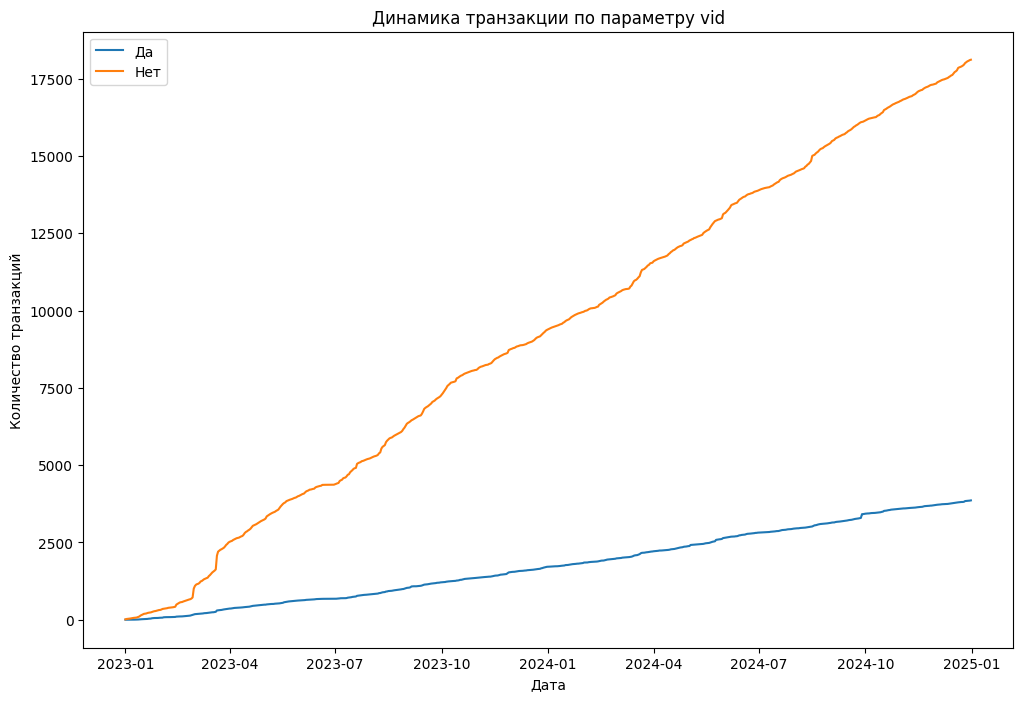

In [85]:
graf_dynamik_by_par(tranz, 'vid', 5, 'cumsum')

## Доля ЭН пользователей

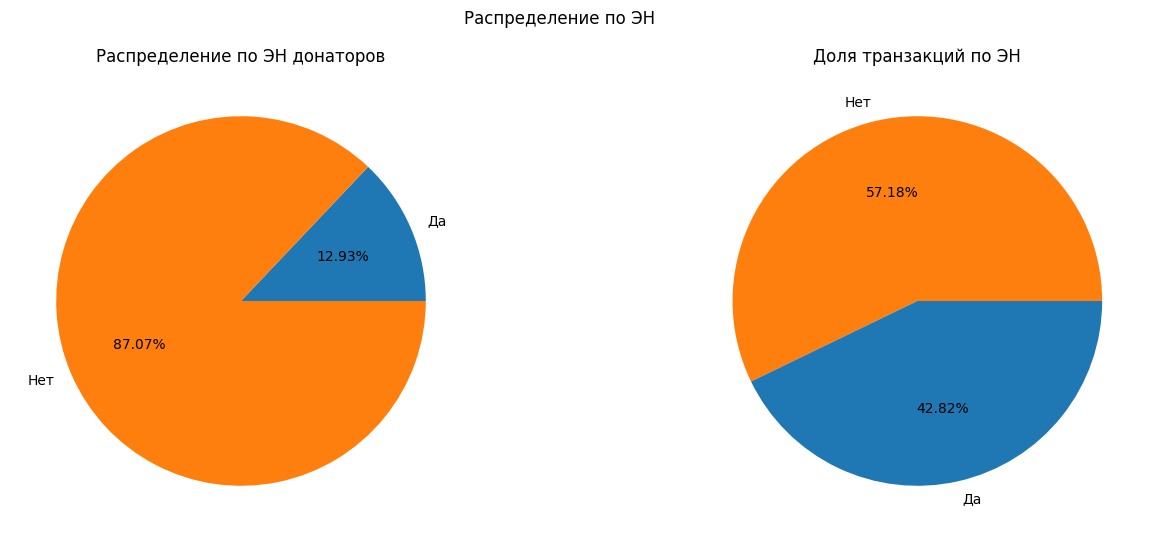

In [86]:
f, ax = plt.subplots(1, 2, figsize=(16,6))
dd = tranz.groupby('en')['user_id'].nunique()
ax[0].pie(x = dd.values, labels = dd.index, colors=['tab:blue', 'tab:orange'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Распределение по ЭН донаторов')

dd = tranz['en'].value_counts()
ax[1].pie(x = dd.values, labels = dd.index, colors=['tab:orange', 'tab:blue'],  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля транзакций по ЭН')

plt.suptitle('Распределение по ЭН')
plt.show()

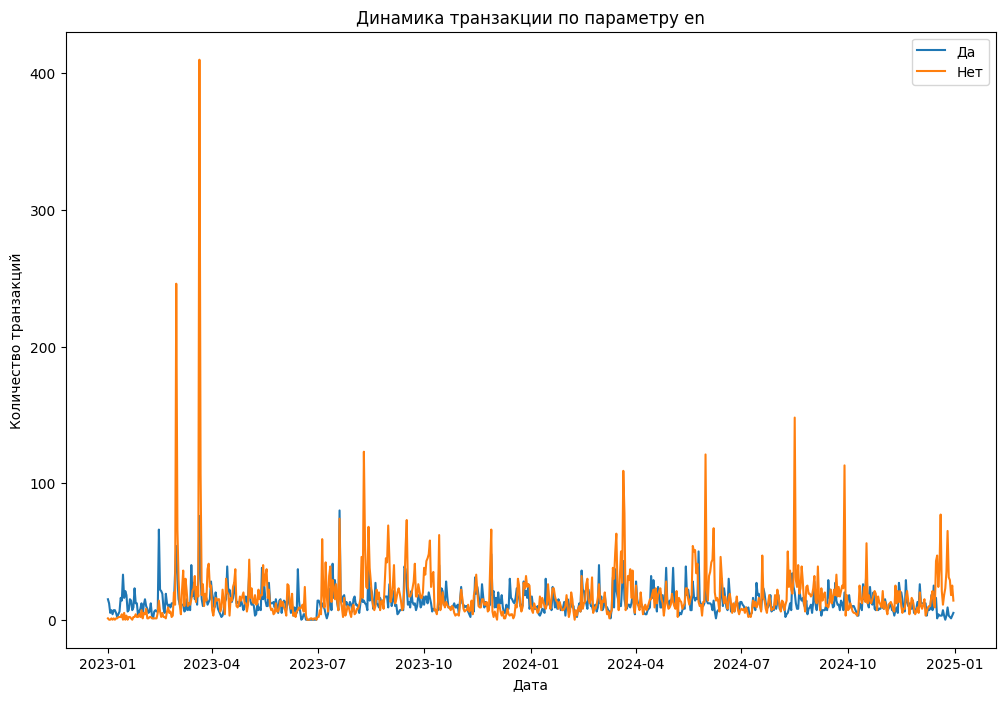

In [87]:
graf_dynamik_by_par(tranz, 'en', 5)

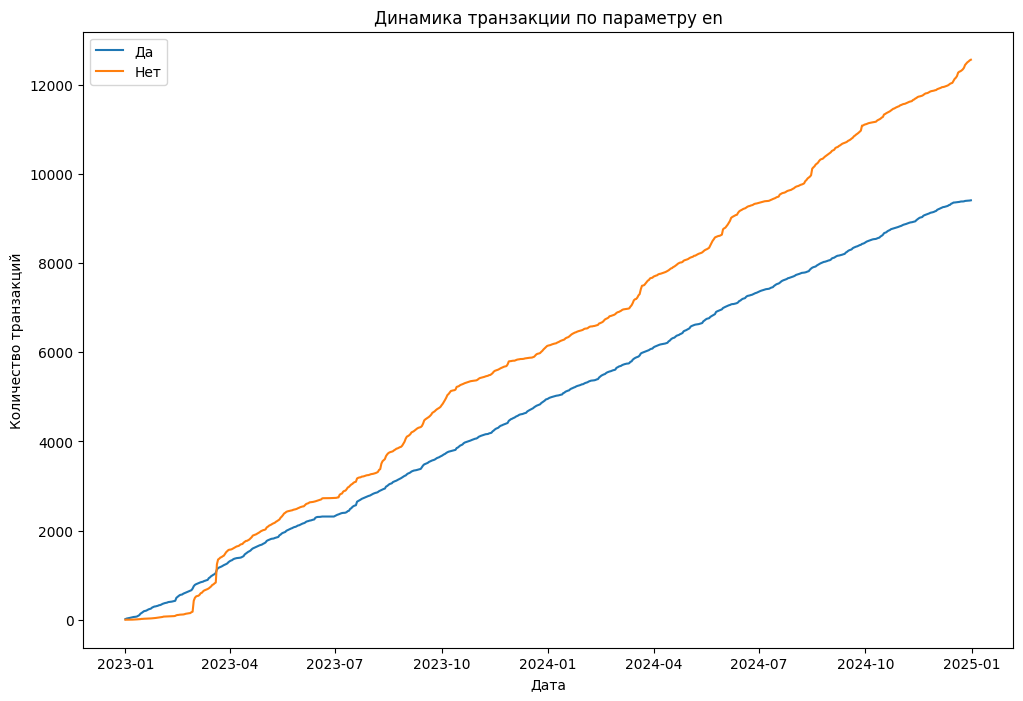

In [88]:
graf_dynamik_by_par(tranz, 'en', 5, 'cumsum')

## Источники контактов

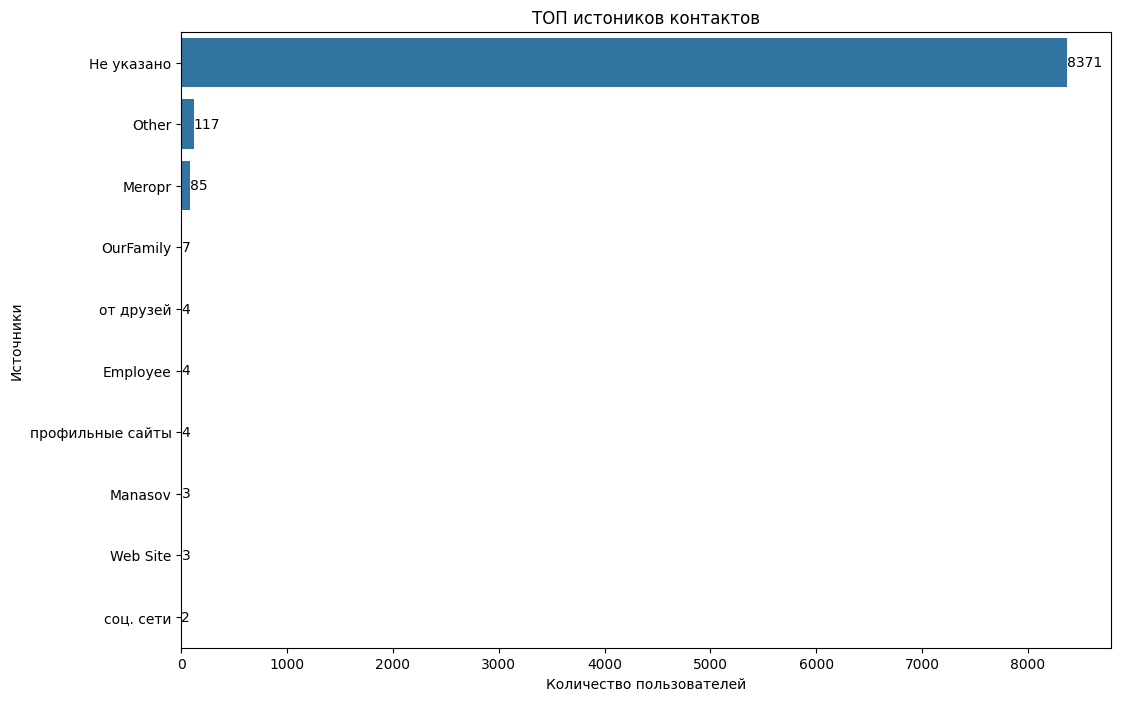

In [89]:
fig = plt.figure(figsize=(12, 8))
dd = tranz.groupby('source')['user_id'].nunique().sort_values().tail(10)[::-1]
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП истоников контактов')
plt.xlabel('Количество пользователей')
plt.ylabel('Источники')
plt.show()

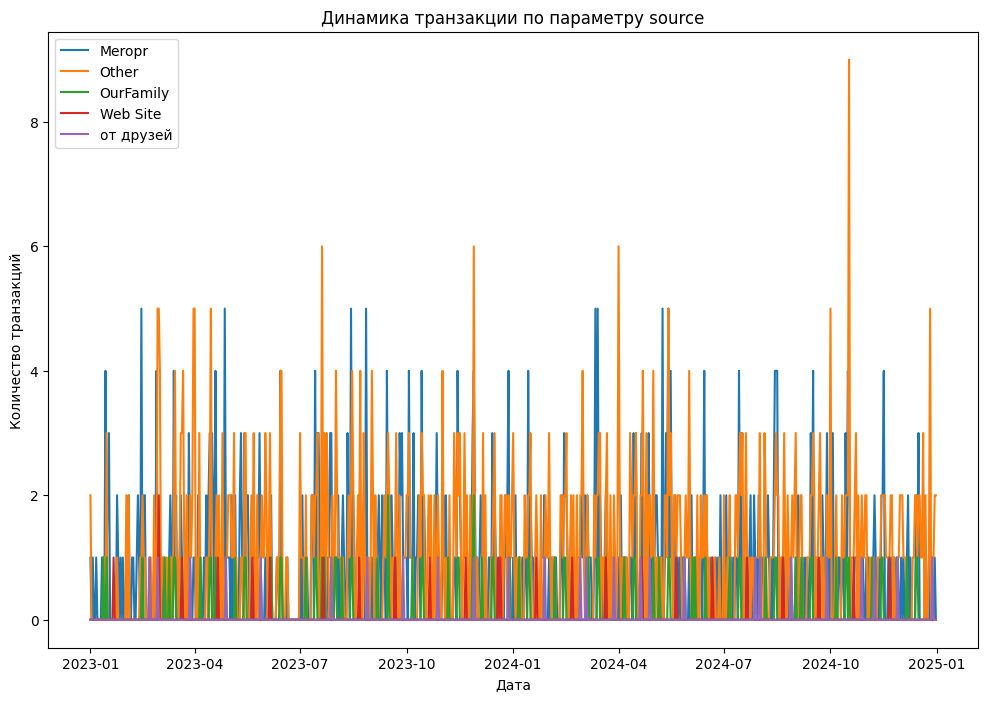

In [90]:
graf_dynamik_by_par(tranz.query('source != "Не указано"'), 'source', 5)

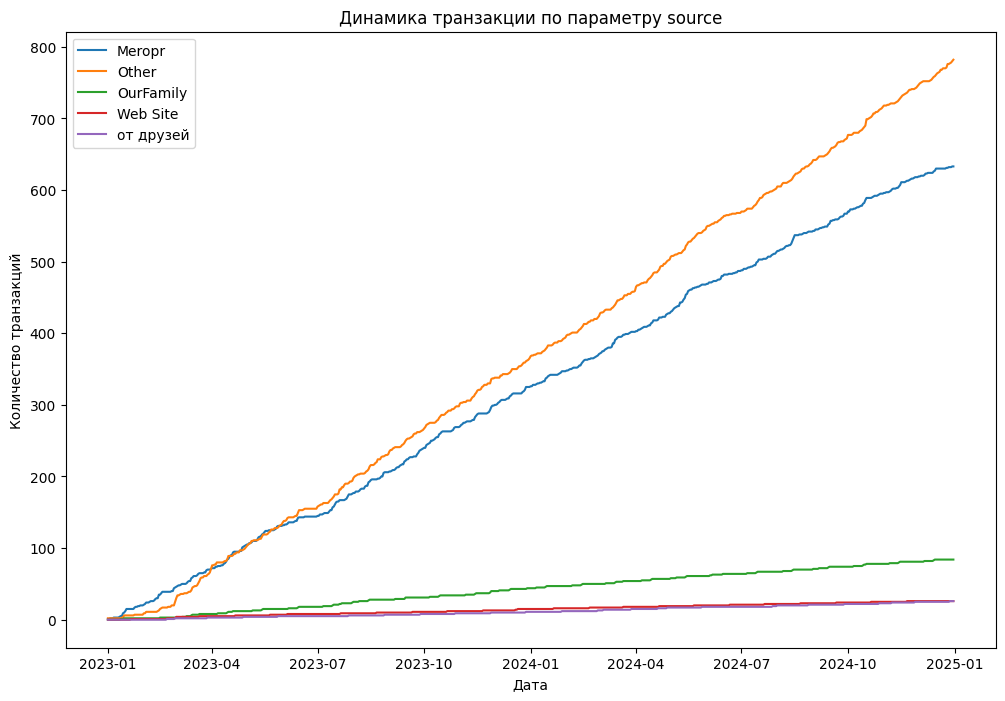

In [91]:
graf_dynamik_by_par(tranz.query('source != "Не указано"'), 'source', 5, 'cumsum')

## Типы доноров

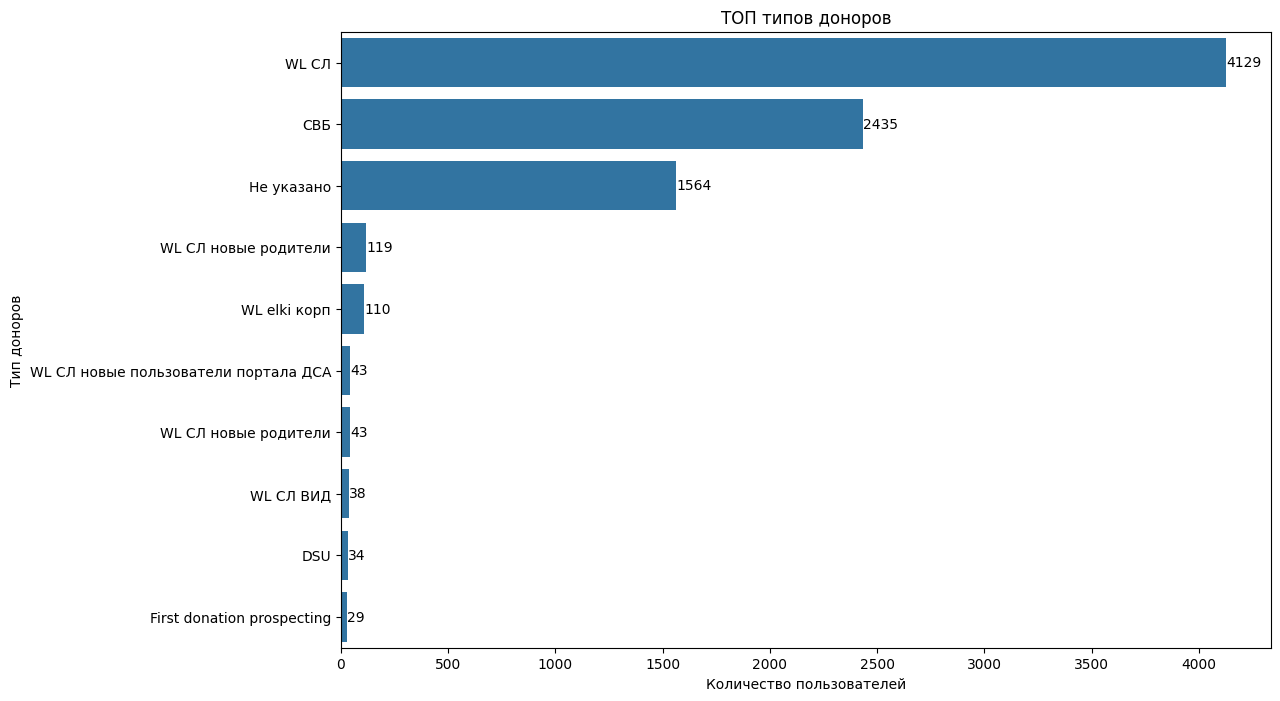

In [92]:
fig = plt.figure(figsize=(12, 8))
dd = tranz.groupby('donor_type')['user_id'].nunique().sort_values().tail(10)[::-1]
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП типов доноров')
plt.xlabel('Количество пользователей')
plt.ylabel('Тип доноров')
plt.show()

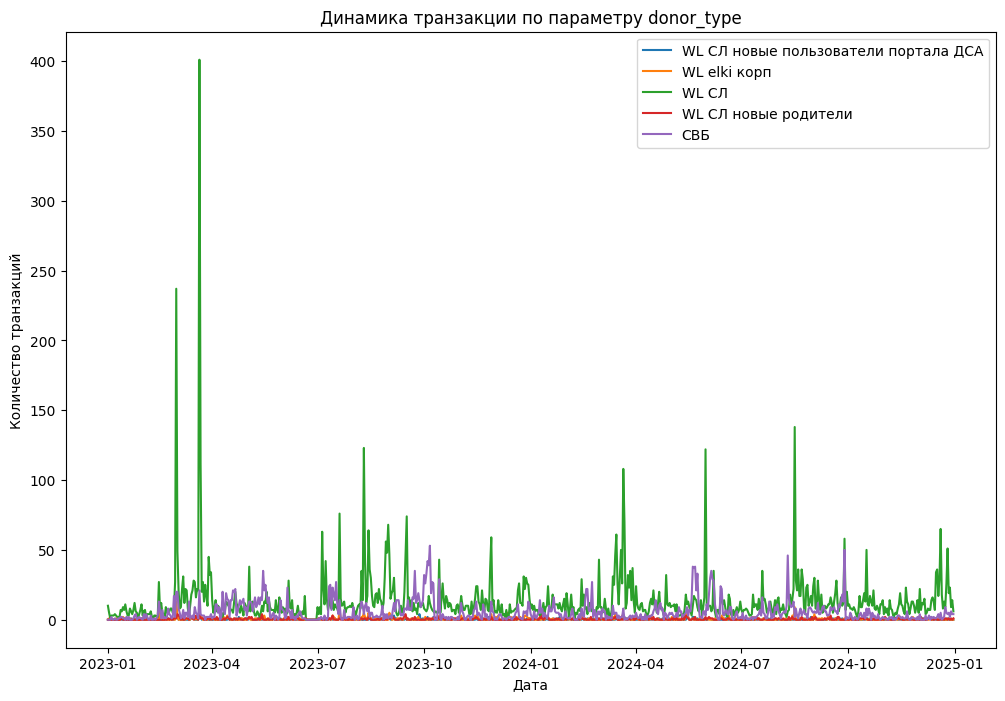

In [93]:
graf_dynamik_by_par(tranz.query('donor_type != "Не указано"'), 'donor_type', 5)

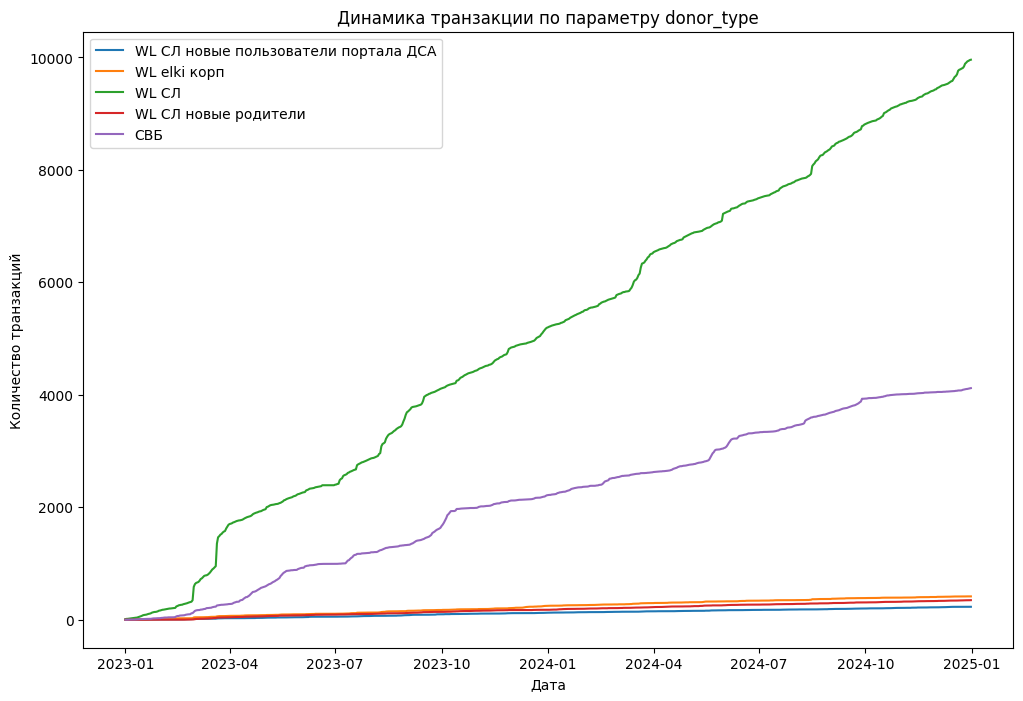

In [94]:
graf_dynamik_by_par(tranz.query('donor_type != "Не указано"'), 'donor_type', 5, 'cumsum')

**Промежуточные итоги:**

Вывели основные метрики и показатели, их динамика по датам.

In [95]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:08:59.434724+04:00
 От начала рассчета прошло 0:00:30.780003


# Донаты от компаниий

In [96]:
comp_all = corp['comp_id'].nunique()
comp_tr = corp['id'].count()
comp_users = corp['user_id'].nunique()
comp_sum = corp['donate'].sum()

print(f"Общее количество компаний {comp_all}")
print(f"Общее количество пользователей из компаний {comp_users}")
print(f"Общее количество донатов из компаний {comp_tr}")
print(f"Общее сумма донатов из компаний {comp_sum:,.0f} руб.".replace(',', ' '))

Общее количество компаний 36
Общее количество пользователей из компаний 39
Общее количество донатов из компаний 178
Общее сумма донатов из компаний 23 566 818 руб.


Количество донатов от компании - мало, но по сумме они составляют приличную сумму.

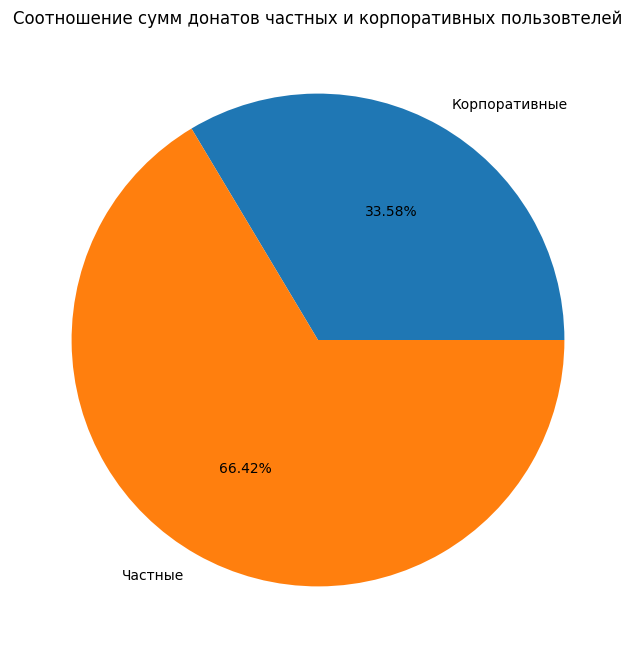

In [97]:
fig = plt.figure(figsize=(10, 8))
plt.pie(x = [corp['donate'].sum(), tranz['donate'].sum()],
        labels = ['Корпоративные', 'Частные'], autopct=lambda p : '{:.2f}%'.format(p))
plt.title('Соотношение сумм донатов частных и корпоративных пользовтелей')
plt.show()

Треть всех поступлений идет от компаний

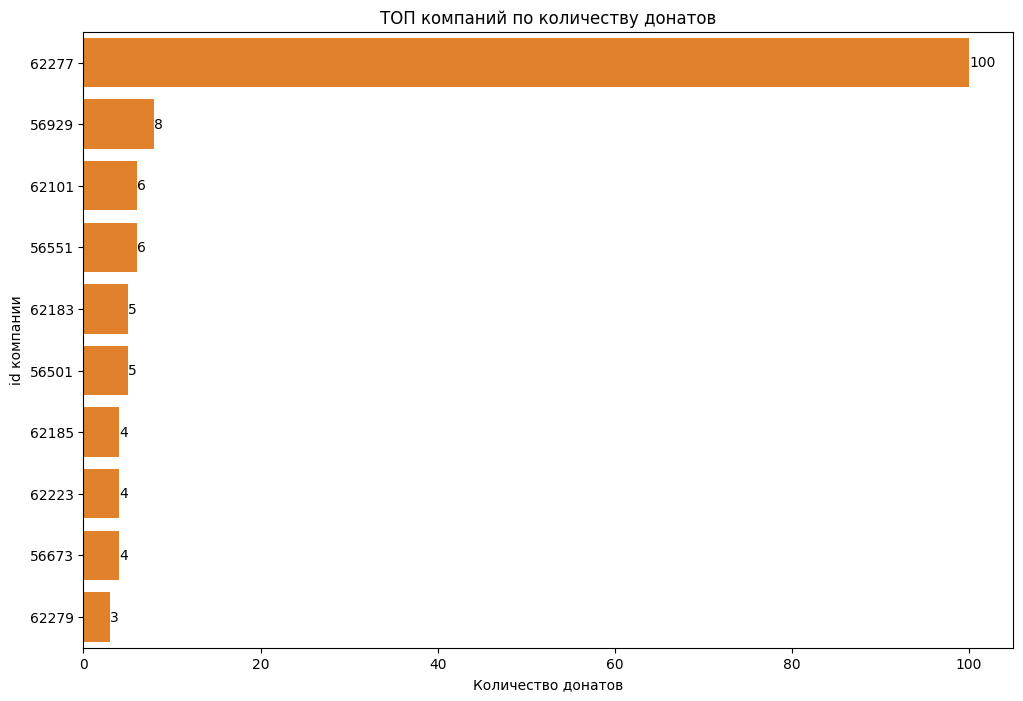

In [98]:
fig = plt.figure(figsize=(12, 8))
dd = corp.groupby('comp_id')['id'].count().sort_values().tail(10)[::-1]
dd.index = dd.index.map(str)
ax = sns.barplot(x=dd, y=dd.index, color='tab:orange')
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=10, label_type='edge', color='black')
plt.title('ТОП компаний по количеству донатов')
plt.xlabel('Количество донатов')
plt.ylabel('id компании')
plt.show()

Как видно, в основном это разовые перечисления

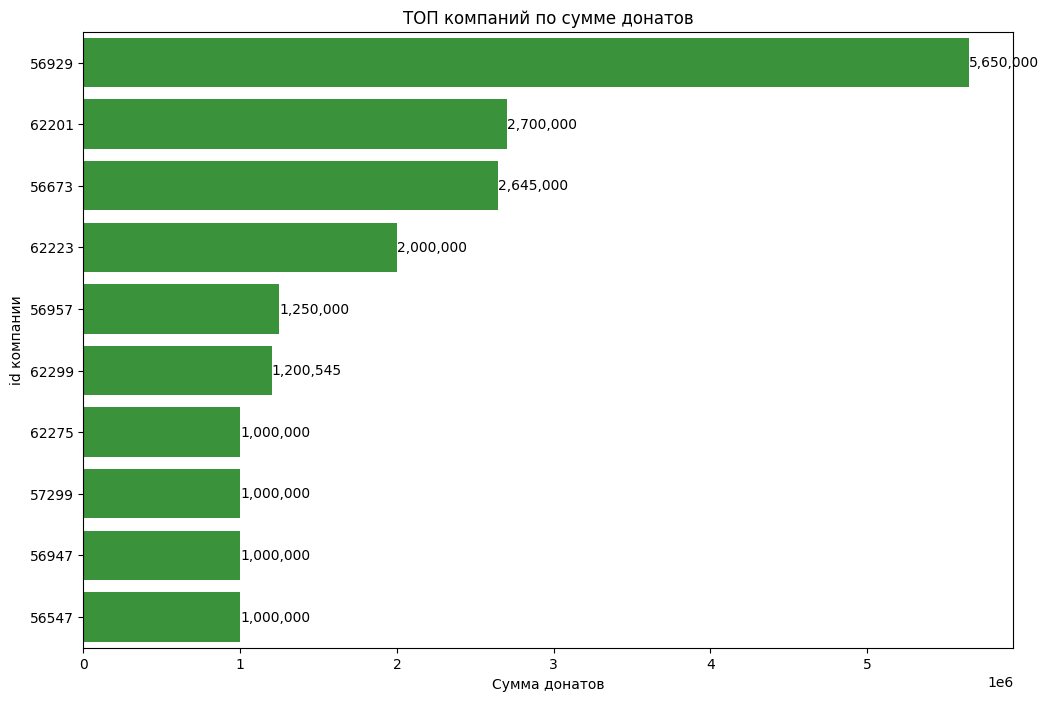

In [99]:
fig = plt.figure(figsize=(12, 8))
dd = corp.groupby('comp_id')['donate'].sum().sort_values().tail(10)[::-1]
dd.index = dd.index.map(str)
ax = sns.barplot(x=dd, y=dd.index, color='tab:green')
ax.bar_label(ax.containers[0], fmt='{:,.0f}', fontsize=10, label_type='edge', color='black')
plt.title('ТОП компаний по сумме донатов')
plt.xlabel('Сумма донатов')
plt.ylabel('id компании')
plt.show()

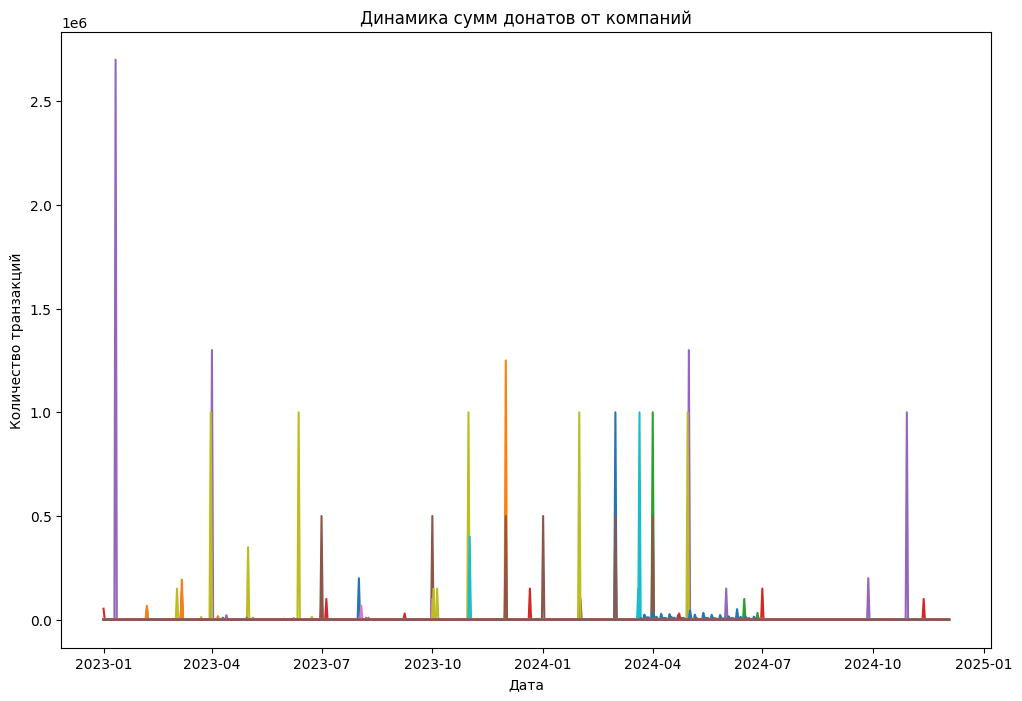

In [100]:
fig = plt.figure(figsize=(12, 8))
top = corp.groupby('comp_id')['donate'].sum().sort_values().index
dd = corp.query('comp_id.isin(@top)').groupby(['date', 'comp_id'], as_index=False)['donate'].sum()
dd = dd.pivot_table(index='date', columns='comp_id', values='donate').fillna(0)

date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
dd = dd.reindex(date_range, fill_value=0)

plt.plot(dd, label=dd.columns)
#plt.legend()
plt.title(f'Динамика сумм донатов от компаний')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.show()

На корпоративные донаты приходится треть всей собранной суммы. Однако это разовые платежи - всего 178 транзакций за 2 года, 100 из которых пришли от сотрудников одной компании.

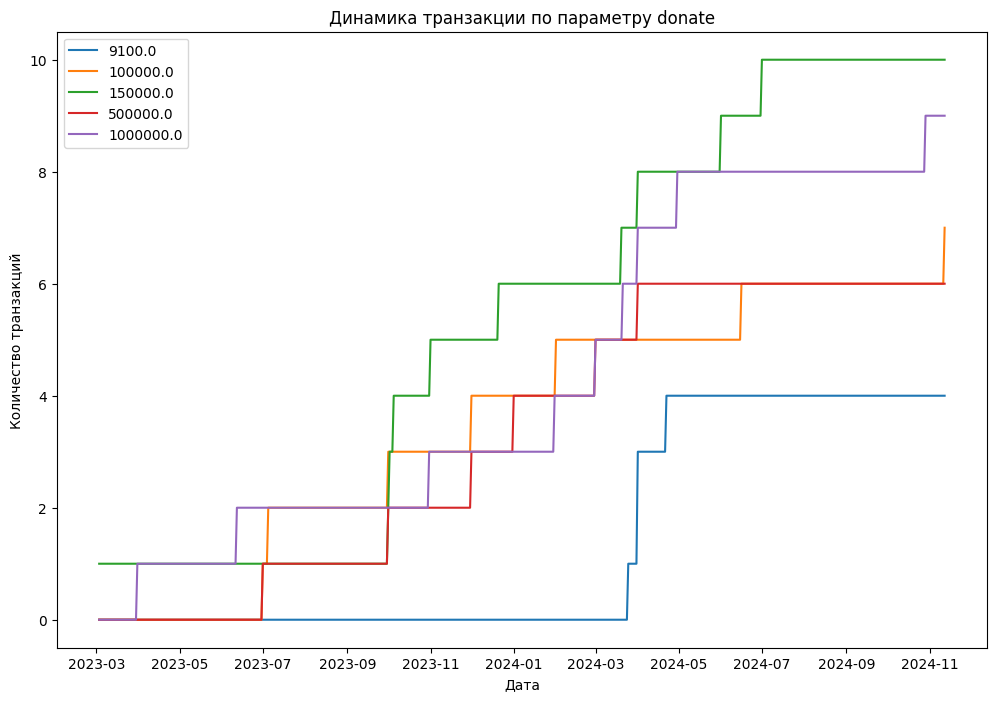

In [101]:
graf_dynamik_by_par(corp, 'donate', 5, 'cumsum')

# Параметры донатов

### Коды

Сформируетм таблицу кодов. Расчитаем для каждого кода колво транзакций и пользоватей, а также сумму донатов. Составим ранги по каждоой из этих колонок, а также суммарный ранг. Наилучшим будет код, имеющий наименьшую сумму трех рангов.

In [102]:
codes_table = segmet_table(tranz, 'code')
codes_table.sort_values(by = ['rank_sum']).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

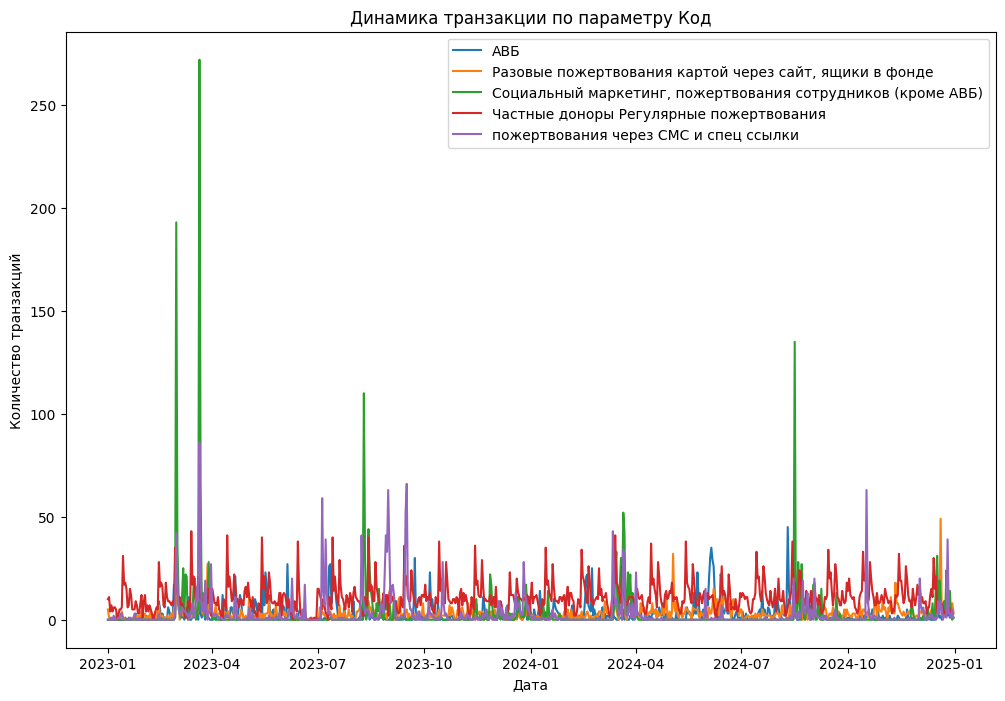

In [103]:
graf_dynamik_by_par(tranz.query('code != "Не указано"'), 'code', 5)

График показывает, что пожервования в разрезе кодов также идут импульсам. Пики на графике должны соотвествовать наиболее удачным акциям / мероприятиям / событиям.

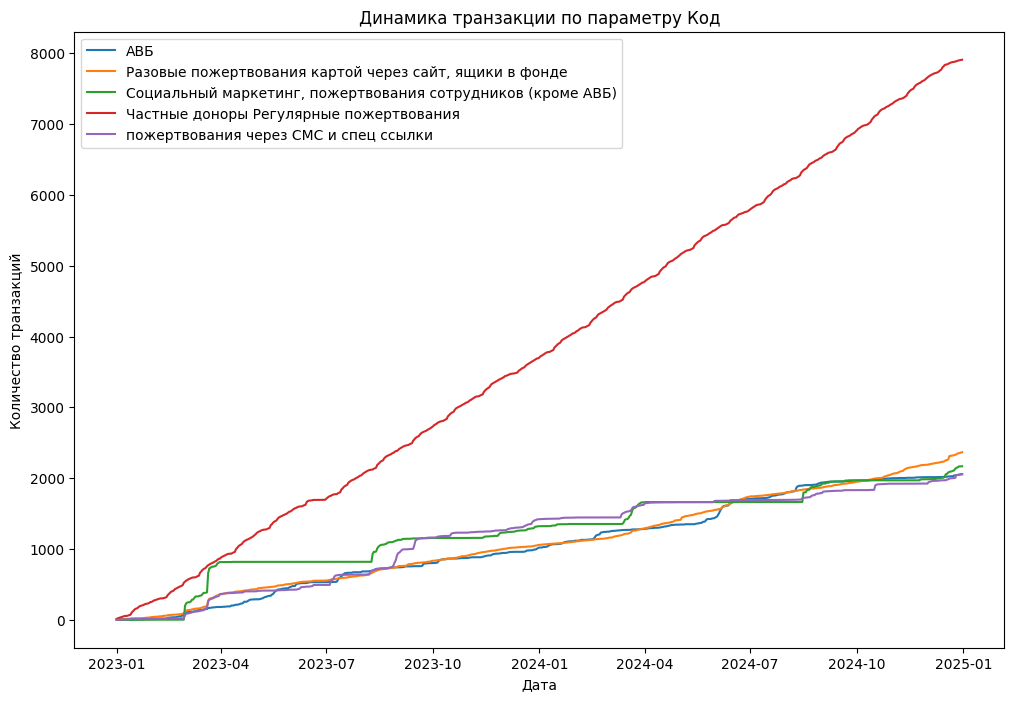

In [104]:
graf_dynamik_by_par(tranz.query('code != "Не указано"'), 'code', 5, 'cumsum')

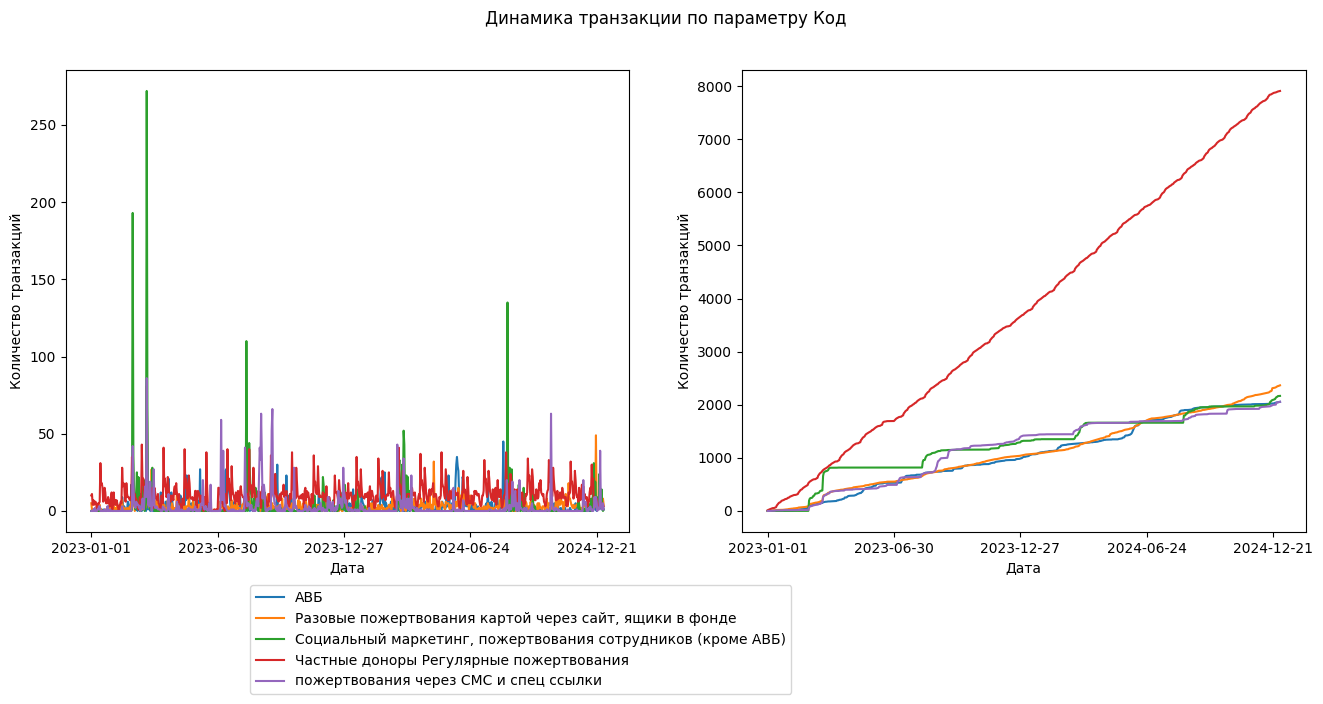

In [105]:
graf_dynamik_by_par_subplot(tranz.query('code != "Не указано"'), 'code', 5)

Таблица дат пиков кодов

In [106]:
tranz.groupby(['date', 'code'], as_index=False)['id'].count()\
    .query('id > 50').rename(columns = {'id' : 'tr_count'})

date                                                         code  \
217  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
349  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
350  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
353  2023-03-21                        пожертвования через СМС и спец ссылки   
358  2023-03-22  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
899  2023-07-05                        пожертвования через СМС и спец ссылки   
983  2023-07-20                                      Частные доноры Рассылки   
1097 2023-08-10  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
1255 2023-08-31                        пожертвования через СМС и спец ссылки   
1352 2023-09-15                        пожертвования через СМС и спец ссылки   
1358 2023-09-16                        пожертвования через СМС и спец ссылки   
1537 2023-10-14                                           ВИД массовые акции   
1799 2023-11-28                                      Частные доноры Рассылки   
2479 2024-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2910 2024-05-31                                           ВИД массовые акции   
3339 2024-08-16  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
3635 2024-09-28                                                Телемаркетинг   
3742 2024-10-17                        пожертвования через СМС и спец ссылки   

      tr_count  
217        193  
349         81  
350        272  
353         86  
358         67  
899         59  
983        106  
1097       110  
1255        63  
1352        52  
1358        66  
1537        55  
1799        79  
2479        52  
2910       100  
3339       135  
3635       111  
3742        63

### Комментарии

Аналогично формируем таблицу комментариев

In [107]:
codes_table = segmet_table(tranz, 'comment')
codes_table.sort_values(by = ['rank_sum']).head(20).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

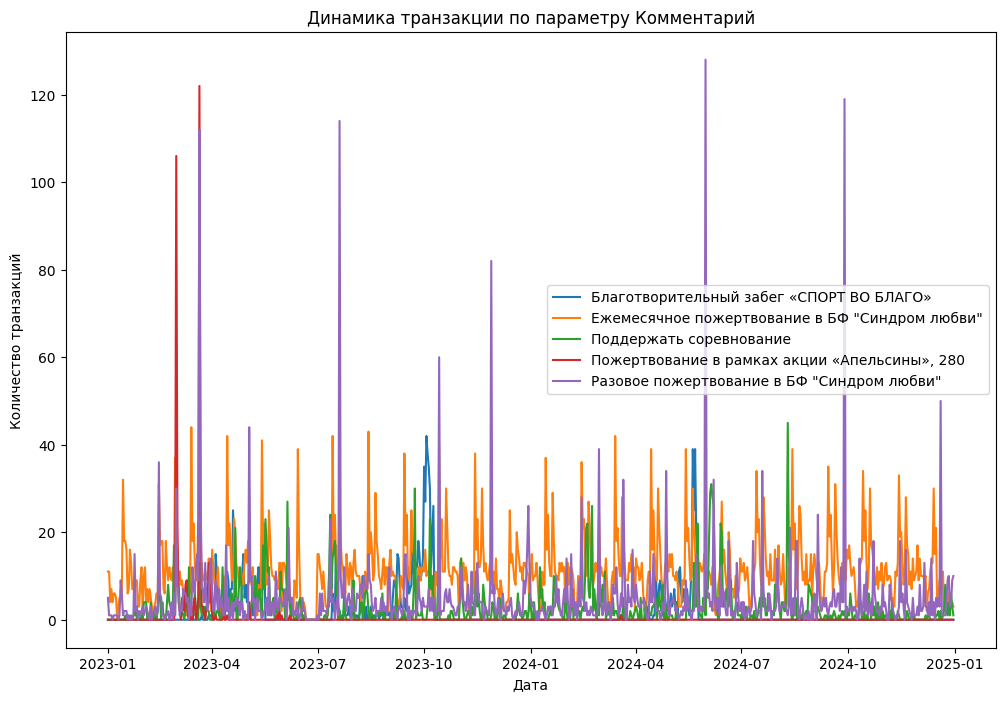

In [108]:
graf_dynamik_by_par(tranz.query('comment != "Не указано"'), 'comment', 5)

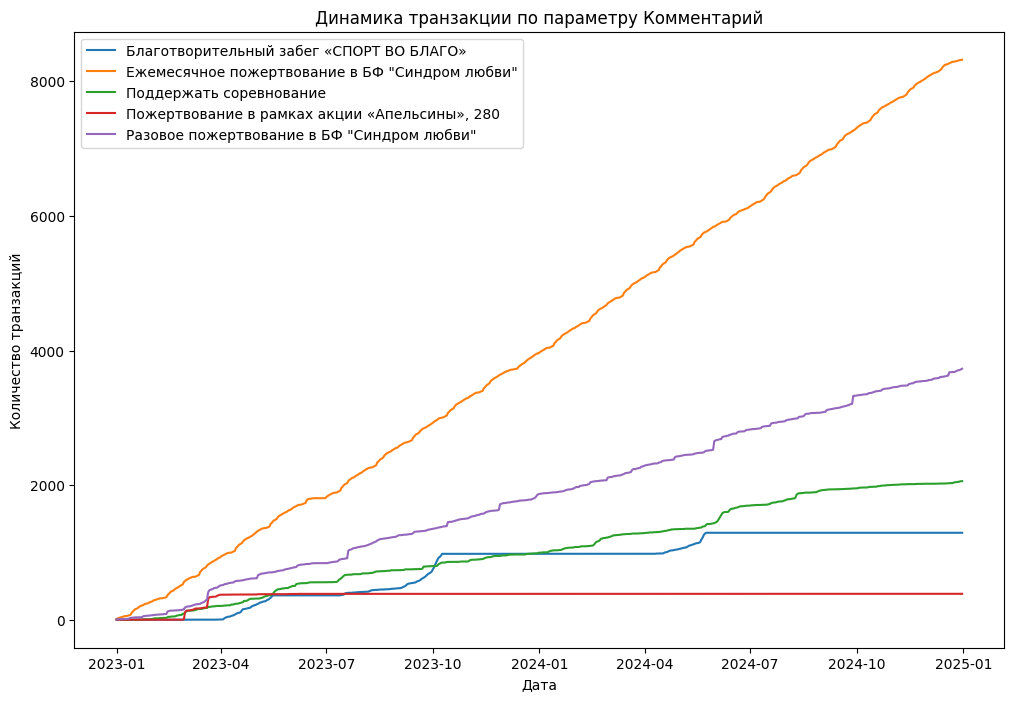

In [109]:
graf_dynamik_by_par(tranz.query('comment != "Не указано"'), 'comment', 5, 'cumsum')

Таблица дат пиков комметриев

In [110]:
tranz.groupby(['date', 'comment'], as_index=False)['id'].count()\
    .query('id > 50').rename(columns = {'id' : 'tr_count'})

date  \
206  2023-03-01   
208  2023-03-01   
367  2023-03-21   
371  2023-03-21   
372  2023-03-21   
897  2023-07-05   
979  2023-07-20   
1468 2023-09-16   
1652 2023-10-14   
1908 2023-11-28   
3099 2024-05-31   
3500 2024-08-16   
3841 2024-09-28   
3945 2024-10-17   

                                                                      comment  \
206                             Пожертвование в рамках акции «Апельсины», 280   
208                             Пожертвование в рамках акции «Апельсины», 590   
367                             Пожертвование в рамках акции «Апельсины», 280   
371                             Пожертвование в рамках акции «Апельсины», 590   
372                                Разовое пожертвование в БФ "Синдром любви"   
897                                    Разовое пожертвование "День рождения "   
979                                Разовое пожертвование в БФ "Синдром любви"   
1468                     Разовое пожертвование "Академия успеха Атоми в Сочи"   
1652                               Разовое пожертвование в БФ "Синдром любви"   
1908                               Разовое пожертвование в БФ "Синдром любви"   
3099                               Разовое пожертвование в БФ "Синдром любви"   
3500  Разовое пожертвование в рамках акции «Школа начинается с перемен!», 280   
3841                               Разовое пожертвование в БФ "Синдром любви"   
3945                                   Разовое пожертвование "Добрый юбилей "   

      tr_count  
206        106  
208         78  
367        122  
371        115  
372        112  
897         56  
979        114  
1468        59  
1652        60  
1908        82  
3099       128  
3500        73  
3841       119  
3945        51

### Метки в ссылках

Аналогично формируем таблицу меток в ссылках

In [111]:
codes_table = segmet_table(tranz, 'action')
codes_table.sort_values(by = ['rank_sum']).head(20).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

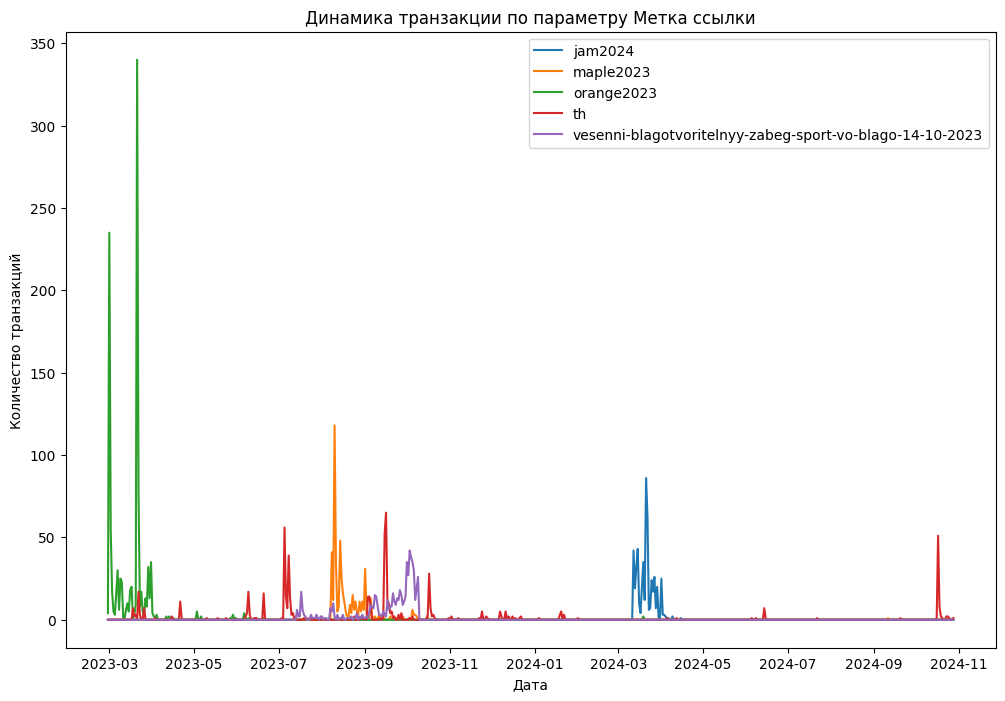

In [112]:
graf_dynamik_by_par(tranz.query('action != "Не указано"'), 'action', 5)

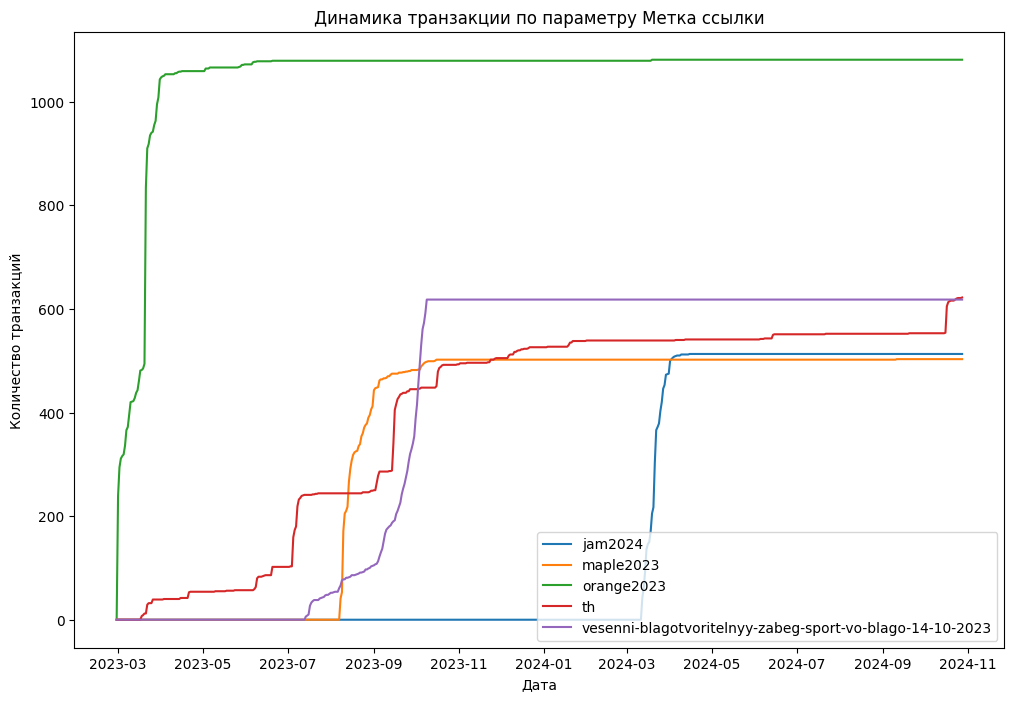

In [113]:
graf_dynamik_by_par(tranz.query('action != "Не указано"'), 'action', 5, 'cumsum')

Таблица дат пиков меток из ссылок

In [114]:
tranz.groupby(['date', 'action'], as_index=False)['id'].count()\
    .query('id > 100').rename(columns = {'id' : 'tr_count'})

date        action  tr_count
155  2023-03-01    orange2023       235
266  2023-03-21    orange2023       340
831  2023-07-20  EN_needs7.23       114
917  2023-08-10     maple2023       118
2685 2024-08-16      school24       137

### Сайты-источники

Аналогично формируем таблицу сайтов-источников

In [115]:
codes_table = segmet_table(tranz, 'site')
codes_table.sort_values(by = ['rank_sum']).style.format('{:.0f}')\
        .background_gradient(subset=['rank_sum', 'tc_rank', 'uc_rank', 'ds_rank'], cmap='RdYlGn_r')

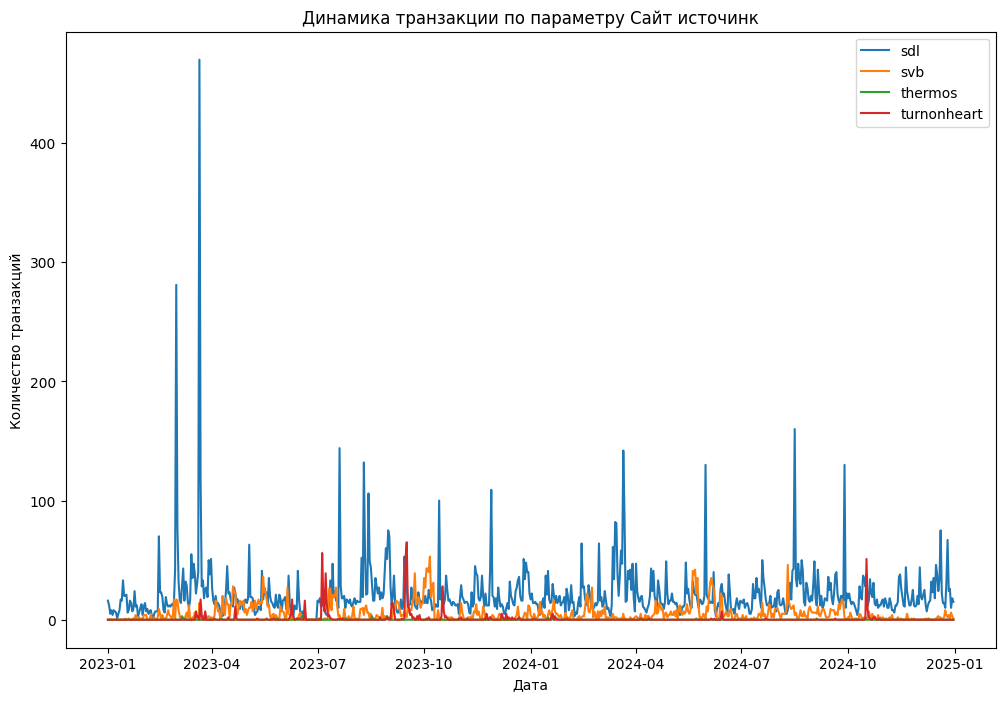

In [116]:
graf_dynamik_by_par(tranz.query('site != "Не указано"'), 'site', 5)

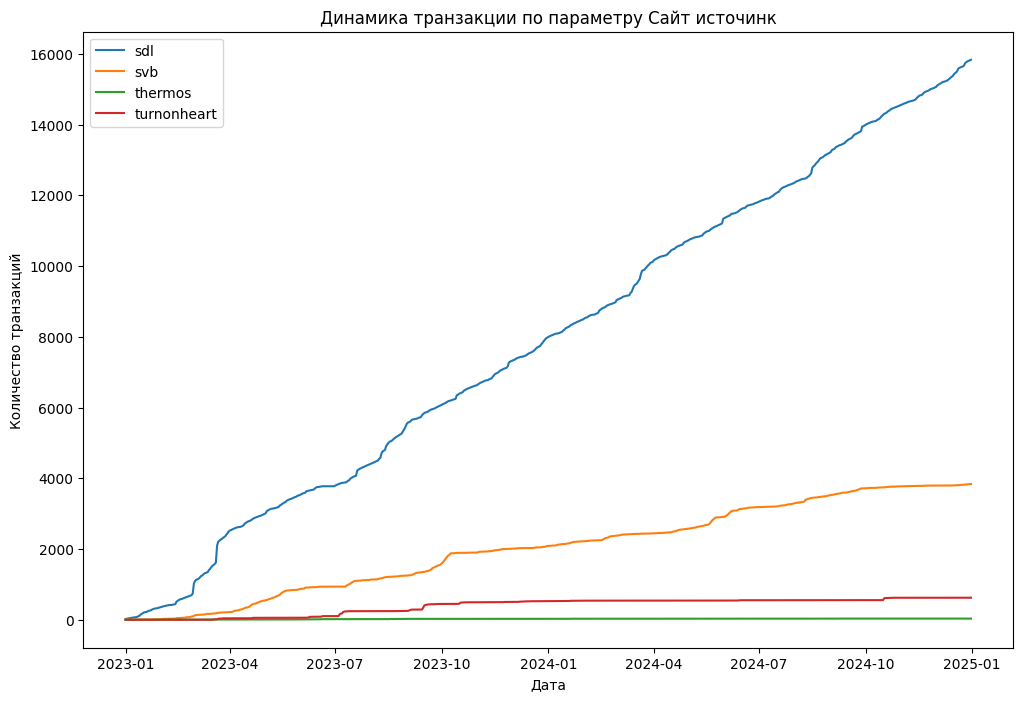

In [117]:
graf_dynamik_by_par(tranz.query('site != "Не указано"'), 'site', 5, 'cumsum')

Таблица дат пиков сайтов-источников

In [118]:
tranz.groupby(['date', 'site'], as_index=False)['id'].count()\
    .query('id > 100').rename(columns = {'id' : 'tr_count'})

date site  tr_count
118  2023-03-01  sdl       281
172  2023-03-21  sdl       470
175  2023-03-22  sdl       117
494  2023-07-20  sdl       144
548  2023-08-10  sdl       132
560  2023-08-14  sdl       106
864  2023-11-28  sdl       109
1163 2024-03-21  sdl       142
1366 2024-05-31  sdl       130
1582 2024-08-16  sdl       160
1703 2024-09-28  sdl       130

**Промежуточные итоги:**

Построили сегметацию транзакций и пользователей по сайтам-источникам, кодам, комментариям, меткам в ссылках. Определили ТОПовые значения в кадом сегменте по пользователям и транзакциям. Также определили даты "пиков" динамики по сегментам, которые должны соответствовать наибоеле успешным акциям / мероприятиям / рассылкам.

In [119]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:09:03.916213+04:00
 От начала рассчета прошло 0:00:35.261493


# Первые пожертвования

Формиурем таблицу первых пожертвований - это параметры первых транзакций пользовтелей в анализируемый период.

In [120]:
#К таблице пользователей слева присоединяем записи из таблицы транзакций по паре ключей - [user_id, first_date]
first_donate = pd.merge(user_table,tranz,  how='left',\
                        left_on=['user_id', 'first_date'],\
                        right_on=['user_id', 'date'])\
                         [['user_id', 'first_date', 'code', 'comment', 'action']].sort_values(by='first_date')

### Коды первых пожертвований

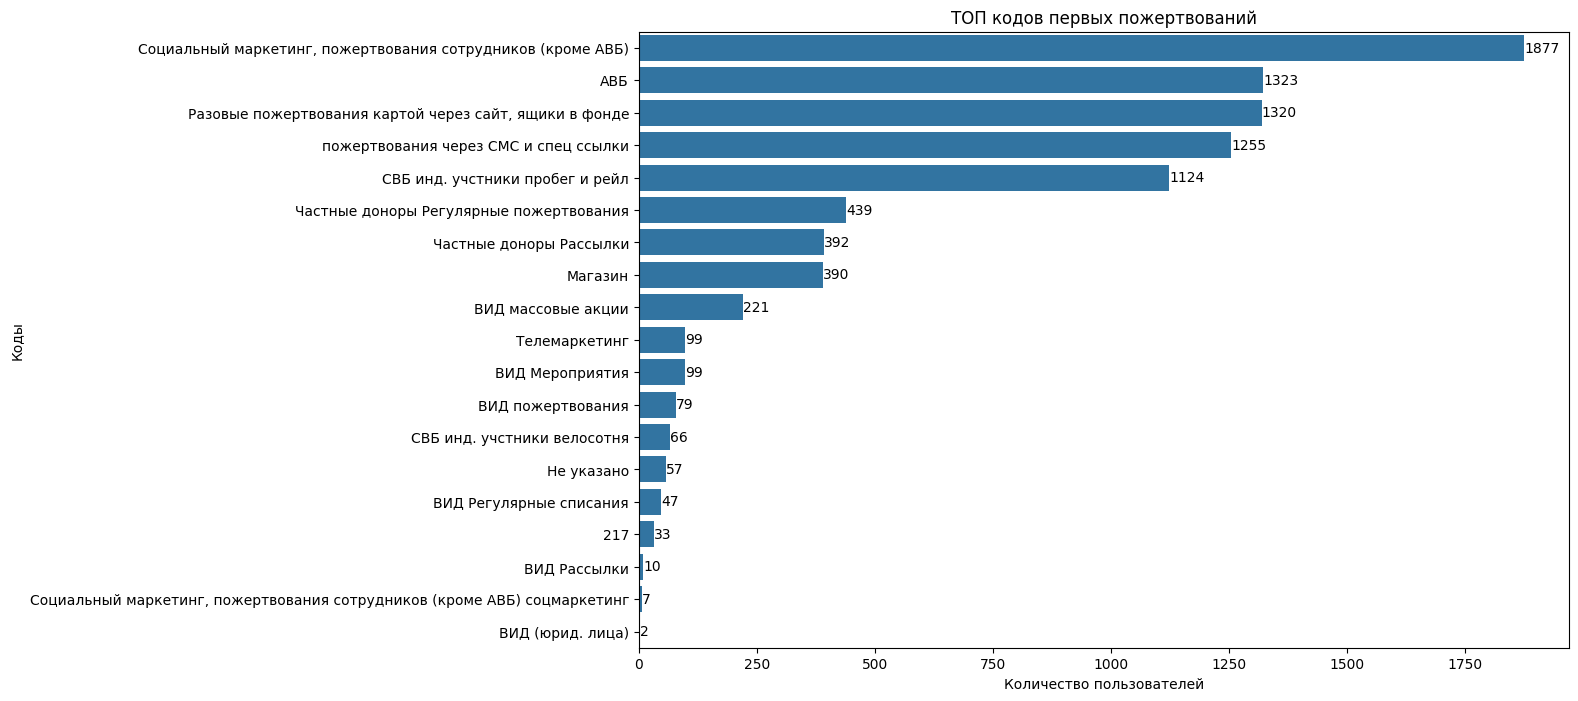

In [121]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['code'].value_counts().head(20)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП кодов первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Коды')
plt.show()

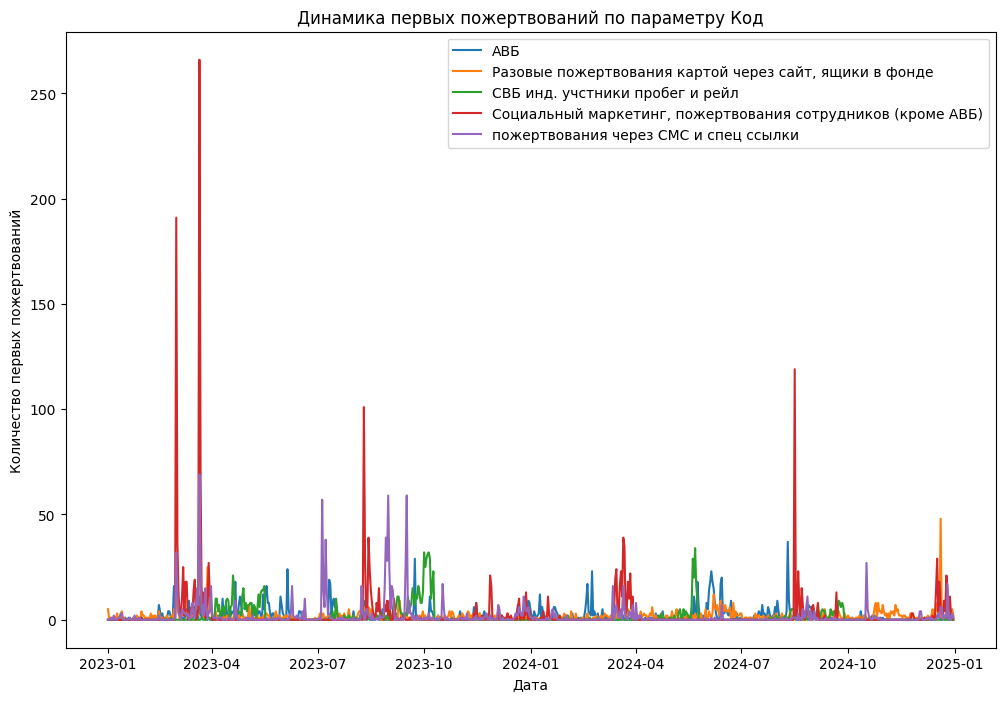

In [122]:
graf_dynamik_first_donate_by_col(first_donate, 'code', t=5)

Таблица дат пиков кодов

In [123]:
code_piks = first_donate.groupby(['first_date', 'code'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
code_piks

first_date                                                         code  \
175  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
294  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
295  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
298  2023-03-21                        пожертвования через СМС и спец ссылки   
302  2023-03-22  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
640  2023-07-05                        пожертвования через СМС и спец ссылки   
697  2023-07-20                                      Частные доноры Рассылки   
774  2023-08-10  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
870  2023-08-31                        пожертвования через СМС и спец ссылки   
934  2023-09-16                        пожертвования через СМС и спец ссылки   
1726 2024-05-31                                           ВИД массовые акции   
1947 2024-08-16  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2104 2024-09-28                                                Телемаркетинг   

      users_count  
175           191  
294            74  
295           266  
298            69  
302            67  
640            57  
697            52  
774           101  
870            59  
934            59  
1726           98  
1947          119  
2104           56

### Комменты первых пожертвований

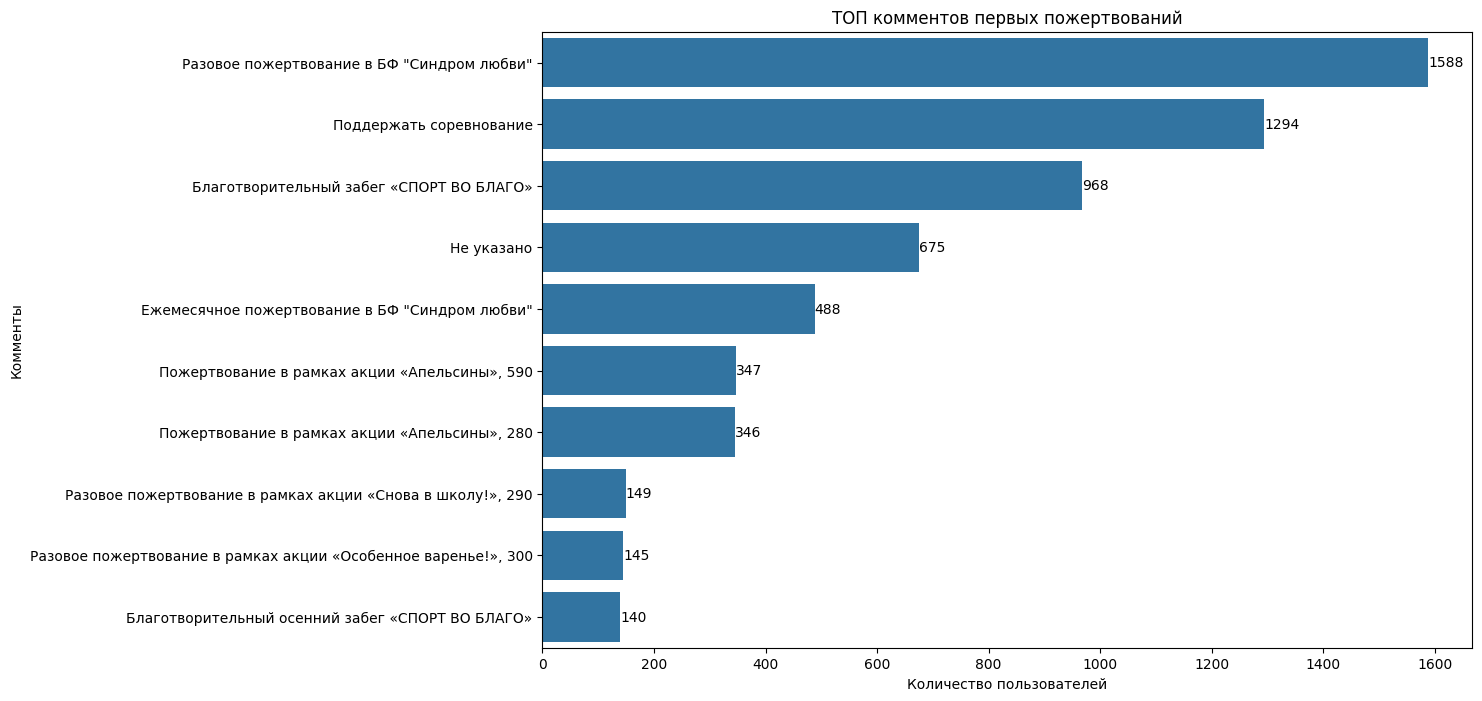

In [124]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['comment'].value_counts().head(10)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП комментов первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Комменты')
plt.show()

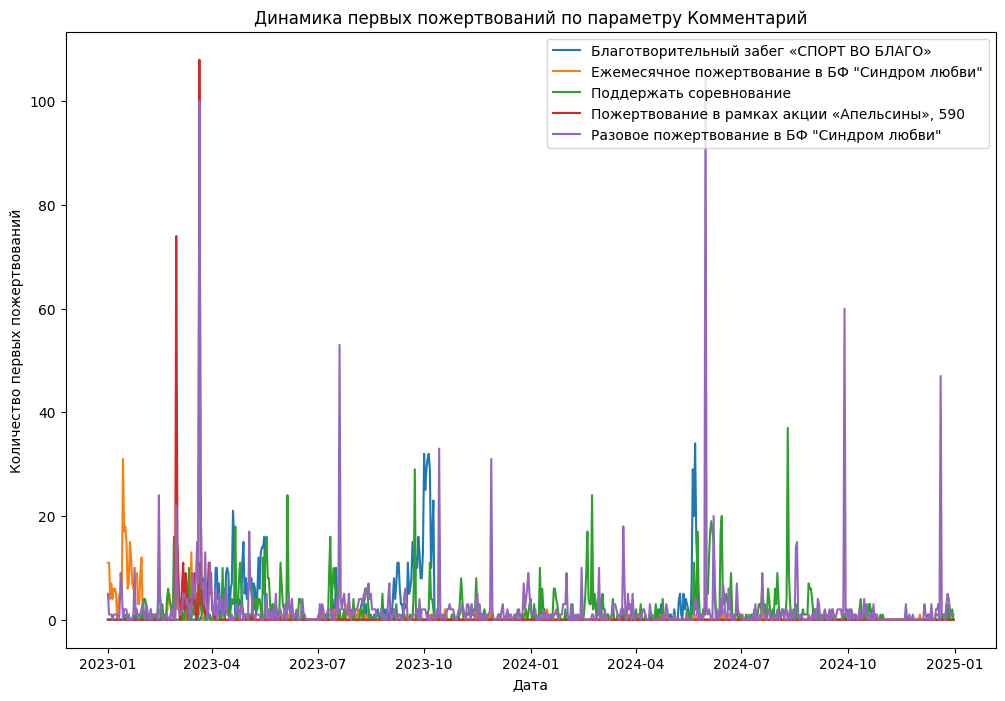

In [125]:
graf_dynamik_first_donate_by_col(first_donate.query('comment != "Не указано"'), 'comment', t=5)

Таблица дат пиков комментариев

In [126]:
comment_piks = first_donate.groupby(['first_date', 'comment'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
comment_piks

first_date  \
176  2023-03-01   
178  2023-03-01   
324  2023-03-21   
328  2023-03-21   
329  2023-03-21   
697  2023-07-05   
763  2023-07-20   
1131 2023-09-16   
2085 2024-05-31   
2320 2024-08-16   
2516 2024-09-28   

                                                                      comment  \
176                             Пожертвование в рамках акции «Апельсины», 280   
178                             Пожертвование в рамках акции «Апельсины», 590   
324                             Пожертвование в рамках акции «Апельсины», 280   
328                             Пожертвование в рамках акции «Апельсины», 590   
329                                Разовое пожертвование в БФ "Синдром любви"   
697                                    Разовое пожертвование "День рождения "   
763                                Разовое пожертвование в БФ "Синдром любви"   
1131                     Разовое пожертвование "Академия успеха Атоми в Сочи"   
2085                               Разовое пожертвование в БФ "Синдром любви"   
2320  Разовое пожертвование в рамках акции «Школа начинается с перемен!», 280   
2516                               Разовое пожертвование в БФ "Синдром любви"   

      users_count  
176           102  
178            74  
324           116  
328           108  
329           100  
697            55  
763            53  
1131           54  
2085          106  
2320           69  
2516           60

### Метки в ссылках первых пожертвований

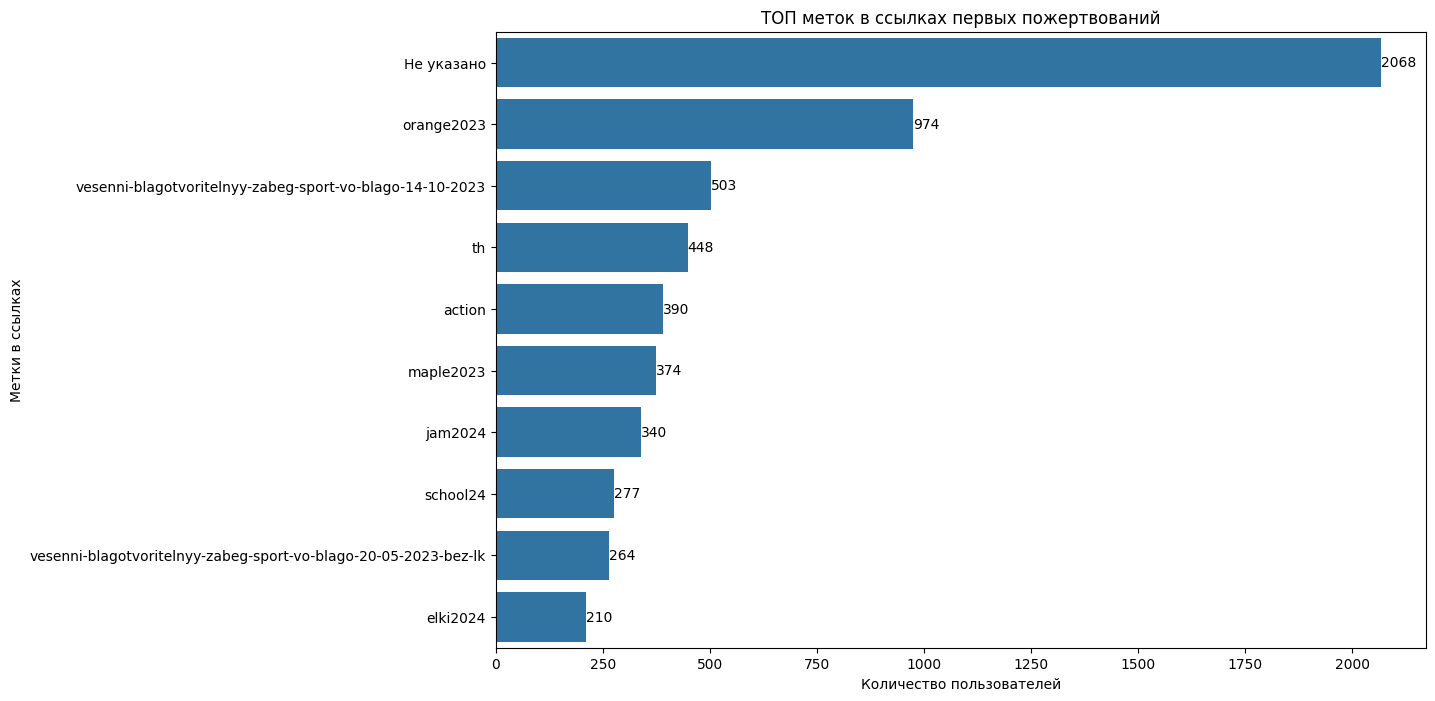

In [127]:
fig = plt.figure(figsize=(12, 8))
dd = first_donate['action'].value_counts().head(10)
ax = sns.barplot(x=dd, y=dd.index, color='tab:blue')
ax.bar_label(ax.containers[0], fontsize=10, label_type='edge', color='black')
plt.title('ТОП меток в ссылках первых пожертвований')
plt.xlabel('Количество пользователей')
plt.ylabel('Метки в ссылках')
plt.show()

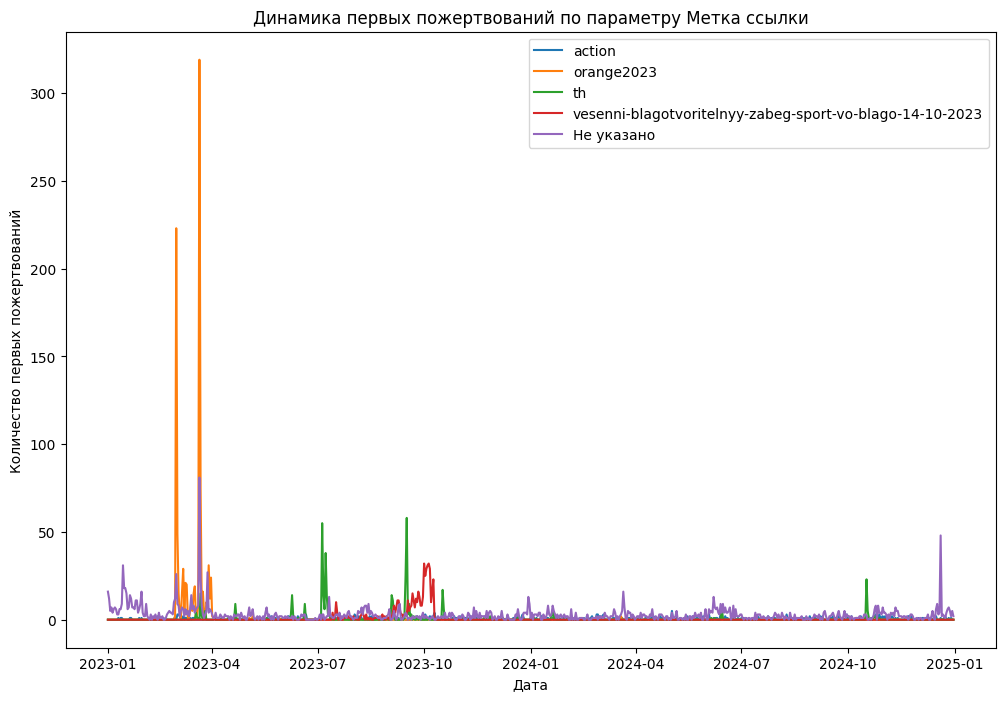

In [128]:
graf_dynamik_first_donate_by_col(first_donate, 'action', t=5)

Таблица дат пиков иеток из ссылок

In [129]:
action_piks = first_donate.groupby(['first_date', 'action'], as_index=False)['user_id'].count()\
    .query('user_id > 50').rename(columns = {'user_id' : 'users_count'})
action_piks

first_date                    action  users_count
134  2023-03-01                orange2023          223
238  2023-03-21                orange2023          319
239  2023-03-21                Не указано           81
246  2023-03-22                orange2023           75
612  2023-07-05                        th           55
670  2023-07-20              EN_needs7.23           54
742  2023-08-10                 maple2023          102
828  2023-08-31                  deti2023           57
898  2023-09-16                        th           58
1461 2024-03-21                   jam2024           55
1651 2024-05-31  MA_charityfair_gymnasium           98
1890 2024-08-16                  school24          120

## Общая таблица параметров наиболее частых в первых пожертвованиях

In [130]:
dd = pd.merge(code_piks[['first_date', 'code']], comment_piks[['first_date', 'comment']], how='outer', on = 'first_date')
pd.merge(dd, action_piks[['first_date', 'action']], how='outer', on = 'first_date')

first_date                                                         code  \
0  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
1  2023-03-01  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
2  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
3  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
4  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
5  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
6  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
7  2023-03-21       Разовые пожертвования картой через сайт, ящики в фонде   
8  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
9  2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
10 2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
11 2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
12 2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
13 2023-03-21  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
14 2023-03-21                        пожертвования через СМС и спец ссылки   
15 2023-03-21                        пожертвования через СМС и спец ссылки   
16 2023-03-21                        пожертвования через СМС и спец ссылки   
17 2023-03-21                        пожертвования через СМС и спец ссылки   
18 2023-03-21                        пожертвования через СМС и спец ссылки   
19 2023-03-21                        пожертвования через СМС и спец ссылки   
20 2023-03-22  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
21 2023-07-05                        пожертвования через СМС и спец ссылки   
22 2023-07-20                                      Частные доноры Рассылки   
23 2023-08-10  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
24 2023-08-31                        пожертвования через СМС и спец ссылки   
25 2023-09-16                        пожертвования через СМС и спец ссылки   
26 2024-03-21                                                          NaN   
27 2024-05-31                                           ВИД массовые акции   
28 2024-08-16  Социальный маркетинг, пожертвования сотрудников (кроме АВБ)   
29 2024-09-28                                                Телемаркетинг   

                                                                    comment  \
0                             Пожертвование в рамках акции «Апельсины», 280   
1                             Пожертвование в рамках акции «Апельсины», 590   
2                             Пожертвование в рамках акции «Апельсины», 280   
3                             Пожертвование в рамках акции «Апельсины», 280   
4                             Пожертвование в рамках акции «Апельсины», 590   
5                             Пожертвование в рамках акции «Апельсины», 590   
6                                Разовое пожертвование в БФ "Синдром любви"   
7                                Разовое пожертвование в БФ "Синдром любви"   
8                             Пожертвование в рамках акции «Апельсины», 280   
9                             Пожертвование в рамках акции «Апельсины», 280   
10                            Пожертвование в рамках акции «Апельсины», 590   
11                            Пожертвование в рамках акции «Апельсины», 590   
12                               Разовое пожертвование в БФ "Синдром любви"   
13                               Разовое пожертвование в БФ "Синдром любви"   
14                            Пожертвование в рамках акции «Апельсины», 280   
15                            Пожертвование в рамках акции «Апельсины», 280   
16                            Пожертвование в рамках акции «Апельсины», 590   
17                            Пожертвование в рамках акции «Апельсины», 590   
18                               Разовое пожертвование в БФ "Синдром любви"   
19  

**Промежуточные итоги:**

Провели аналогичную сегметацию транзакций и пользователей только первым пожертвованиям пользователей. Занчения ТОПов в сегментации и "пики" динамики должны соответствовать акциям / мероприятиям / рассылкам, которые привлеки наибольшее количество новых пользвателей.

In [131]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:09:05.864592+04:00
 От начала рассчета прошло 0:00:37.209871


# RFM анализ

Строим новую таблицу пользователей, без учета транзакций более 200000 рублей.

In [132]:
rfm_donate_lim = 200000
user_table_rfm = get_user_table(tranz.query('donate < @rfm_donate_lim'))
user_table_rfm.head(5)

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  
0        2023         8      46         2       1.50  Простой       448  
1        2023         4       0         1       1.00  Разовый       622  
2        2023        12       0         1       1.00  Разовый       389  
3        2023         6       0         1       1.00  Разовый       571  
4        2023         5       0         1       1.00  Разовый       593

Смотрим статпоказатели метрик для определения границ рангов

In [133]:
user_table_rfm[['donate_sum', 'oper_frec', 'day_last']].describe()

donate_sum  oper_frec  day_last
count     8601.00    8601.00   8601.00
mean      4365.16       0.97    346.56
std      18732.28       0.41    219.86
min          0.01       0.09      0.00
25%        500.00       1.00    139.00
50%       1000.00       1.00    346.00
75%       3000.00       1.00    534.00
max     986000.00      10.81    730.00

Ранги RFM 1 - хорошо, 2 - нормально, 3 - плохо

- Для границ рангов M (сумма донатов) возьмем 2000 и 750 рублей - как среднее между 1, 2 и 3 квантилями
- Для границ рангов R (давность последнего) возьмем 45 и 180 дней. 45 дней как 1,5 срока ежемесячного периода, а 180 как среднее между 1 и 2 квартилями.
- Для F (частота донатов в месяц) в третий ранг возьмем разовых пользователей, граница между 2 и 3 рангом будет 0.7 - чуть меньше средней частоты донатов без учета разовых жертводателей


In [134]:
user_table_rfm['R'] = user_table_rfm['day_last'].apply(lambda x: '1' if x < 45 else ('2' if x < 180 else '3'))

#user_table_rfm['F'] = user_table_rfm['oper_frec'].apply(lambda x: '1' if x > 2 else ('2' if x > 0.90 else '3'))
user_table_rfm['F'] = user_table_rfm.apply(lambda row: '3' if row['day_on'] == 0 else ('2' if row['oper_frec'] < 0.8 else '1'), axis=1)

user_table_rfm['M'] = user_table_rfm['donate_sum'].apply(lambda x: '1' if x > 2000 else ('2' if x > 750 else '3'))
user_table_rfm['RFM'] = user_table_rfm['R'] + user_table_rfm['F'] + user_table_rfm['M']
user_table_rfm.head()

user_id first_date  last_date  donate_sum  tr_count  first_month  \
0   333699 2023-08-25 2023-10-10     3000.00         3            8   
1   333801 2023-04-19 2023-04-19     2000.00         1            4   
2   333803 2023-12-08 2023-12-08      500.00         1           12   
3   333873 2023-06-09 2023-06-09     2000.00         1            6   
4   334671 2023-05-18 2023-05-18    70000.00         1            5   

   first_year  first_ym  day_on  month_on  oper_frec     type  day_last  R  F  \
0        2023         8      46         2       1.50  Простой       448  3  1   
1        2023         4       0         1       1.00  Разовый       622  3  3   
2        2023        12       0         1       1.00  Разовый       389  3  3   
3        2023         6       0         1       1.00  Разовый       571  3  3   
4        2023         5       0         1       1.00  Разовый       593  3  3   

   M  RFM  
0  1  311  
1  2  332  
2  3  333  
3  2  332  
4  1  331

In [135]:
rfm_table = user_table_rfm.groupby(['R', 'F', 'M'], as_index = False).agg({'RFM' : 'first', 'tr_count' : ['count', 'sum'], 'donate_sum' : 'sum', 'last_date' : 'max'})
rfm_table.columns = ['R', 'F', 'M', 'RFM', 'rfm_users', 'rfm_tr', 'rfm_sum', 'rfm_last_date']
rfm_table['avg_sum'] = round(rfm_table['rfm_sum'] / rfm_table['rfm_tr'], 2)
rfm_table

R  F  M  RFM  rfm_users  rfm_tr    rfm_sum rfm_last_date  avg_sum
0   1  1  1  111        368    7697 8860353.26    2024-12-31  1151.14
1   1  1  2  112         20     158   27231.00    2024-12-30   172.35
2   1  1  3  113         19      85    7350.00    2024-12-31    86.47
3   1  2  1  121        152    1112 2814391.00    2024-12-31  2530.93
4   1  2  2  122         43     182   64151.00    2024-12-31   352.48
5   1  2  3  123         12      28    6562.00    2024-12-30   234.36
6   1  3  1  131         84      93  637535.00    2024-12-31  6855.22
7   1  3  2  132        108     110  138370.00    2024-12-30  1257.91
8   1  3  3  133        192     193   71397.03    2024-12-31   369.93
9   2  1  1  211         88     961 2343062.00    2024-11-16  2438.15
10  2  1  2  212         27      87   37549.00    2024-11-12   431.60
11  2  1  3  213         24      65   10519.00    2024-11-16   161.83
12  2  2  1  221        264    1260 2912930.00    2024-11-16  2311.85
13  2  2  2  222         82     237  115581.00    2024-11-15   487.68
14  2  2  3  223         27      65   13615.00    2024-11-11   209.46
15  2  3  1  231        244     271 1745191.00    2024-11-13  6439.82
16  2  3  2  232        180     195  248808.00    2024-11-13  1275.94
17  2  3  3  233        524     530  191573.00    2024-11-16   361.46
18  3  1  1  311        177    1165 2112712.00    2024-07-02  1813.49
19  3  1  2  312        128     381  172882.00    2024-07-02   453.76
20  3  1  3  313         48     136   19290.00    2024-06-30   141.84
21  3  2  1  321        335    1028 3016433.20    2024-06-28  2934.27
22  3  2  2  322        179     435  242548.00    2024-07-01   557.58
23  3  2  3  323         77     172   36759.00    2024-07-03   213.72
24  3  3  1  331       1046    1099 8479469.39    2024-07-01  7715.62
25  3  3  2  332       1481    1514 2209101.99    2024-07-01  1459.12
26  3  3  3  333       2672    2697 1009411.00    2024-07-04   374.27

In [136]:
rfm_table['R'] = rfm_table['R'].replace({'1':'1/Недавние', '2' : '2/Спящие', '3': '3/Уходящие'})
rfm_table['F'] = rfm_table['F'].replace({'1':'1/Частые', '2' : '2/Редкие', '3': '3/Разовые'})
rfm_table['M'] = rfm_table['M'].replace({'1':'1/Большой чек', '2' : '2/Средний чек', '3': '3/Малый чек'})
rfm_table['RF'] = rfm_table['R'] + rfm_table['F']

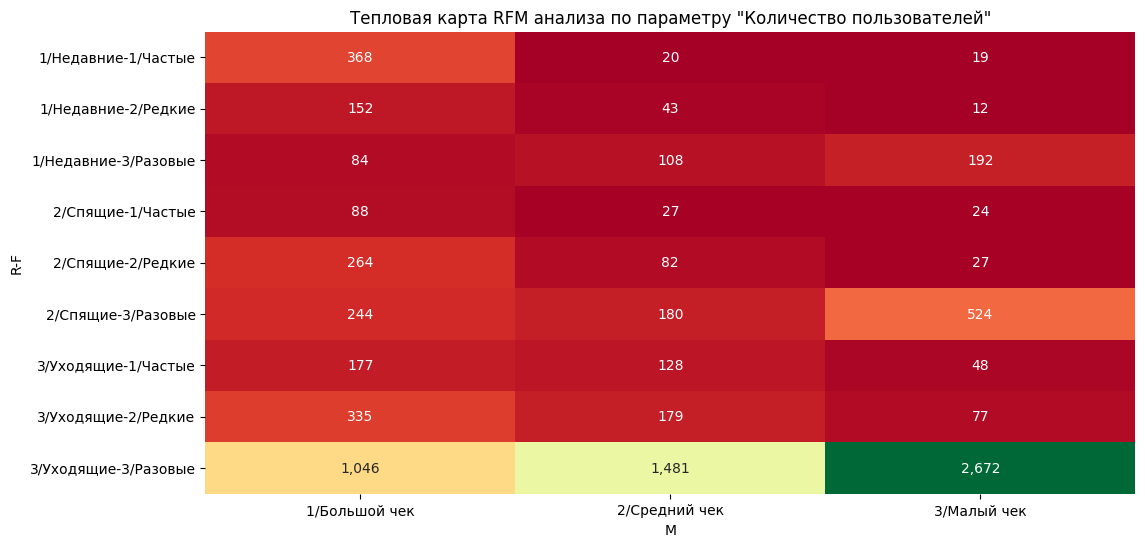

In [137]:
show_rfm_table_sns(rfm_table, 'rfm_users')

БОльше всего пользователей в самой стремной категориия: Уходящие / Разовые / Малый чек.

In [138]:
r3f3_u = rfm_table.query('R == "3/Уходящие" and F == "3/Разовые"')['rfm_users'].sum() / rfm_table['rfm_users'].sum()
print(f'Уходящие/Разовые {r3f3_u:.2%}')

Уходящие/Разовые 60.45%


На "Уходящих / Разовых" приходится порядка 2/3 всех пользователей...

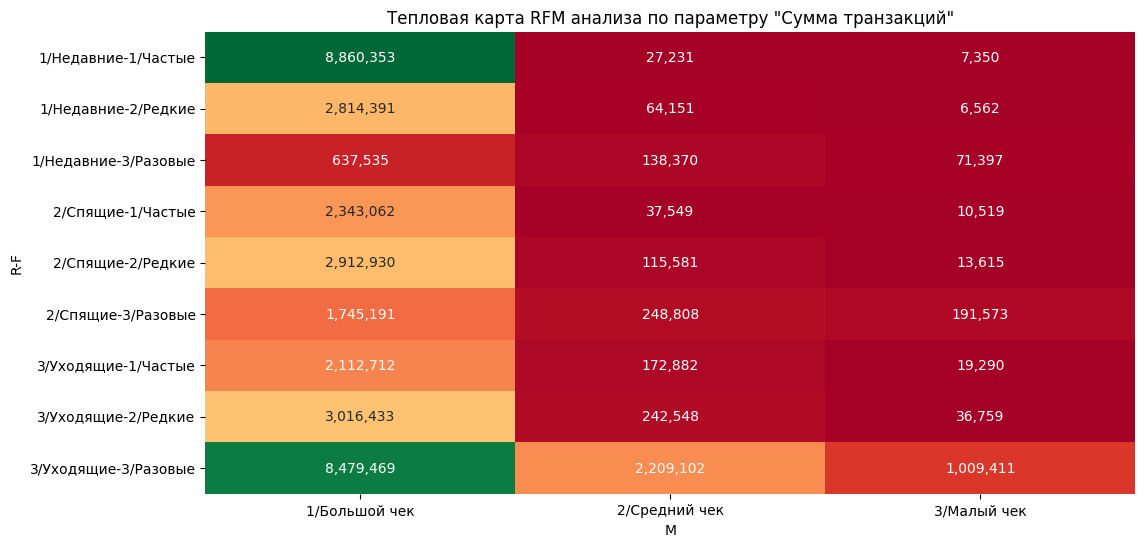

In [139]:
show_rfm_table_sns(rfm_table, 'rfm_sum')

In [140]:
r3f3_d = rfm_table.query('R == "3/Уходящие" and F == "3/Разовые"')['rfm_sum'].sum() / rfm_table['rfm_sum'].sum()
print(f'Уходящие/Разовые {r3f3_d:.2%}')

Уходящие/Разовые 31.16%


Тем не менее "Уходящие / Разовые" приносят и денег практически наравне с "Частыми / Недавними" примерно третий суммы донатов. А если бы "Уходящие / Разовые" перевести хотя бы в категорию "Редкие" ... то донатов было бы больше.

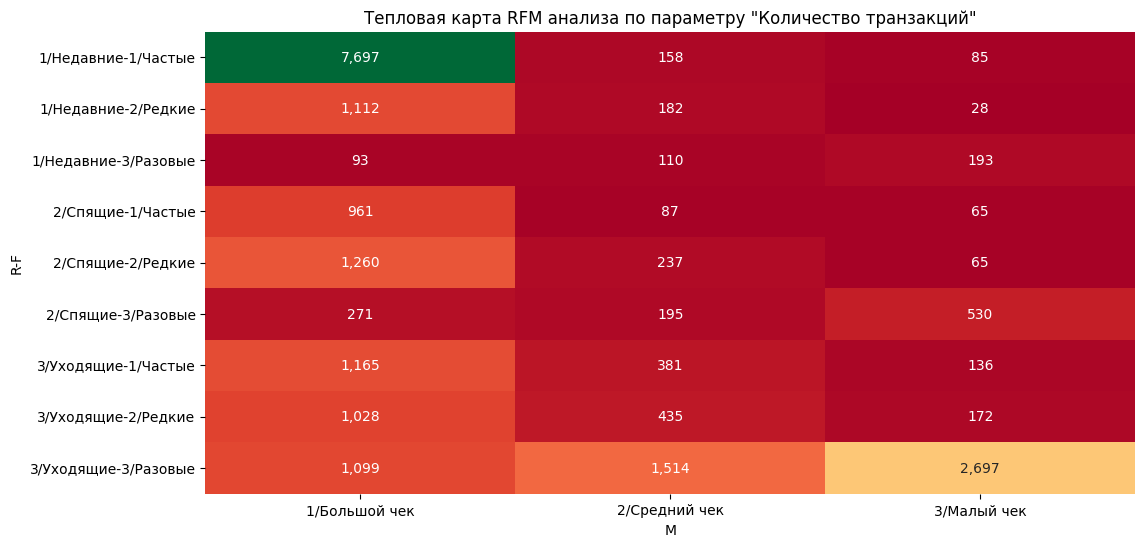

In [141]:
show_rfm_table_sns(rfm_table, 'rfm_tr')

По транзакция все ождаемо - больше всего их у подписков, то есть в категории Недачние / Частые.

**Промежуточные итоги:**

RFM анализ показал большую поляризацию пользователей на разовых и подписчиков. Разовых 2/3, а подписчиков менее 10%, при этом они приносят сопоставимые деньги.

# Когортный анализ

Строим таблицу когорт, период когорты - календарный месяц. Горизонт - весь даипазон дат транзакций.

Также не учитываем транзации > 200 000 рублей

In [142]:
user_table = get_user_table(tranz.query('donate < @rfm_donate_lim'))
chogort_table = pd.DataFrame([])
for m in sorted(user_table ['first_ym'].unique()):
  ch_u = user_table .query('first_ym == @m')['user_id'].unique()
  dd = tranz.query('user_id.isin(@ch_u) and donate < @rfm_donate_lim').groupby('tr_ym', as_index=False)\
      .agg({'user_id': 'nunique', 'id' : 'count', 'donate' : 'sum', 'tr_y':'first', 'tr_m': 'first'})
  dd['ch_m'] = f"{dd['tr_y'][0]}_{dd['tr_m'][0]:0>2}"
  dd['m_live'] = dd['tr_ym'] - m + 1
  dd['ltv'] = dd['donate'].cumsum()
  dd['ltv_m'] = round(dd['ltv'] / dd['m_live'])
  dd['rr'] = round(100 * dd['user_id'] / len(ch_u), 2)
  dd['cr'] =round(dd['user_id'] / dd['user_id'].shift(1), 2)
  chogort_table = pd.concat([chogort_table, dd])

chogort_table.columns = ('tr_mon', 'user_count', 'tr_count', 'donate_sum',
                        'tr_y',  'tr_m',  'ch', 'm_live',
                        'ltv', 'ltv_m', 'rr', 'cr')
chogort_table.head(5)

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1         360       384   510166.00  2023     1  2023_01       1   
1       2         268       296   278389.00  2023     2  2023_01       2   
2       3         277       345   344994.00  2023     3  2023_01       3   
3       4         260       292   261058.00  2023     4  2023_01       4   
4       5         257       285   342810.00  2023     5  2023_01       5   

         ltv     ltv_m     rr   cr  
0  510166.00 510166.00 100.00  NaN  
1  788555.00 394278.00  74.44 0.74  
2 1133549.00 377850.00  76.94 1.03  
3 1394607.00 348652.00  72.22 0.94  
4 1737417.00 347483.00  71.39 0.99

In [143]:
seg_u = tranz['user_id'].unique()
chogort_table = get_chogort_table(tranz.query('user_id.isin(@seg_u) and donate < @rfm_donate_lim'), seg_u)

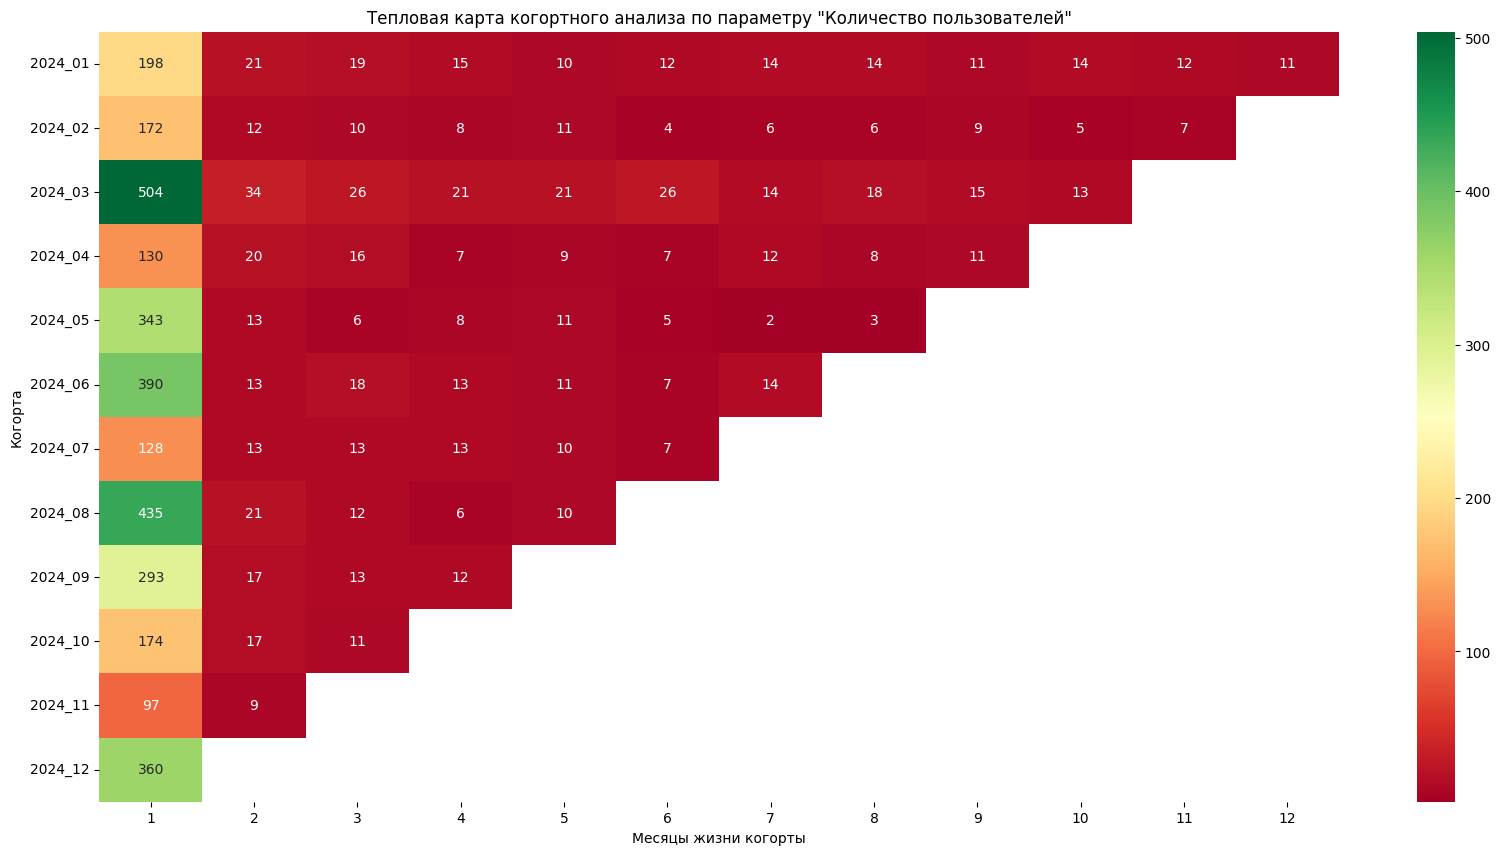

In [144]:
show_chogort_table_sns(chogort_table, col='user_count', ml=12)

Когортный анализ подтверждает то, что подавляющие большинство пользователей после первого доната исчезают.

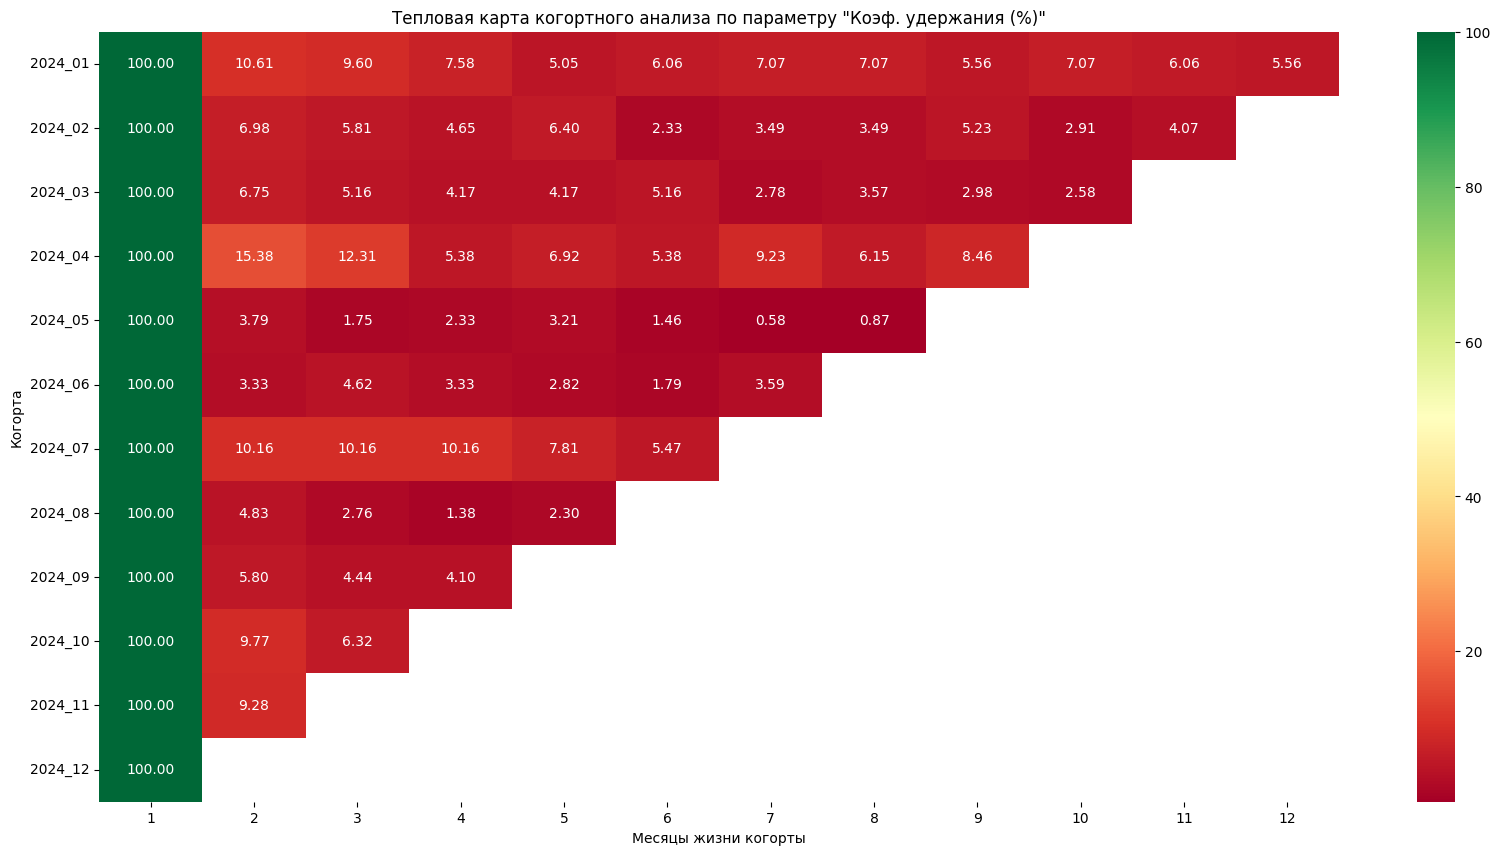

In [145]:
show_chogort_table_sns(chogort_table, col='rr', pr=2, ml=12)

 Через месяц остается  меньше 10%, которые потом как правило остаются верны сервису.

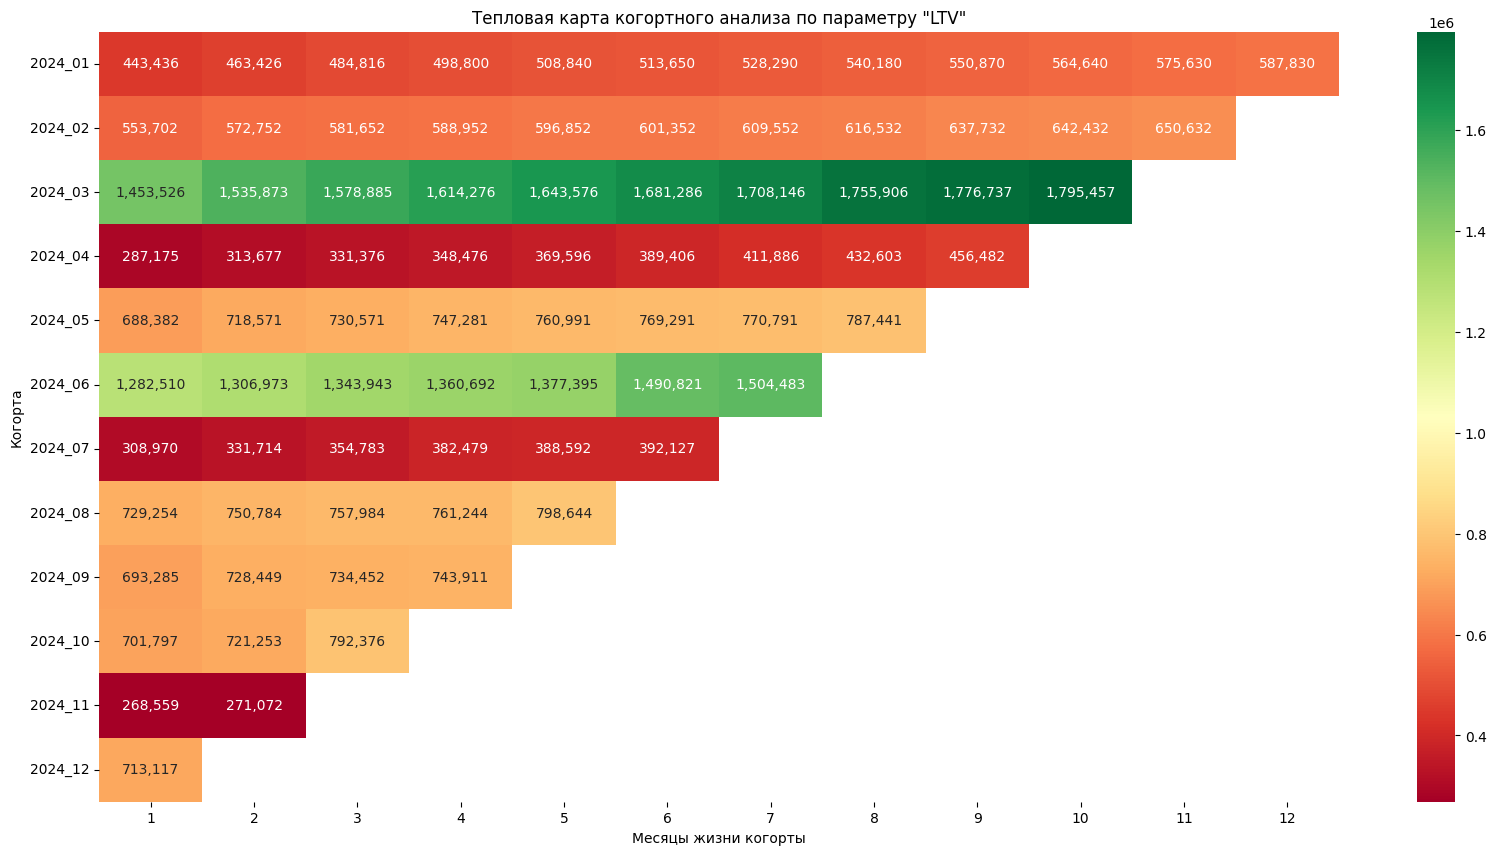

In [146]:
show_chogort_table_sns(chogort_table, col='ltv', pr=0, ml=12)

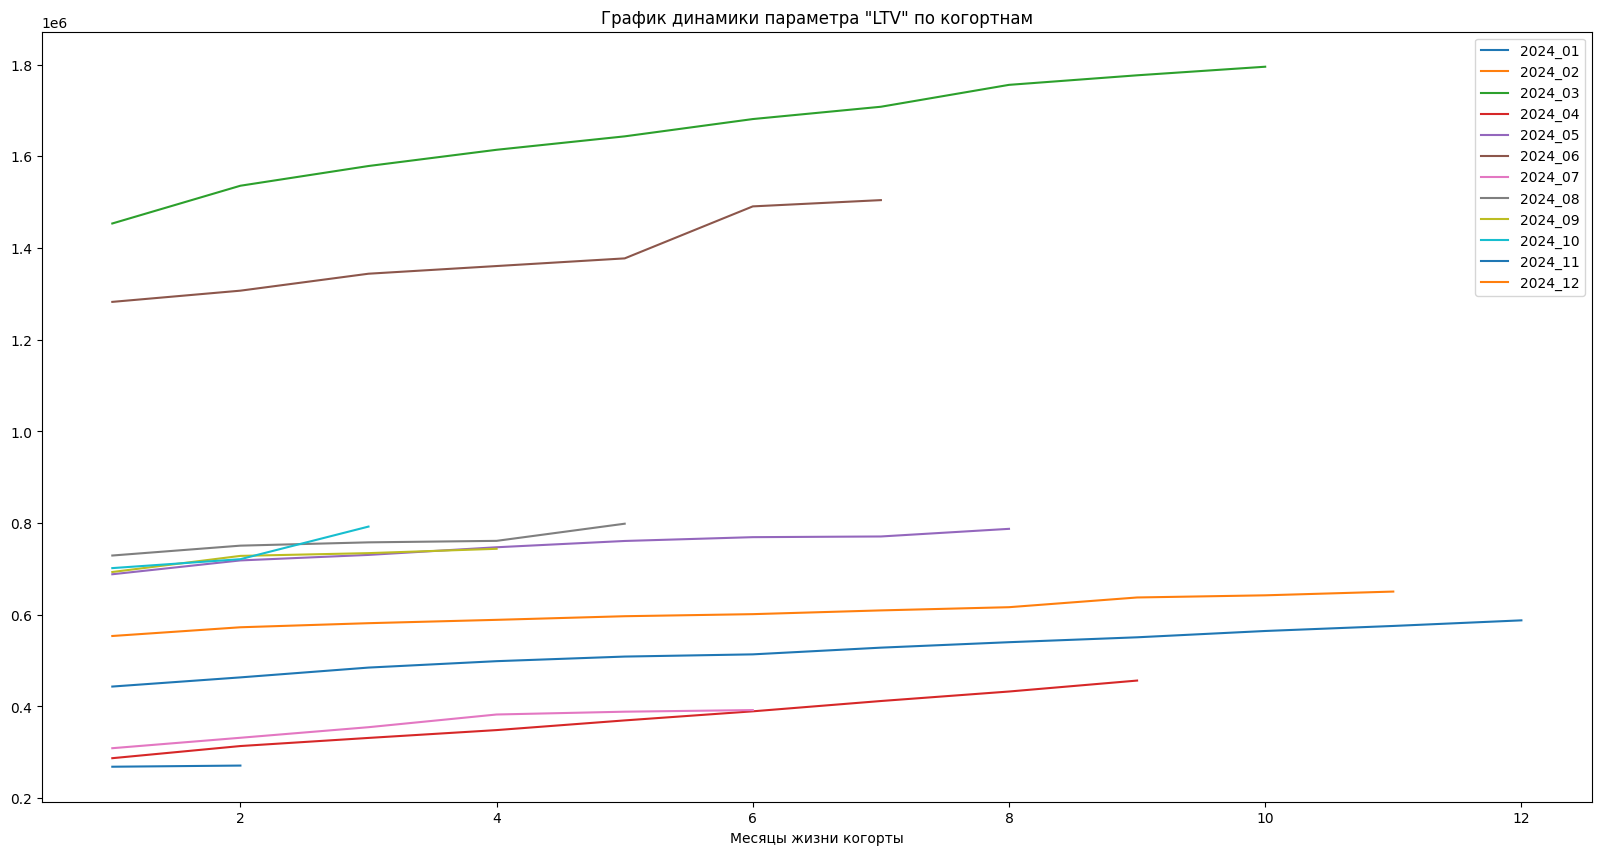

In [147]:
show_chogort_graf(chogort_table, col='ltv', ml=12)

За 2024 год по параметру LTV самые удачные когорты мартовская и июньская - изначально высокая база и стабильный рост после.

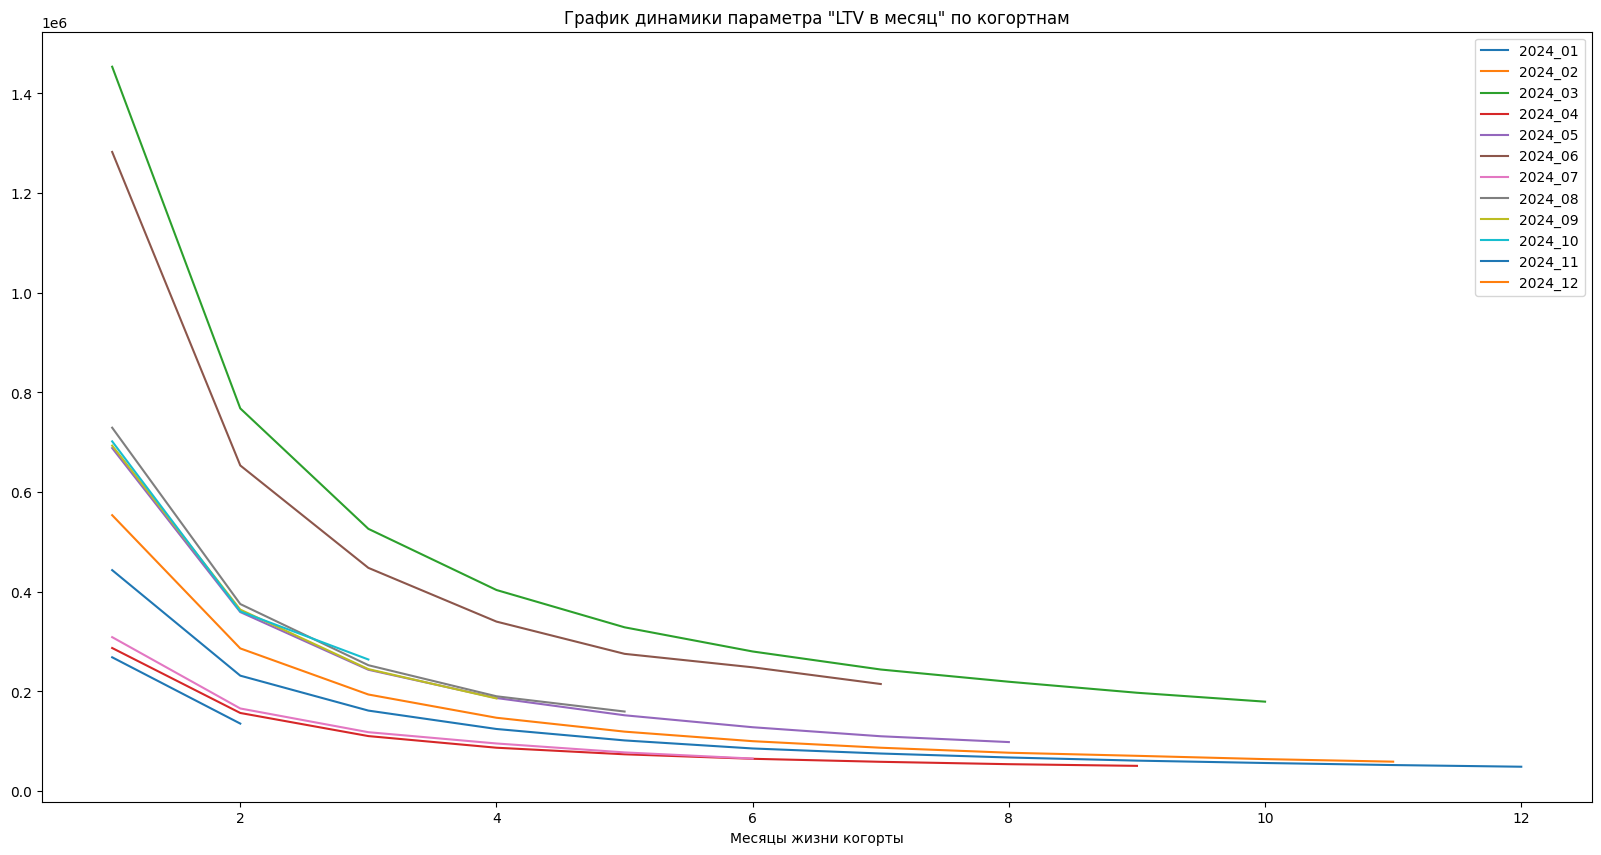

In [148]:
show_chogort_graf(chogort_table, col='ltv_m', ml=12)

**Промежуточные итоги:**

Когортный анализ показал, что только 10% новых пользователей лояльны сервису - тоесть остаются и делают повторные пожертвования. Наиболее удачные когорты в 2024 году - мартовская и июнская.

In [149]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:09:11.849905+04:00
 От начала рассчета прошло 0:00:43.195185


# Сегментация донаторов

## Доли сегментов по сумме донатов, транзакцям, людям

Агрегированные данные по сегментам

In [150]:
user_seg = user_table.groupby('type').agg({'donate_sum' : 'sum', 'tr_count' : 'sum', 'user_id' : 'count'})
user_seg.loc['Компания'] = corp.agg({'donate' : 'sum', 'id' : 'count', 'comp_id' : 'nunique'}).to_list()
user_seg['d_t'] = user_seg['donate_sum'] / user_seg['tr_count']
user_seg['d_u'] = user_seg['donate_sum'] / user_seg['user_id']

user_seg

donate_sum  tr_count  user_id       d_t       d_u
type                                                        
Подписчик 10484931.04   9166.00   567.00   1143.89  18491.94
Простой   12358457.42   6112.00  1527.00   2022.00   8093.29
Разовый   14701386.41   6678.00  6507.00   2201.47   2259.32
Компания  23566818.00    178.00    36.00 132397.85 654633.83

По общим суммам в сегментах лидируют корпоративные донаторы, при этом их исчезающие мало в разрезе коилчества транзакций и наименований.

Простые и разовые донаторы приносят примерно одинаково. Суммарные пожертвоания от подписчиков меньше всего, но они все еще составляют значимую часть бюджета.

По среднему донату на человека из сегментов ситуация диаметрально противоположная - подписчик приносит в среднем за два года 18,5 тысяч рублей, поростой донаторв - 11,5, а разовый только 2,8 тысячи рублей.



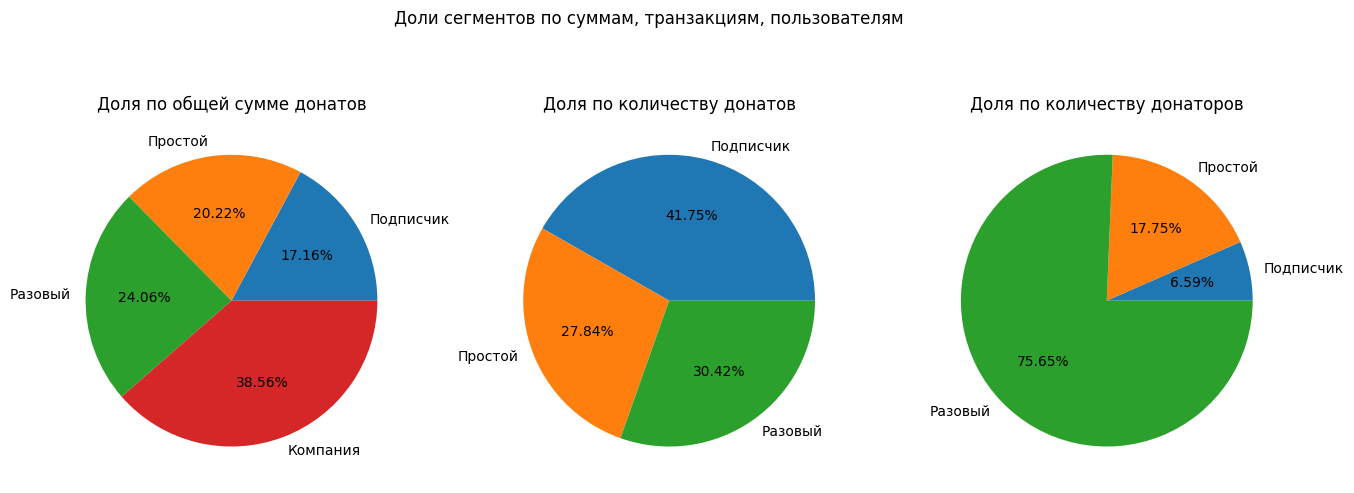

In [151]:
f, ax = plt.subplots(1, 3, figsize=(16,6))
dd = user_seg['donate_sum']
ax[0].pie(x = dd.values, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p))
ax[0].set_title('Доля по общей сумме донатов')

dd = user_seg['tr_count'][0:3]
ax[1].pie(x = dd.values, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p))
ax[1].set_title('Доля по количеству донатов')

dd = user_seg['user_id'][0:3]
ax[2].pie(x = dd.values, labels = dd.index,  autopct=lambda p : '{:.2f}%'.format(p))
ax[2].set_title('Доля по количеству донаторов')

plt.suptitle('Доли сегментов по суммам, транзакциям, пользователям')
plt.show()

## Динамика роста общей суммы донатов в сегментах

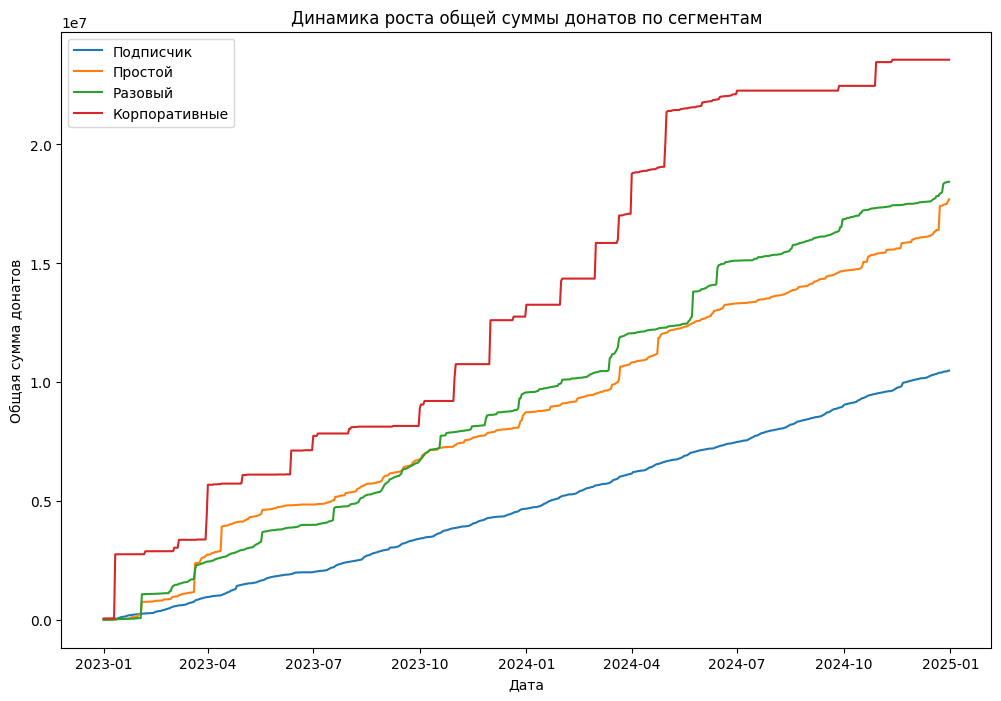

In [152]:
fig = plt.figure(figsize=(12, 8))
for seg in seg_users:
  seg_u = seg_users[seg]
  dd = tranz.query('user_id.isin(@seg_u)').groupby('date')['donate'].sum().to_frame()
  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)
  dd['donate_cumsum'] = dd['donate'].cumsum()
  plt.plot(dd.index, dd['donate_cumsum'], label = seg)

ddс = corp.groupby('date')['donate'].sum().to_frame()
ddс = ddс.reindex(date_range, fill_value=0)
ddс['donate_cumsum'] = ddс['donate'].cumsum()
plt.plot(ddс.index, ddс['donate_cumsum'], label = 'Корпоративные')

plt.title(f'Динамика роста общей суммы донатов по сегментам')
plt.xlabel('Дата')
plt.ylabel('Общая сумма донатов')
plt.legend()
plt.show()

График накопительных платежей от корпоративных донаторов имеет выраженный "ступенчатый" характер с выраженынм "ступенями" и "полочками", в которых донатов просто нет. Это говорит об редких, но при этом крупных платежах.

График накопительных платежей от подписчиков практически линейно растает - без резких скачков и нулевых "полочек". Это говорит о регулярных донатах примерно на сопоставимую сумму каждый день.

График накопительных платежей от разовых и простых донаторов линейно растет, но при этом имеет разкие "ступеньки" и не имеет "полочек". Это говорит о наличии регулярных платежей в обоих сегментах, но в некоторые дни наблюдаются резкие скачки сумм донатов, что может быть объявнено проведением каких-либо акций.

## Динамика количества донаторов в сегментах по месяцам

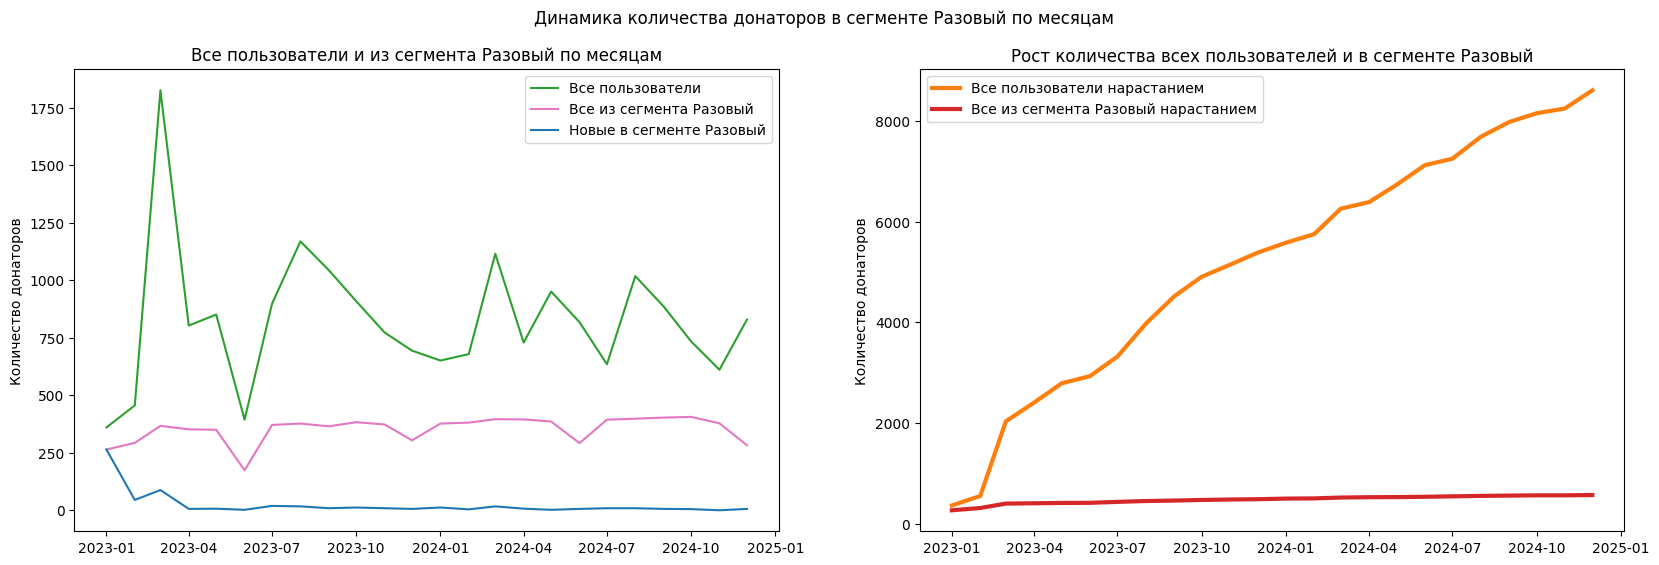

In [153]:
seg_dynamik_graf(tranz, seg_users['Подписчик'])

Количество верных подписчиков, в отличие от количества всех донаторов, из месяца в месяц держится примерно на одном уровне. При этом новеньких подписчиков практически нет. С марта 2023 года по декабрь 2024 количество подписчиков выросло с 380 до 560. Это плохо, так так база лояльных донаторов, которые обеспечивают поступления в неудачные месяцы, не растет.

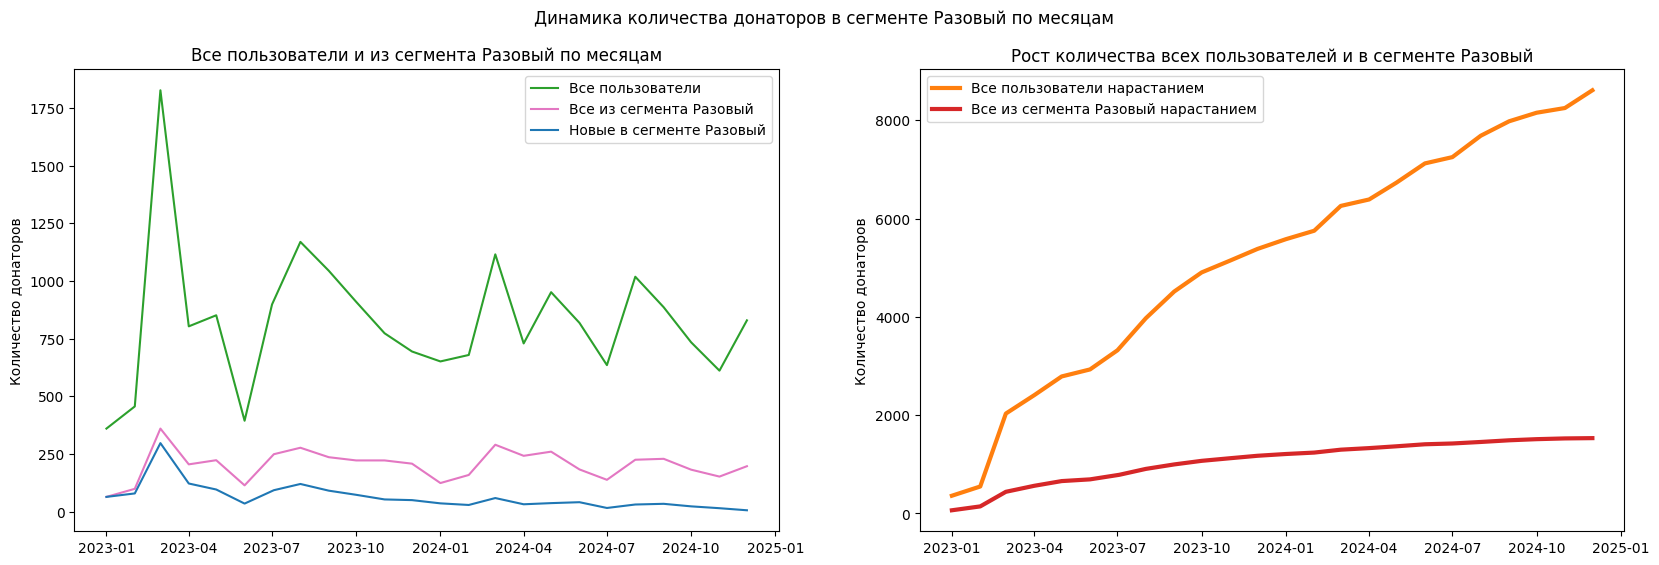

In [154]:
seg_dynamik_graf(tranz, seg_users['Простой'])

Количество простъх донаторов от месяца к месяцу - не стабильно и колеблется, синхронной со всей пользовтелями. Новеньких Простых из месяца в месяц также мало, даже видна тенданция к снижени. База Простых пользователей имеет больший темп роста, чем подписчики, но в 2024 году видно замедление прироста.

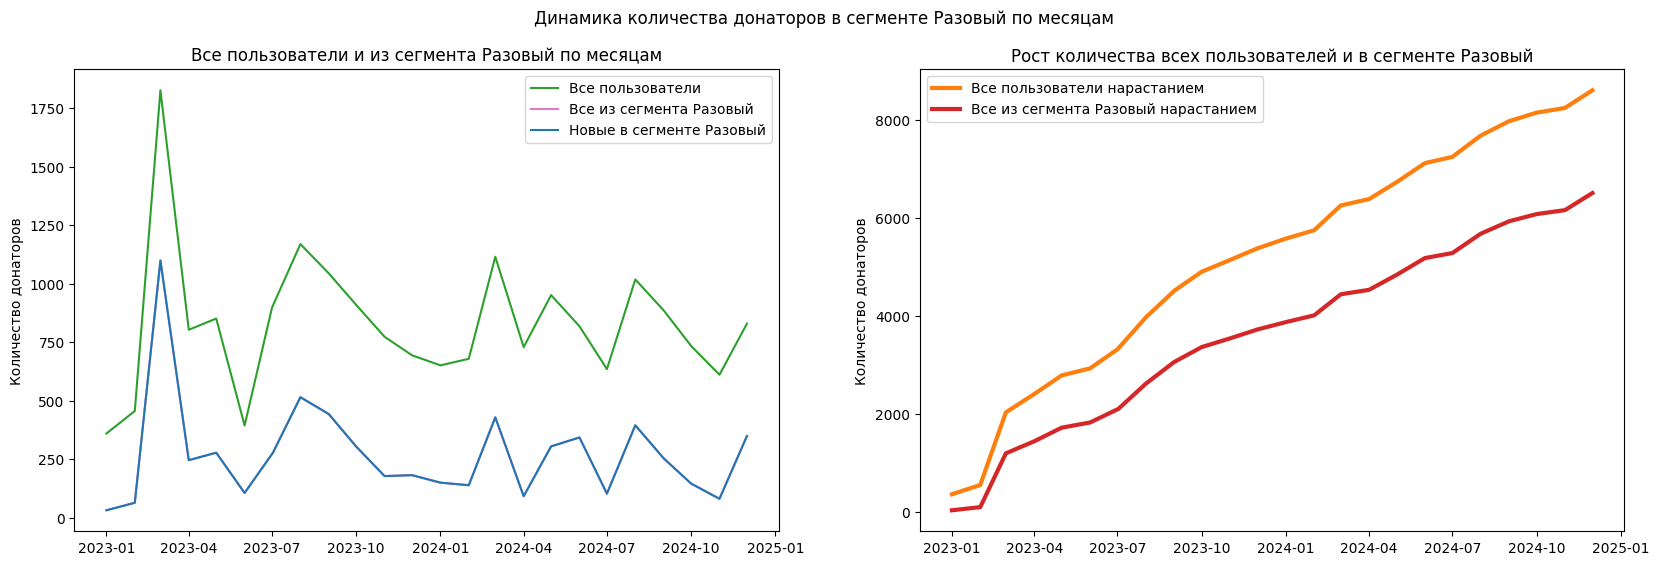

In [155]:
seg_dynamik_graf(tranz, seg_users['Разовый'])

Количество разовых донаторов также подвержено колебаниям из месяца в месяц. Общая база Разовых растет быстрее всего, но пользы от них после перовго пожертвовани - нет.

## Средние донаты в удачные дни по сегментам

Определяем удачные дни, как дни в которых отдельные сегменты собрали более 40 донатов.

In [156]:
goddays = []
for seg in seg_users:
  seg_u = seg_users[seg]
  dd = tranz.query('user_id.isin(@seg_u)').groupby(['date'], as_index=False).agg({'id' : 'count'})
  goddays = goddays + list(dd.query('id > 40')['date'])
goddays = set(goddays)

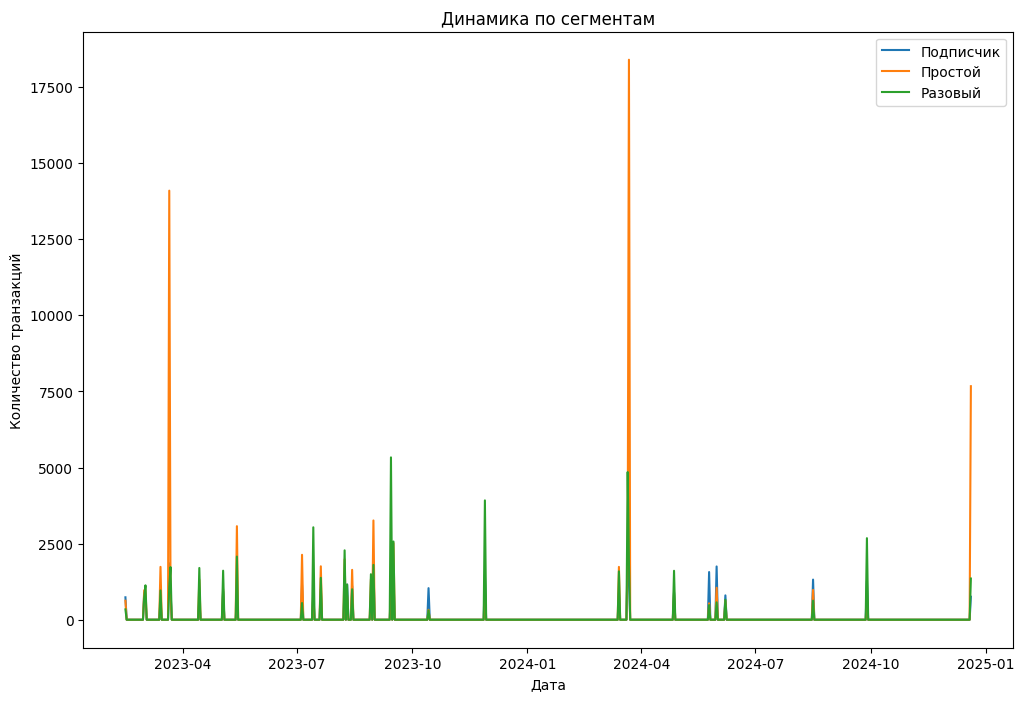

In [157]:
dt_t = pd.DataFrame([])
fig = plt.figure(figsize=(12, 8))
for seg in seg_users:
  seg_u = seg_users[seg]

  dd = tranz.query('date.isin(@goddays) and user_id.isin(@seg_u)').groupby(['date']).agg({'id' : 'count', 'donate' : ['sum', 'mean'], 'user_id' : 'nunique'})
  dd.columns = ['tr_count', 'donate_sum', 'donate_mean', 'user_count']
  dd['seg'] = seg
  dt_t = pd.concat([dt_t, dd])
  date_range = pd.date_range(start=dd.index.min(), end=dd.index.max(), freq='D')
  dd = dd.reindex(date_range, fill_value=0)
  plt.plot(dd.index, dd['donate_mean'], label = seg)


plt.title(f'Динамика по сегментам')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.legend()
plt.show()

Сравнительная таблица средних донатво по сегментам в удачные дни

In [158]:
dpp = dt_t.pivot_table(index = 'date', columns = 'seg', values='donate_mean')
dpp.index = dpp.index.date
dppr = dpp.rank(method = 'first', ascending=False, axis = 1)
dpp.loc['Среднее'] = dpp.mean(axis=0)
dppr.loc['Сумма'] = dppr.sum(axis=0)

dpp.style.format('{:.0f}')\
        .background_gradient(cmap='RdYlGn', axis=1)

Средние донаты в удачные дни у простых донаторов, у разовых среднее значение, у подписчиков - самое низкое.

Сравнительная таблица рангов средних донатов по сегментам в удачные дни, и сумма этих рангов - чем меньше, тем лучше.

In [159]:
dppr.style.format('{:.0f}')\
        .background_gradient(cmap='RdYlGn_r', axis=1)

В удачные дни чаще Разовый простые донаторы имеют наибольший чек примерно в одинаком колмчестве случаев. Подписчики отстают и по этому показателю.

## Сегменты по суммам разовых донатов

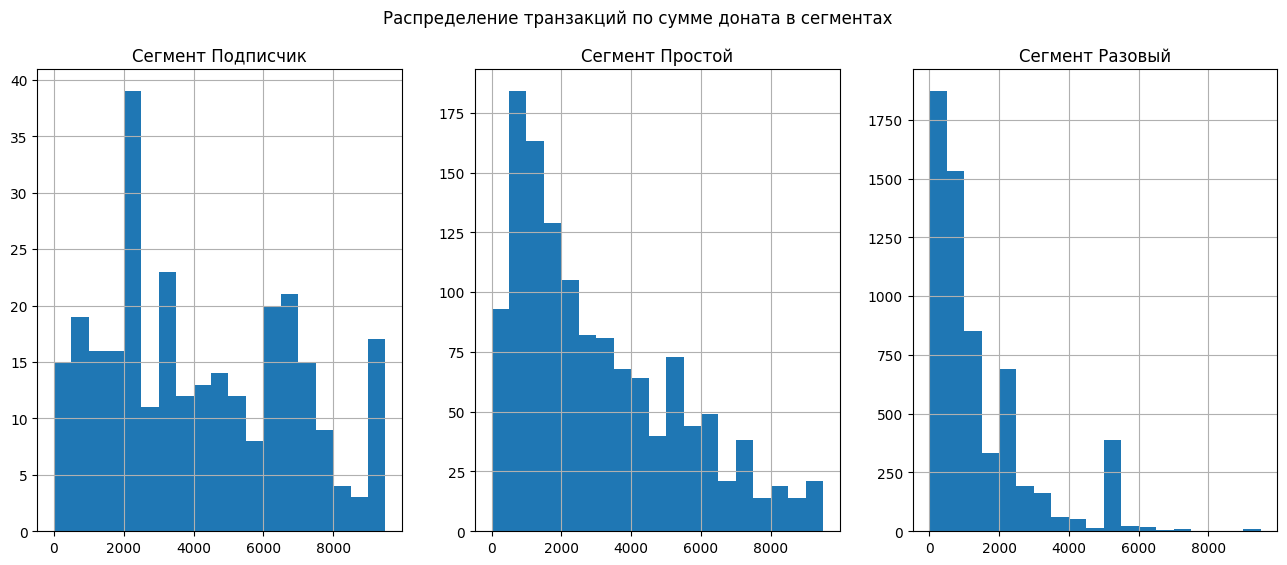

In [160]:
f, ax = plt.subplots(1, 3, figsize=(16, 6))
i = 0
for seg in seg_users:
  user_table.query('type == @seg')['donate_sum'].hist(bins=range(0, 10000, 500), ax = ax[i])
  ax[i].set_title(f'Сегмент {seg}')
  i +=1
plt.suptitle(f'Распределение транзакций по сумме доната в сегментах')
plt.show()

В сегментах также есть различие по сумма донатов. У протых и разовых самые популярные донаты в 500-200 рублей. У попдисчиков суммы единичных донатов более разнообразны.
Пики на всех гарфиках соотвествуют стандартным суммам, которые есть в форме оплаты доната по умолчанию.

## RFM анализ отдельных сегментов донаторов

### Подписчики

In [161]:
seg_u = seg_users['Подписчик']
uuu = get_user_table(tranz.query('user_id.isin(@seg_u)'))
uuu[['donate_sum', 'oper_frec', 'day_last']].describe()

donate_sum  oper_frec  day_last
count      567.00     567.00    567.00
mean     18491.94       0.96    107.00
std      32607.43       0.36    171.38
min         50.00       0.19      0.00
25%       3500.00       0.87     17.00
50%       9500.00       0.96     31.00
75%      21000.00       1.00     88.50
max     375000.00       5.00    729.00

In [162]:
subscr_table = get_rfm_table(tranz, seg_users['Подписчик'], [30, 120, 2, 0.9, 10000, 4000])
subscr_table

R          F              M  RFM  rfm_users  rfm_tr    rfm_sum  \
0   1/Недавние   1/Частые  1/Большой чек  111          4     253  111317.00   
1   1/Недавние   1/Частые    3/Малый чек  113          1       5     263.00   
2   1/Недавние   2/Редкие  1/Большой чек  121        117    2679 4717940.02   
3   1/Недавние   2/Редкие  2/Средний чек  122         48     867  324428.02   
4   1/Недавние   2/Редкие    3/Малый чек  123         33     472   81210.00   
5   1/Недавние  3/Разовые  1/Большой чек  131         28     415  768420.00   
6   1/Недавние  3/Разовые  2/Средний чек  132         23     359  165560.00   
7   1/Недавние  3/Разовые    3/Малый чек  133         19     191   43850.00   
8     2/Спящие   1/Частые  1/Большой чек  211          2      95   85020.00   
9     2/Спящие   1/Частые    3/Малый чек  213          1      11    3080.00   
10    2/Спящие   2/Редкие  1/Большой чек  221         74    1608 2269370.00   
11    2/Спящие   2/Редкие  2/Средний чек  222         28     575  190380.00   
12    2/Спящие   2/Редкие    3/Малый чек  223         17     209   32080.00   
13    2/Спящие  3/Разовые  1/Большой чек  231         17     194  511595.00   
14    2/Спящие  3/Разовые  2/Средний чек  232         17     219  118910.00   
15    2/Спящие  3/Разовые    3/Малый чек  233         14     105   35110.00   
16  3/Уходящие   2/Редкие  1/Большой чек  321         10     149  424420.00   
17  3/Уходящие   2/Редкие  2/Средний чек  322         20     229  140210.00   
18  3/Уходящие   2/Редкие    3/Малый чек  323         51     203   72250.00   
19  3/Уходящие  3/Разовые  1/Большой чек  331          9      85  239662.00   
20  3/Уходящие  3/Разовые  2/Средний чек  332         14     134  105900.00   
21  3/Уходящие  3/Разовые    3/Малый чек  333         20     109   43956.00   

   rfm_last_date  avg_sum                   RF  
0     2024-12-19   439.99   1/Недавние1/Частые  
1     2024-12-12    52.60   1/Недавние1/Частые  
2     2024-12-31  1761.08   1/Недавние2/Редкие  
3     2024-12-30   374.20   1/Недавние2/Редкие  
4     2024-12-31   172.06   1/Недавние2/Редкие  
5     2024-12-31  1851.61  1/Недавние3/Разовые  
6     2024-12-29   461.17  1/Недавние3/Разовые  
7     2024-12-26   229.58  1/Недавние3/Разовые  
8     2024-11-19   894.95     2/Спящие1/Частые  
9     2024-12-01   280.00     2/Спящие1/Частые  
10    2024-12-01  1411.30     2/Спящие2/Редкие  
11    2024-12-01   331.10     2/Спящие2/Редкие  
12    2024-11-29   153.49     2/Спящие2/Редкие  
13    2024-11-29  2637.09    2/Спящие3/Разовые  
14    2024-11-29   542.97    2/Спящие3/Разовые  
15    2024-11-25   334.38    2/Спящие3/Разовые  
16    2024-08-21  2848.46   3/Уходящие2/Редкие  
17    2024-09-02   612.27   3/Уходящие2/Редкие  
18    2024-08-19   355.91   3/Уходящие2/Редкие  
19    2024-09-02  2819.55  3/Уходящие3/Разовые  
20    2024-08-21   790.30  3/Уходящие3/Разовые  
21    2024-08-27   403.27  3/Уходящие3/Разовые

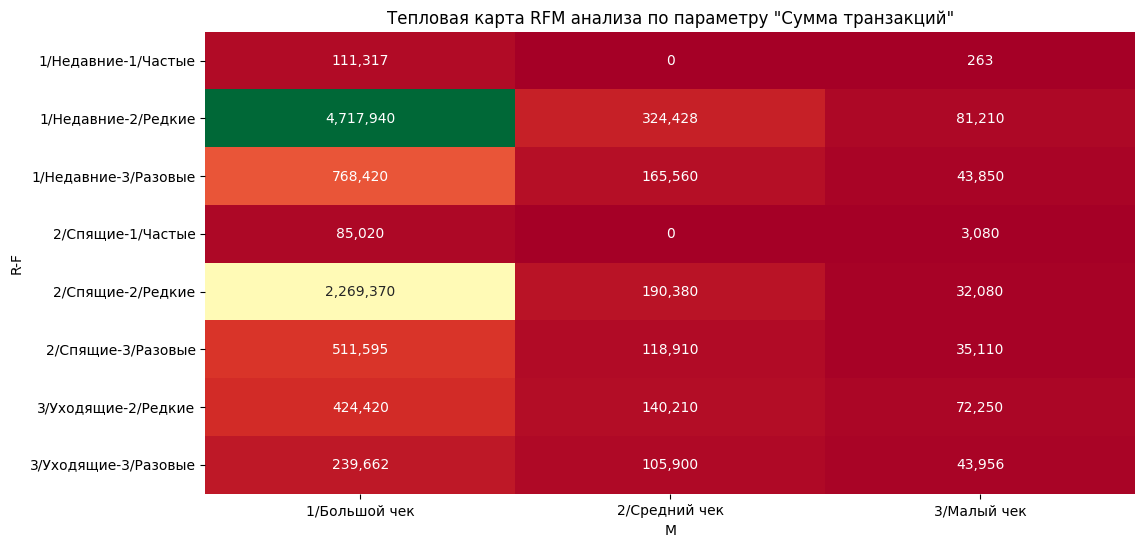

In [163]:
show_rfm_table_sns(subscr_table, 'rfm_sum')

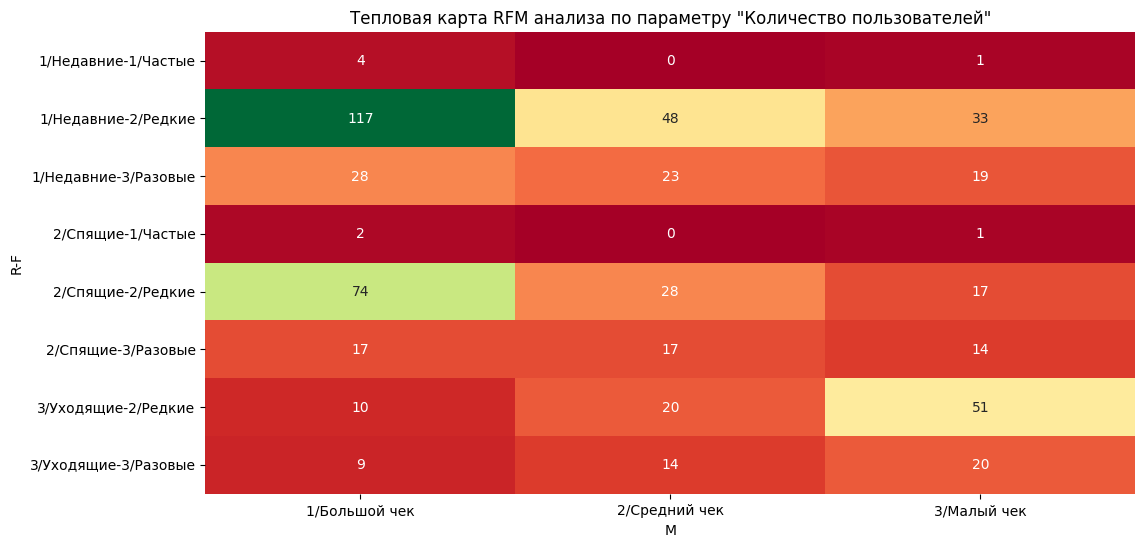

In [164]:
show_rfm_table_sns(subscr_table, 'rfm_users')

### Простые донаторы

In [165]:
seg_u = seg_users['Простой']
uuu = get_user_table(tranz.query('user_id.isin(@seg_u)'))
uuu[['donate_sum', 'oper_frec', 'day_last']].describe()

donate_sum  oper_frec  day_last
count     1532.00    1532.00   1532.00
mean     11550.92       0.72    238.41
std      77207.45       0.80    179.20
min          9.00       0.09      0.00
25%       1210.00       0.25     94.00
50%       3000.00       0.40    213.00
75%       6000.00       1.00    369.00
max    2000000.00       9.72    687.00

In [166]:
simple_rfm = get_rfm_table(tranz, seg_users['Простой'], [120, 240, 2, 0.3, 4500, 1500])
simple_rfm

R          F              M  RFM  rfm_users  rfm_tr    rfm_sum  \
0   1/Недавние   1/Частые  1/Большой чек  111         10     253  360765.00   
1   1/Недавние   1/Частые  2/Средний чек  112          2       7    8200.00   
2   1/Недавние   1/Частые    3/Малый чек  113          9      36    6476.00   
3   1/Недавние   2/Редкие  1/Большой чек  121        126    1202 5008785.22   
4   1/Недавние   2/Редкие  2/Средний чек  122         56     342  166049.00   
5   1/Недавние   2/Редкие    3/Малый чек  123         75     266   55879.00   
6   1/Недавние  3/Разовые  1/Большой чек  131        105     343 3353187.00   
7   1/Недавние  3/Разовые  2/Средний чек  132         74     240  202651.00   
8   1/Недавние  3/Разовые    3/Малый чек  133         41     105   40262.00   
9     2/Спящие   1/Частые  1/Большой чек  211          4     185 1356882.00   
10    2/Спящие   1/Частые  2/Средний чек  212          6      18   13590.00   
11    2/Спящие   1/Частые    3/Малый чек  213          4      14    3790.00   
12    2/Спящие   2/Редкие  1/Большой чек  221         66     465 1158767.00   
13    2/Спящие   2/Редкие  2/Средний чек  222         54     196  157057.00   
14    2/Спящие   2/Редкие    3/Малый чек  223         63     175   47034.00   
15    2/Спящие  3/Разовые  1/Большой чек  231         54     164  491860.98   
16    2/Спящие  3/Разовые  2/Средний чек  232         58     141  167226.00   
17    2/Спящие  3/Разовые    3/Малый чек  233         44      95   39191.00   
18  3/Уходящие   1/Частые  1/Большой чек  311          2      14   55150.00   
19  3/Уходящие   1/Частые  2/Средний чек  312          4      12    9550.00   
20  3/Уходящие   1/Частые    3/Малый чек  313          4      12    2930.00   
21  3/Уходящие   2/Редкие  1/Большой чек  321        136     478 3580843.22   
22  3/Уходящие   2/Редкие  2/Средний чек  322        182     543  506469.00   
23  3/Уходящие   2/Редкие    3/Малый чек  323        174     405  148543.00   
24  3/Уходящие  3/Разовые  1/Большой чек  331         46     113  506036.00   
25  3/Уходящие  3/Разовые  2/Средний чек  332         66     159  187447.00   
26  3/Уходящие  3/Разовые    3/Малый чек  333         67     142   61388.00   

   rfm_last_date  avg_sum                   RF  
0     2024-12-31  1425.95   1/Недавние1/Частые  
1     2024-12-27  1171.43   1/Недавние1/Частые  
2     2024-12-24   179.89   1/Недавние1/Частые  
3     2024-12-31  4167.04   1/Недавние2/Редкие  
4     2024-12-31   485.52   1/Недавние2/Редкие  
5     2024-12-31   210.07   1/Недавние2/Редкие  
6     2024-12-31  9776.06  1/Недавние3/Разовые  
7     2024-12-31   844.38  1/Недавние3/Разовые  
8     2024-12-30   383.45  1/Недавние3/Разовые  
9     2024-08-23  7334.50     2/Спящие1/Частые  
10    2024-09-01   755.00     2/Спящие1/Частые  
11    2024-06-08   270.71     2/Спящие1/Частые  
12    2024-09-02  2491.97     2/Спящие2/Редкие  
13    2024-09-02   801.31     2/Спящие2/Редкие  
14    2024-08-31   268.77     2/Спящие2/Редкие  
15    2024-09-02  2999.15    2/Спящие3/Разовые  
16    2024-09-02  1186.00    2/Спящие3/Разовые  
17    2024-09-02   412.54    2/Спящие3/Разовые  
18    2024-02-25  3939.29   3/Уходящие1/Частые  
19    2023-10-14   795.83   3/Уходящие1/Частые  
20    2024-02-18   244.17   3/Уходящие1/Частые  
21    2024-05-04  7491.30   3/Уходящие2/Редкие  
22    2024-04-27   932.72   3/Уходящие2/Редкие  
23    2024-05-05   366.77   3/Уходящие2/Редкие  
24    2024-05-04  4478.19  3/Уходящие3/Разовые  
25    2024-05-05  1178.91  3/Уходящие3/Разовые  
26    2024-04-27   432.31  3/Уходящие3/Разовые

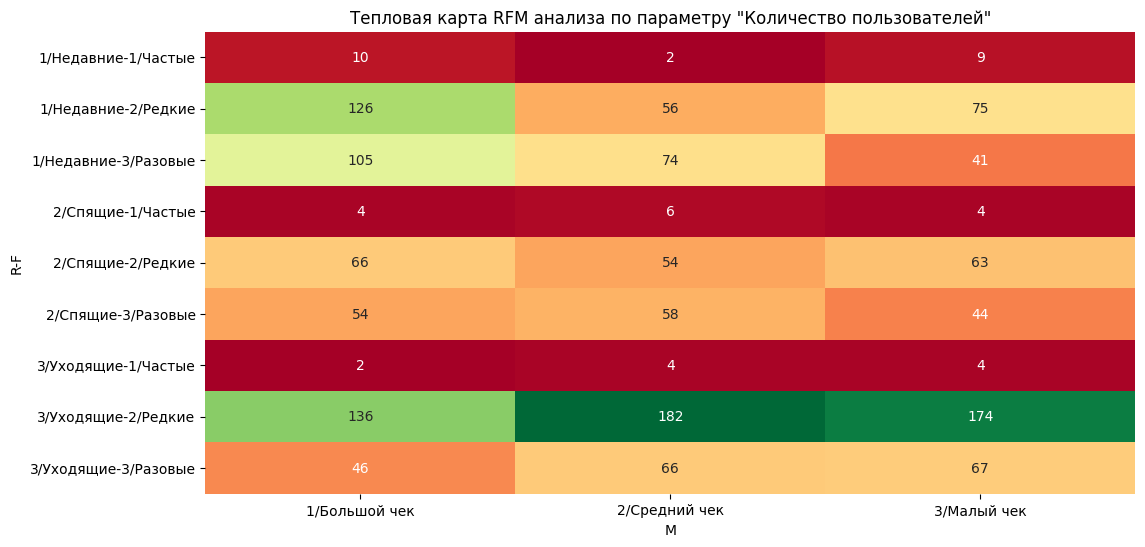

In [167]:
show_rfm_table_sns(simple_rfm, 'rfm_users')

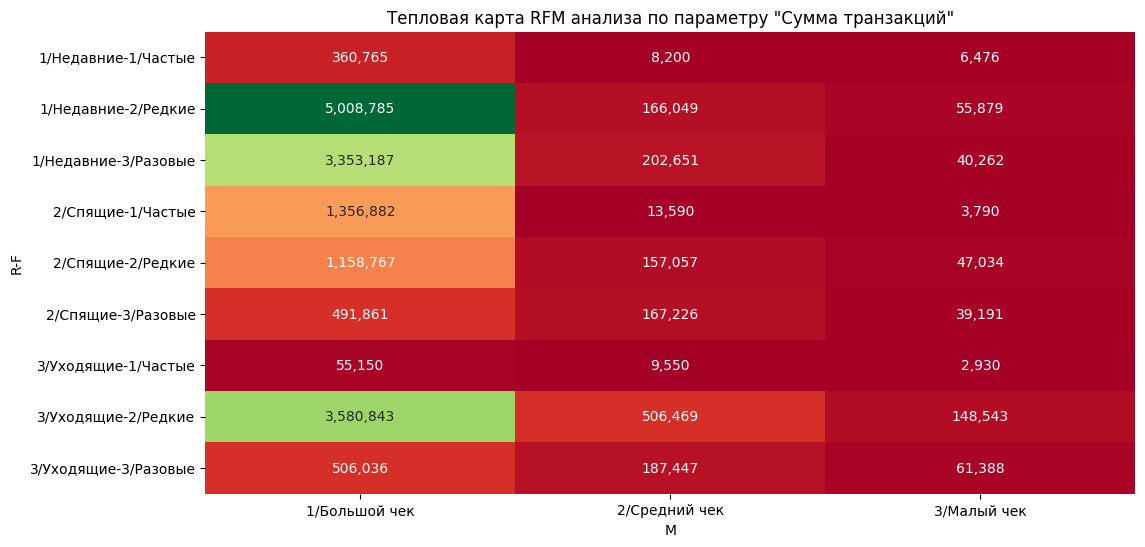

In [168]:
show_rfm_table_sns(simple_rfm, 'rfm_sum')

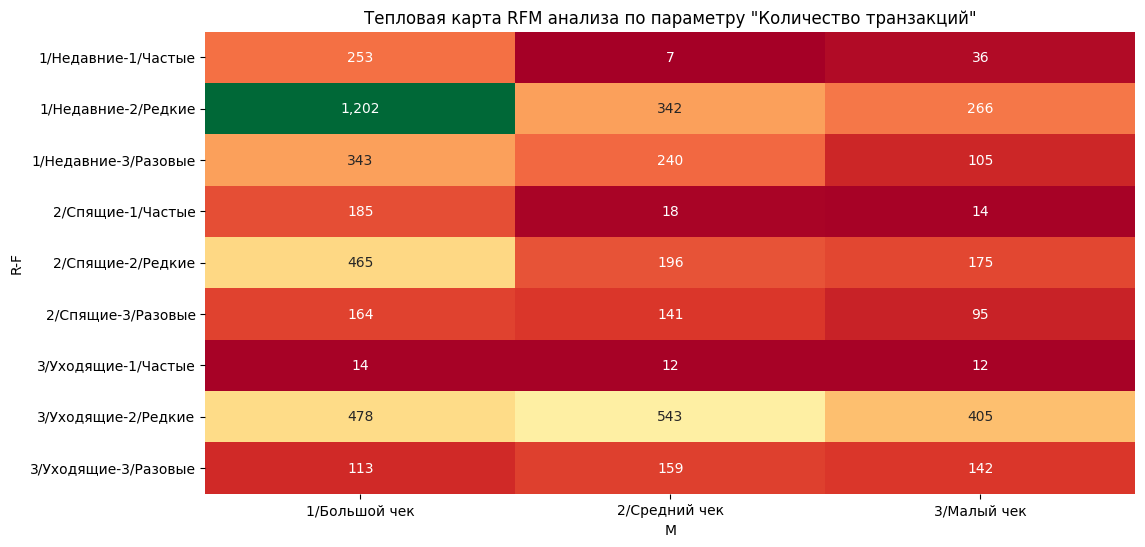

In [169]:
show_rfm_table_sns(simple_rfm, 'rfm_tr')

## Когортный анализ отдельных сегментов донаторов

### Когортный анализ подписчиков

In [170]:
subscr_chogort_table = get_chogort_table(tranz, seg_users['Подписчик'])
subscr_chogort_table.head(5)

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1         264       278   233657.00  2023     1  2023_01       1   
1       2         248       274   227737.00  2023     2  2023_01       2   
2       3         239       280   233806.00  2023     3  2023_01       3   
3       4         235       260   231517.00  2023     4  2023_01       4   
4       5         231       252   225357.00  2023     5  2023_01       5   

         ltv     ltv_m     rr   cr  
0  233657.00 233657.00 100.00  NaN  
1  461394.00 230697.00  93.94 0.94  
2  695200.00 231733.00  90.53 0.96  
3  926717.00 231679.00  89.02 0.98  
4 1152074.00 230415.00  87.50 0.98

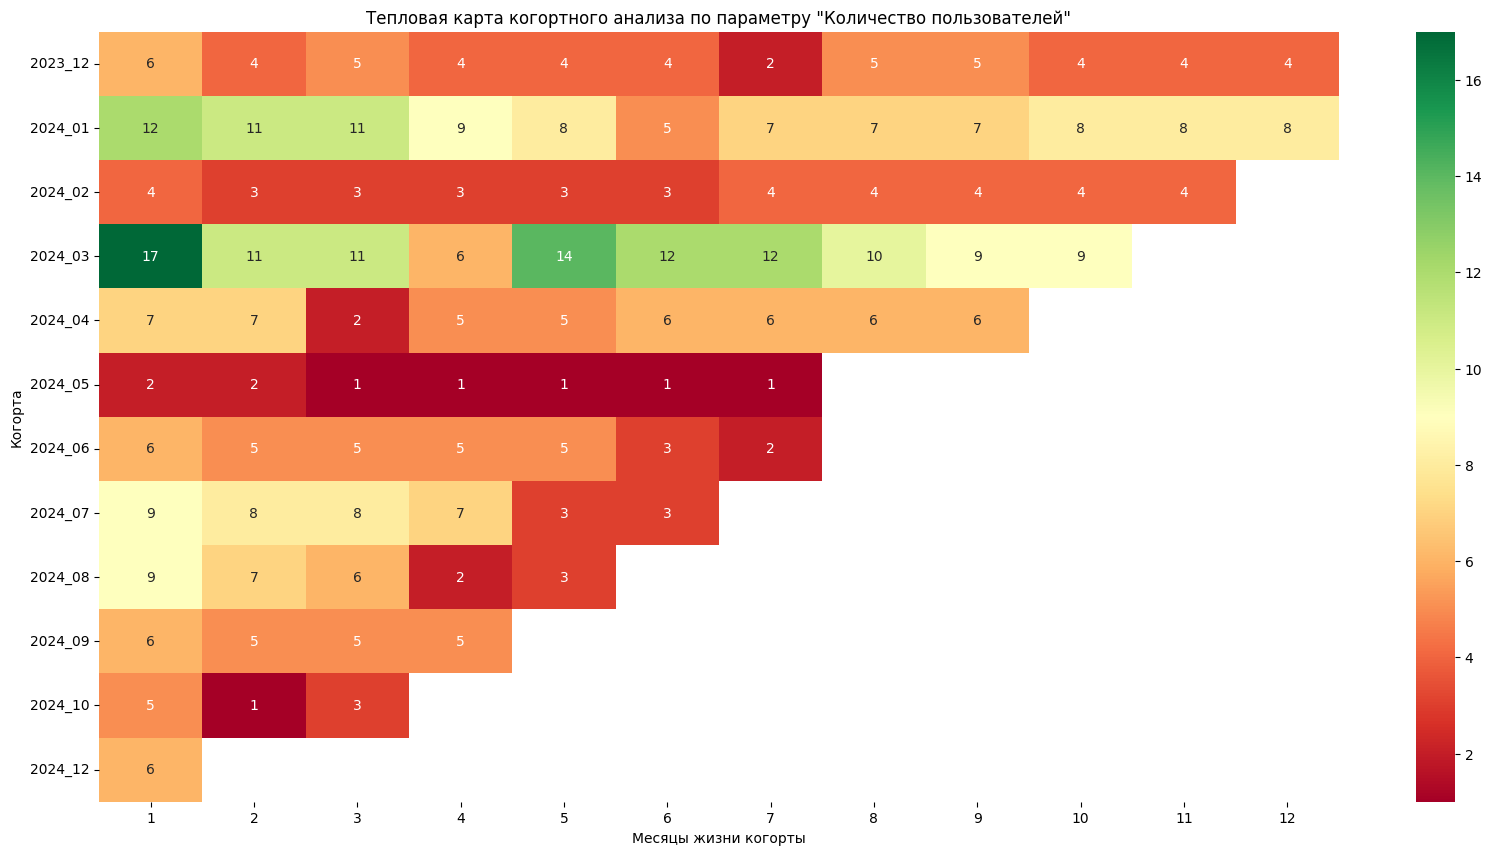

In [171]:
show_chogort_table_sns(subscr_chogort_table, col='user_count', ml=12)

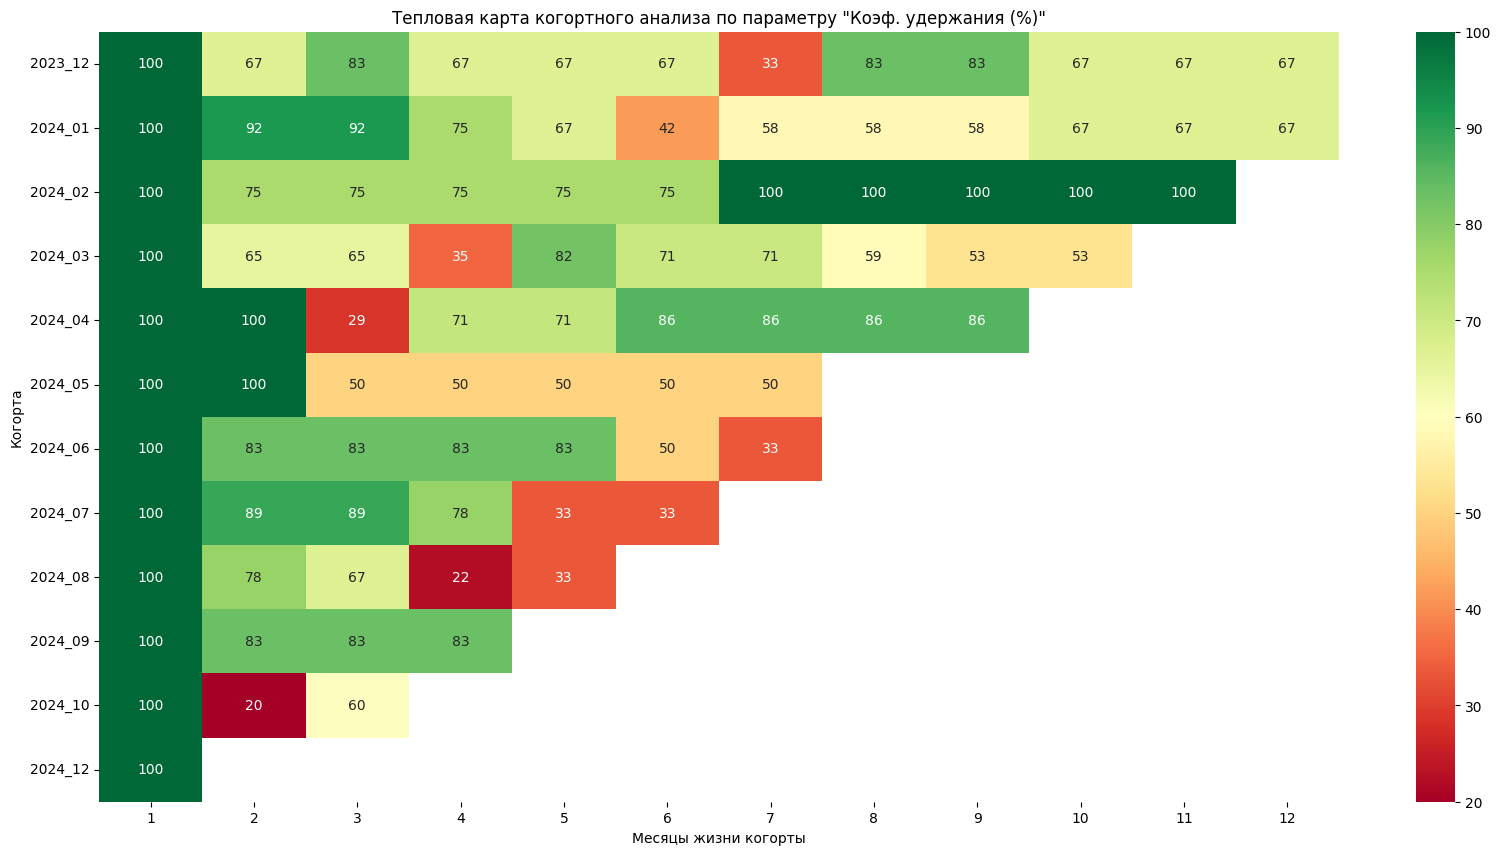

In [172]:
show_chogort_table_sns(subscr_chogort_table, col='rr', ml=12)

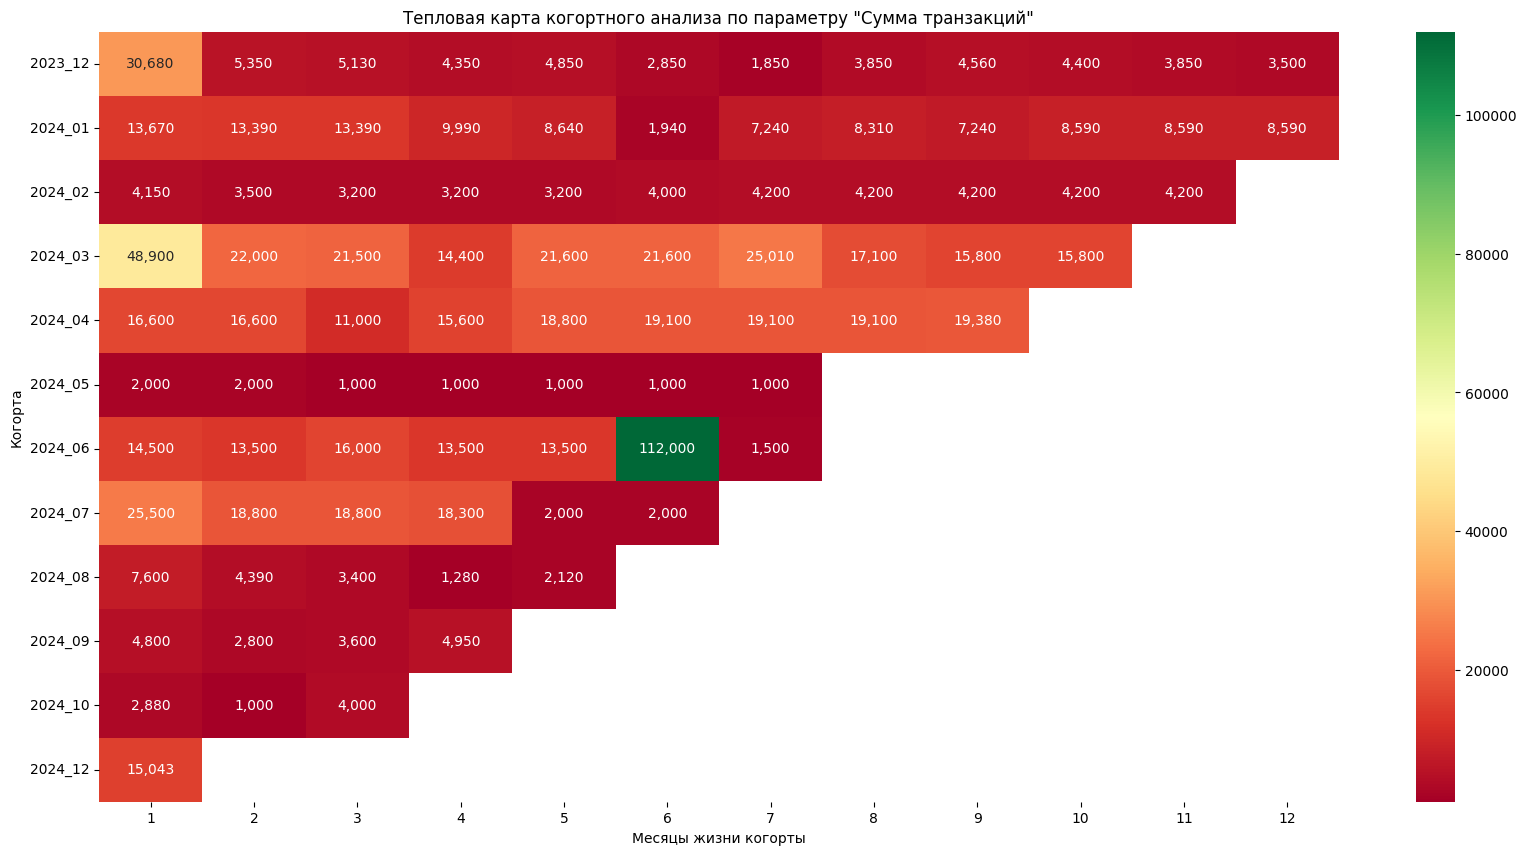

In [173]:
show_chogort_table_sns(subscr_chogort_table, col='donate_sum', ml=12)

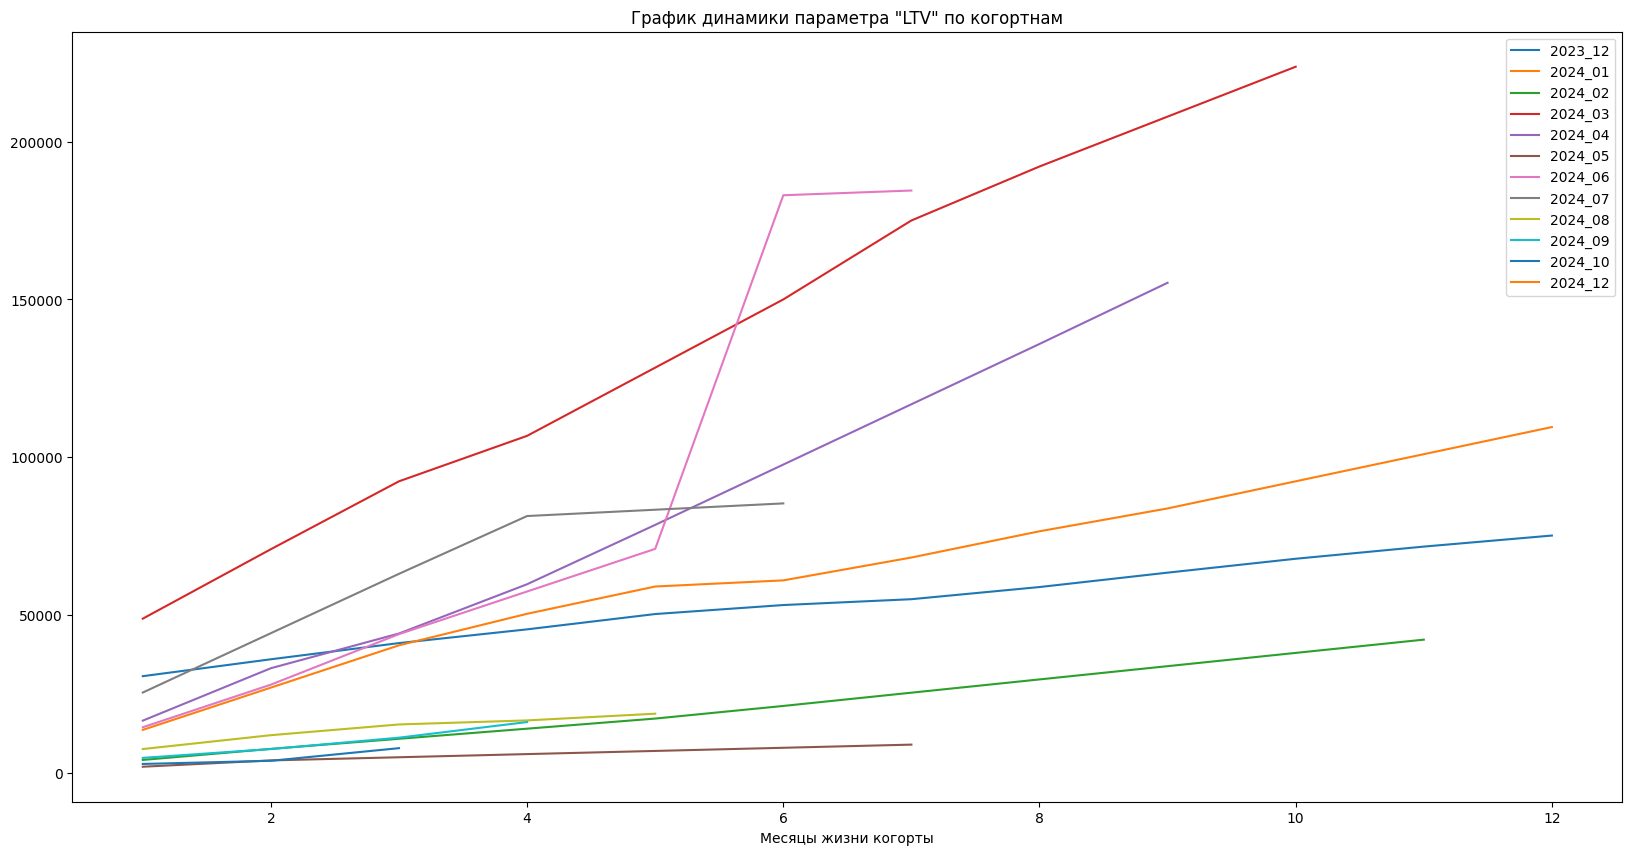

In [174]:
show_chogort_graf(subscr_chogort_table, col='ltv', ml=12)

### Когортный анализ по простых донаторам

In [175]:
simple_chogort_table = get_chogort_table(tranz, seg_users['Простой'])
simple_chogort_table.head(5)

tr_mon  user_count  tr_count  donate_sum  tr_y  tr_m       ch  m_live  \
0       1          64        74   211664.00  2023     1  2023_01       1   
1       2          20        22    50652.00  2023     2  2023_01       2   
2       3          38        65   111188.00  2023     3  2023_01       3   
3       4          25        32    29541.00  2023     4  2023_01       4   
4       5          26        33   117453.00  2023     5  2023_01       5   

        ltv     ltv_m     rr   cr  
0 211664.00 211664.00 100.00  NaN  
1 262316.00 131158.00  31.25 0.31  
2 373504.00 124501.00  59.38 1.90  
3 403045.00 100761.00  39.06 0.66  
4 520498.00 104100.00  40.62 1.04

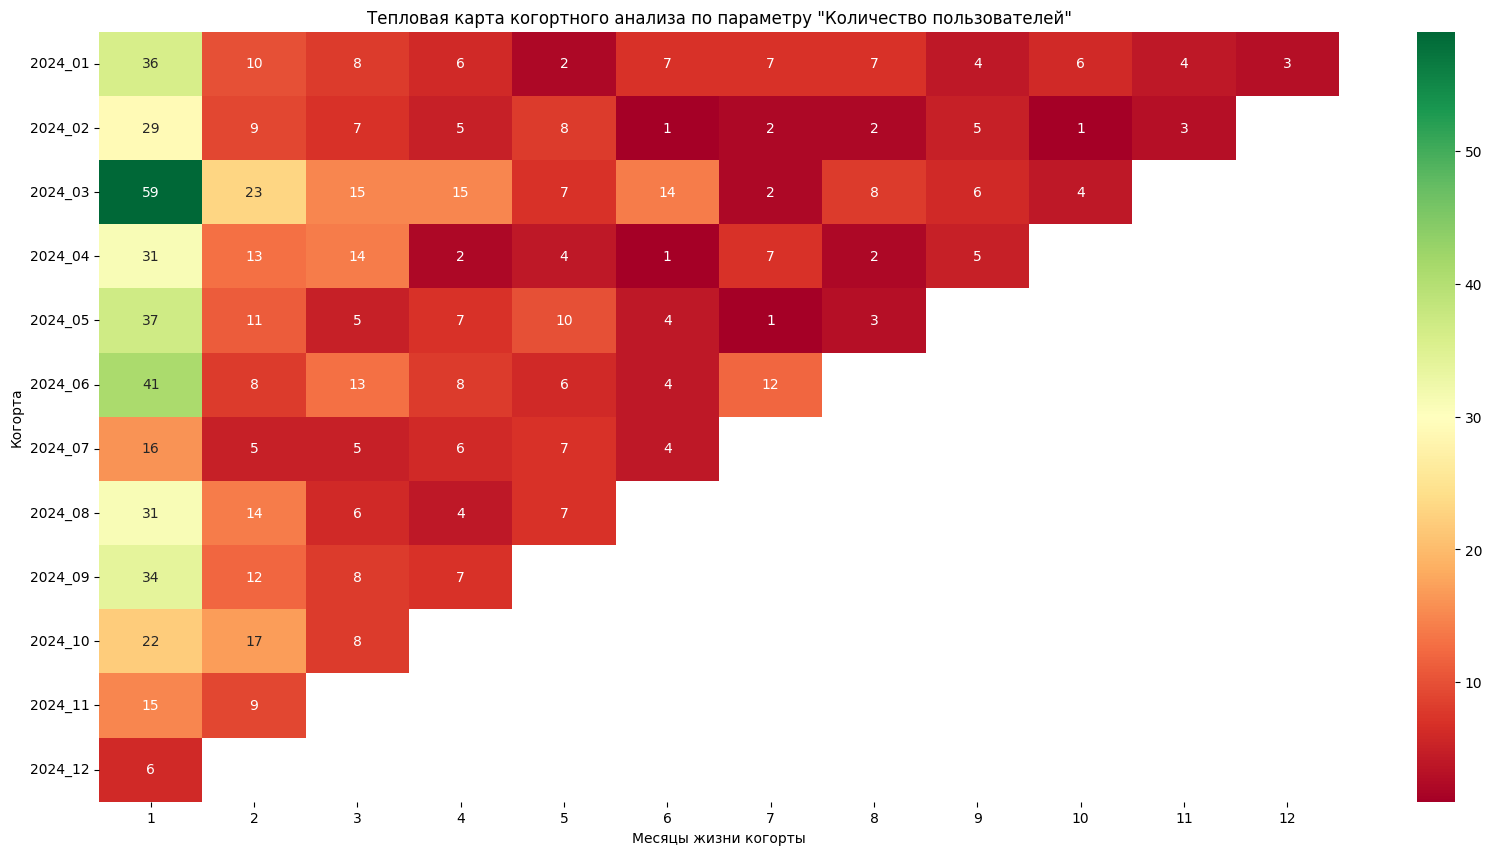

In [176]:
show_chogort_table_sns(simple_chogort_table, col='user_count', ml=12)

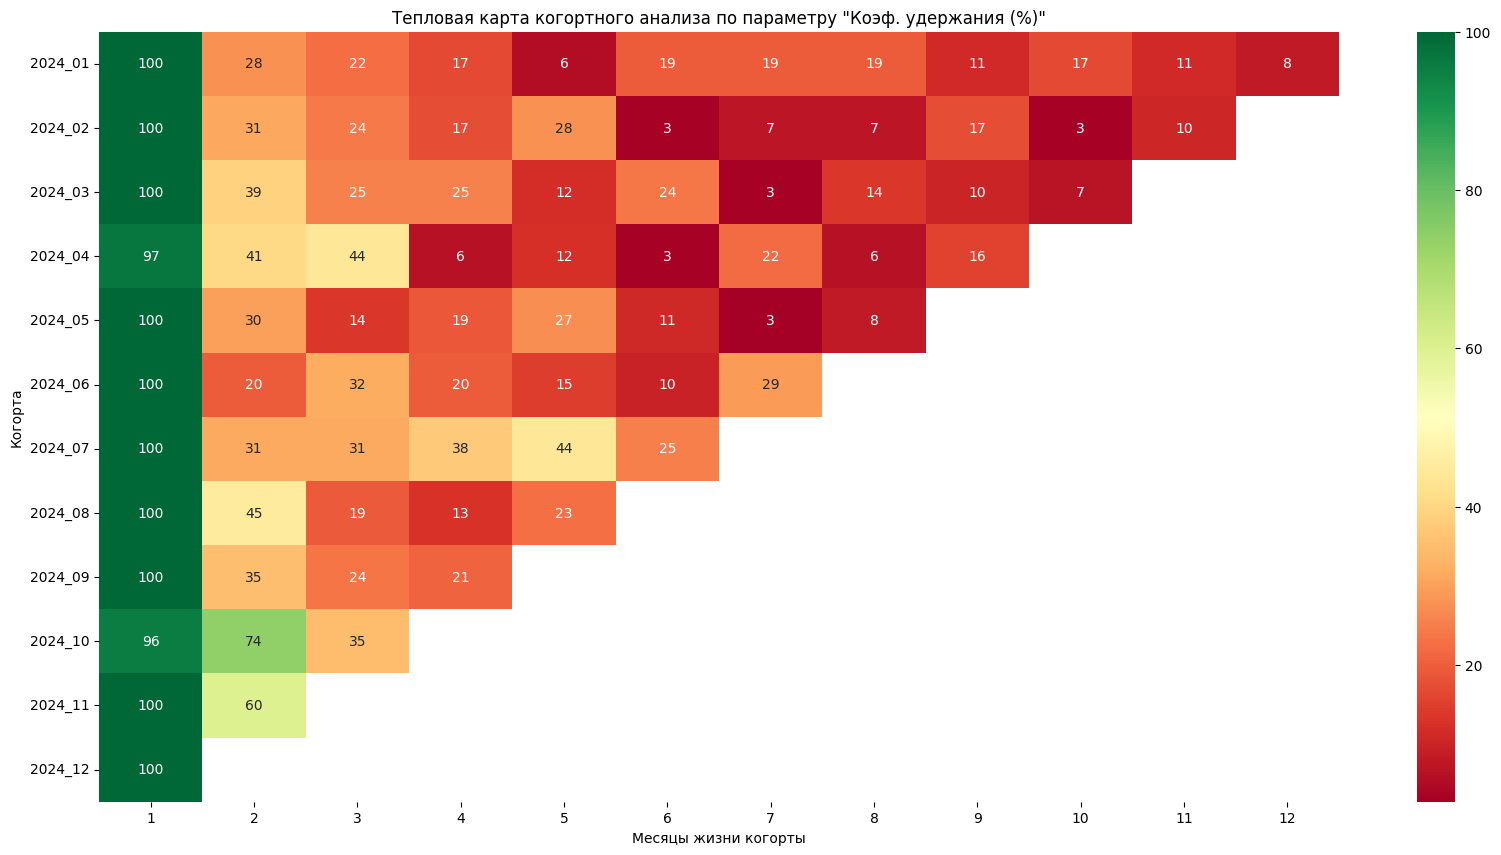

In [177]:
show_chogort_table_sns(simple_chogort_table, col='rr', ml=12)

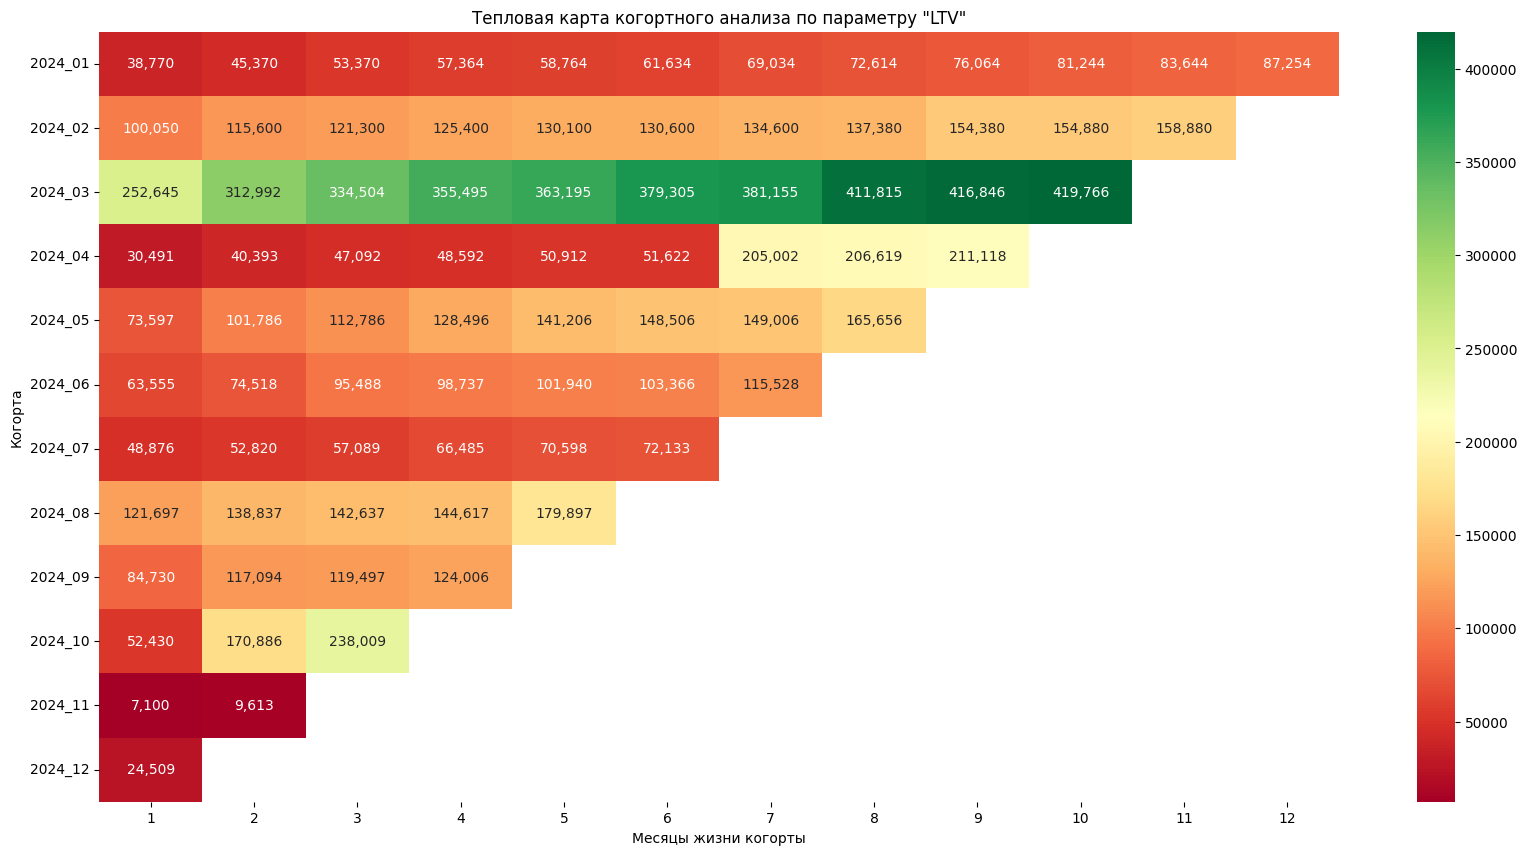

In [178]:
show_chogort_table_sns(simple_chogort_table, col='ltv', ml=12)

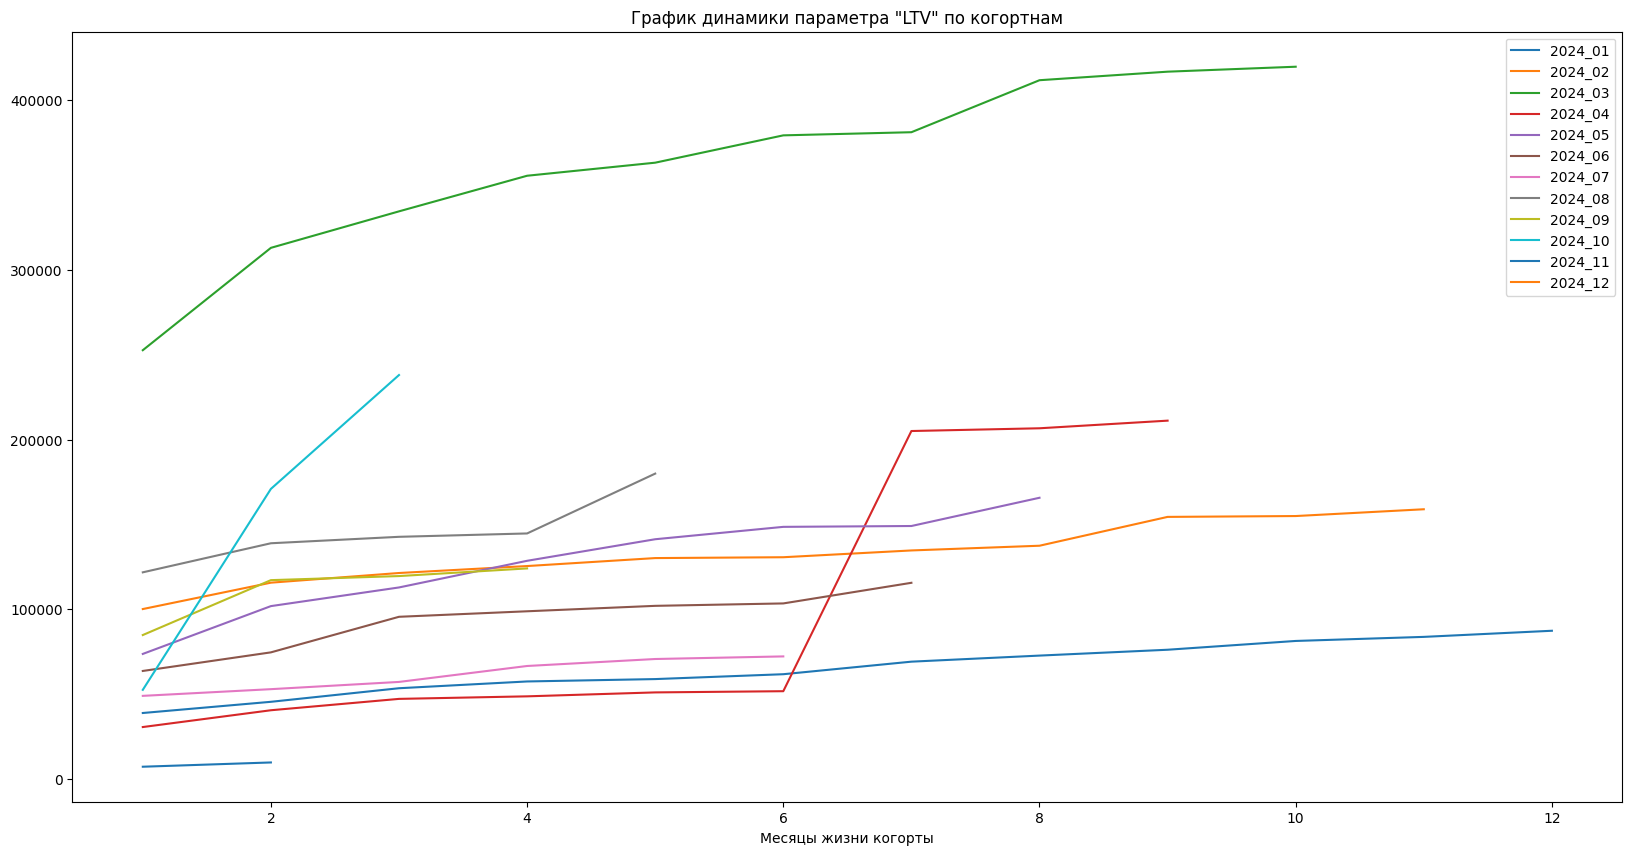

In [179]:
show_chogort_graf(simple_chogort_table, col='ltv', ml=12)

In [180]:
print(f"Точка пройдена в {datetime.datetime.now(tz)}\r\n От начала рассчета прошло {(datetime.datetime.now(tz) - start)}")

Точка пройдена в 2025-04-09 21:09:20.849949+04:00
 От начала рассчета прошло 0:00:52.195229


# Выводы

Полные выводы напишу позже =)

Пока видна большая поляризация пользователей на разовых и подписчиков. Разовых 2/3, а подписчиков менее 10%, при этом они приносят сопоставимые деньги...


Есть 3-4 акции, которые хорошо сыграли в последние 2 года. Видимо, стоит повторить их опыт.